## TODO
### Gaurav's points
- sacculi
- add random cells just before fixing to estimate background
- estimate how many mRNAs overall are in a cell for each condition => what fraction of the whole mRNA population is our mRNA of interest 
- use CCCP to cause stress
### Final plots
- RNAP/GCN vs. mu for each mRNA
- #mRNA/GCN vs. mu for the TAs and for rpoD. If stable for TAs and increasing for rpoD, it means rpoD is growth (up)regulated
- ln(estimated volume) vs mu (compare Suckjoon Jun paper)
- #mRNA/GCN = alpha * #mRNA/volume (they should be proportional if the data is correct)
- histogram of mRNA counts per condition and gene
- co-occurrences without the zero counts

## Setup

### Imports

In [1]:
from pathlib import Path

import pandas as pd
import re
import logging
import seaborn as sns
from itertools import combinations, product
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from scipy.stats import zscore
from seaborn import scatterplot

#from IPython.utils import io

pd.options.display.precision = 2

In [2]:
logging.basicConfig(format='%(asctime)s [%(levelname)s] %(message)s ', datefmt='%m/%d/%Y %I:%M:%S%p', level=logging.INFO)
rootdir = "/Volumes/Flodrive/Florence/smFISH/analysis"

logging.info(f'reading from directory {rootdir}')

12/12/2024 02:21:00PM [INFO] reading from directory /Volumes/Flodrive/Florence/smFISH/analysis 


### Constants

In [3]:
conditions = [
    {'label': 'MAN', 'mu': 0.12},
    {'label': 'GAL', 'mu': 0.17},
    {'label': 'GLY', 'mu': 0.32},
    {'label': 'GLU', 'mu': 0.54},
    {'label': 'LB', 'mu': 2.3},
]
csources_ordered = [c['label'] for c in conditions]

conditions_d = [
    {'label': 'mannose', 'mu': 0.12},
    {'label': 'galactose', 'mu': 0.17},
    {'label': 'glycerol', 'mu': 0.32},
    {'label': 'glucose', 'mu': 0.54},
    {'label': 'LB', 'mu': 2.3},
]
csources_ordered_d = [c['label'] for c in conditions_d]

conditions_d_noLB = [
    {'label': 'mannose', 'mu': 0.12},
    {'label': 'galactose', 'mu': 0.17},
    {'label': 'glycerol', 'mu': 0.32},
    {'label': 'glucose', 'mu': 0.54},
]
csources_ordered_d_noLB = [c['label'] for c in conditions_d_noLB]

growth_rates = {c['label']: c['mu'] for c in conditions}
mrna_ordered = ['rpoD', 'rnlAB', 'hipBA']
replicates_ordered = ['exp16', 'exp22', 'exp24']

display_labels = {
    'MAN': 'mannose',
    'GAL': 'galactose',
    'GLY': 'glycerol',
    'GLU': 'glucose',
    'LB': 'LB',
}

scale = [0.2, 0.065, 0.065]

### Palettes

In [4]:
palette_mrna = {
    'rpoD': 'magenta',
    'rnlAB': 'cyan',
    'hipBA': 'yellow',
}
palette_replicate = { z[0]: z[1] for z in zip(replicates_ordered, sns.color_palette("hls", len(replicates_ordered))) }
palette_csource = { z[0]: z[1] for z in zip(csources_ordered, sns.color_palette("viridis", len(csources_ordered))) }
palette_csource_d = { z[0]: z[1] for z in zip(csources_ordered_d, sns.color_palette("viridis", len(csources_ordered))) }
palette_csource_d

{'mannose': (0.267968, 0.223549, 0.512008),
 'galactose': (0.190631, 0.407061, 0.556089),
 'glycerol': (0.127568, 0.566949, 0.550556),
 'glucose': (0.20803, 0.718701, 0.472873),
 'LB': (0.565498, 0.84243, 0.262877)}

In [5]:
palette_csource_d_noLB = { z[0]: z[1] for z in zip(csources_ordered_d_noLB, sns.color_palette("viridis", len(csources_ordered))) }
palette_csource_d_noLB

{'mannose': (0.267968, 0.223549, 0.512008),
 'galactose': (0.190631, 0.407061, 0.556089),
 'glycerol': (0.127568, 0.566949, 0.550556),
 'glucose': (0.20803, 0.718701, 0.472873)}

# Results

## Load data

#### Stacked format
- format with 1 row per cell and per mrna
- mrna is specified in 'mrna' column
- so this df has about 3x total number of cells rows (because we have 3 rna channels)

In [6]:
dfs = []
for f in Path(rootdir).glob('*/*/results.csv'):
    cell_df = pd.read_csv(f.parent / "cells.csv")
    for mrna in mrna_ordered:
        f_mrna = Path(str(f) + f'.{mrna}')
        logging.info(f'..loading file: {f_mrna}')
        df = pd.read_csv(f_mrna)
        df['image'] = f_mrna.parts[-2]
        df['experiment'] = f_mrna.parts[-3]
        df = df.join(cell_df.set_index('image_cell_id'), on='image_cell_id')
        dfs.append(df)
df_stacked = pd.concat(dfs)

12/12/2024 02:21:03PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_01/results.csv.rpoD 
12/12/2024 02:21:03PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_01/results.csv.rnlAB 
12/12/2024 02:21:03PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_01/results.csv.hipBA 
12/12/2024 02:21:03PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_03/results.csv.rpoD 
12/12/2024 02:21:03PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_03/results.csv.rnlAB 
12/12/2024 02:21:03PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_03/results.csv.hipBA 
12/12/2024 02:21:04PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_05/results.csv.rpoD 
12

In [7]:
pattern = re.compile(f'(?P<strain>[0-9A-Za-z]+)[_-](?P<csource>{"|".join(csources_ordered)})[-_](?P<coverslip>.*)')

def parse_image_name(r):
    s = r['image']
    match = pattern.search(s)
    d = match.groupdict()
    
    seqnr = re.search('(?P<seqnr>[0-9]+)$', d['coverslip'])[0]
    d['coverslip'] = re.sub('_[0-9]+$', '', d['coverslip'])
    return d['strain'], d['csource'], d['coverslip'], seqnr

df_stacked[['strain', 'csource', 'coverslip', 'seqnr']] = df_stacked.apply(parse_image_name, axis=1, result_type='expand')
df_stacked['strain'] = 'MG1655'
df_stacked['replicate'] = df_stacked['experiment'].apply(lambda x: re.search('exp[0-9]+|LB$', x)[0])
df_stacked.loc[df_stacked['csource'] == 'LB', 'replicate'] = 'exp22'
df_stacked['unique_cell_id'] = df_stacked.apply(lambda r: r['replicate'] + "." + r['image'] + "." + str(r['image_cell_id']), axis=1)
df_stacked['unique_id'] = df_stacked.apply(lambda r: r['replicate'] + "." + r['image'] + "." + str(r['image_cell_id']) + "." + r['mrna'], axis=1)
df_stacked['selected'] = True

# after checking quality manually, we exclude 20241003-exp16 from the analysis:
df_stacked.loc[(df_stacked['experiment']=='20241003-exp16'), "selected"] = False
df_stacked = df_stacked[df_stacked['selected']]

df_stacked['volume'] = 4 / 3 * np.pi * pow(df_stacked['axis_minor_length'] / 2, 3) + np.pi * pow(df_stacked['axis_minor_length'] / 2, 2) * (df_stacked['axis_major_length'] - df_stacked['axis_minor_length'])
df_stacked['volume_ellipsoid'] = 4 / 3 * df_stacked['area'] * df_stacked['axis_minor_length'] / 2

df_stacked['axis_major_length'] = df_stacked['axis_major_length'] * scale[1]
df_stacked['area'] = df_stacked['area'] * scale[1] * scale[2]
df_stacked['volume'] = df_stacked['volume'] * scale[0] * scale[1] * scale[2]
df_stacked['volume_ellipsoid'] = df_stacked['volume_ellipsoid'] * scale[0] * scale[1] * scale[2]
# # remove one LB outlier that caused a lot of misery
# df_stacked = df_stacked[df_stacked['volume'] < 2e5]


df_stacked['RNAs_over_area'] = df_stacked['total_RNAs'] / df_stacked['area']
df_stacked['RNAs_over_vol'] = df_stacked['total_RNAs'] / df_stacked['volume']
df_stacked['RNAs_over_length'] = df_stacked['total_RNAs'] / df_stacked['axis_major_length']
df_stacked['RNAs_over_eccentricity'] = df_stacked['total_RNAs'] / df_stacked['eccentricity']

df_stacked['mu'] = df_stacked.apply(lambda r: growth_rates[r['csource']], axis=1)
df_stacked['tau (h)'] = np.log(2) / df_stacked['mu']
df_stacked['tau (min)'] = df_stacked['tau (h)'] * 60

df_stacked['csource_d'] = df_stacked['csource'].apply(lambda x: display_labels[x])

df_stacked


image_cell_id  spots  dense_regions  decomposed_RNAs  tx  nascent_RNAs  \
0              531      0              0                0   0             0   
1              533      0              0                0   0             0   
2              535      0              0                0   0             0   
3              537      0              0                0   0             0   
4              540      0              0                0   0             0   
..             ...    ...            ...              ...  ..           ...   
546           2163      1              0                0   0             0   
547           2166      1              0                0   0             0   
548           2168      2              0                0   0             0   
549           2177      0              0                0   0             0   
550           2179      0              0                0   0             0   

     total_RNAs   mrna  strain                    condition  ... volume  \
0             0   rpoD  MG1655                          GLU  ...   3.80   
1             0   rpoD  MG1655                          GLU  ...   5.38   
2             0   rpoD  MG1655                          GLU  ...   5.86   
3             0   rpoD  MG1655                          GLU  ...   4.24   
4             0   rpoD  MG1655                          GLU  ...   3.63   
..          ...    ...     ...                          ...  ...    ...   
546           1  hipBA  MG1655  LB_fixed2806_hybed1906_left  ...   3.91   
547           1  hipBA  MG1655  LB_fixed2806_hybed1906_left  ...  10.32   
548           2  hipBA  MG1655  LB_fixed2806_hybed1906_left  ...   6.27   
549           0  hipBA  MG1655  LB_fixed2806_hybed1906_left  ...   8.11   
550           0  hipBA  MG1655  LB_fixed2806_hybed1906_left  ...   4.57   

    volume_ellipsoid RNAs_over_area  RNAs_over_vol  RNAs_over_length  \
0               2.96           0.00           0.00              0.00   
1               4.25           0.00           0.00              0.00   
2               4.17           0.00           0.00              0.00   
3               3.18           0.00           0.00              0.00   
4               2.67           0.00           0.00              0.00   
..               ...            ...            ...               ...   
546             3.00           0.68           0.26              0.51   
547             9.84           0.37           0.10              0.52   
548             4.36           0.97           0.32              0.71   
549             6.17           0.00           0.00              0.00   
550             3.65           0.00           0.00              0.00   

     RNAs_over_eccentricity    mu  tau (h)  tau (min)  csource_d  
0                      0.00  0.54     1.28      77.02    glucose  
1                      0.00  0.54     1.28      77.02    glucose  
2                      0.00  0.54     1.28      77.02    glucose  
3                      0.00  0.54     1.28      77.02    glucose  
4                      0.00  0.54     1.28      77.02    glucose  
..                      ...   ...      ...        ...        ...  
546                    1.16  2.30     0.30      18.08         LB  
547                    2.51  2.30     0.30      18.08         LB  
548                    2.15  2.30     0.30      18.08         LB  
549                    0.00  2.30     0.30      18.08         LB  
550                    0.00  2.30     0.30      18.08         LB  

[48624 rows x 52 columns]

In [8]:
df_stacked.shape

(48624, 52)

In [9]:
df_stacked.columns

Index(['image_cell_id', 'spots', 'dense_regions', 'decomposed_RNAs', 'tx',
       'nascent_RNAs', 'total_RNAs', 'mrna', 'strain', 'condition', 'seqnr',
       'image', 'experiment', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'area',
       'eccentricity', 'axis_minor_length', 'axis_major_length', 'orientation',
       'perimeter', 'solidity', 'bbox-0_expanded', 'bbox-1_expanded',
       'bbox-2_expanded', 'bbox-3_expanded', 'area_expanded',
       'eccentricity_expanded', 'axis_minor_length_expanded',
       'axis_major_length_expanded', 'orientation_expanded',
       'perimeter_expanded', 'solidity_expanded', 'nuclei', 'csource',
       'coverslip', 'replicate', 'unique_cell_id', 'unique_id', 'selected',
       'volume', 'volume_ellipsoid', 'RNAs_over_area', 'RNAs_over_vol',
       'RNAs_over_length', 'RNAs_over_eccentricity', 'mu', 'tau (h)',
       'tau (min)', 'csource_d'],
      dtype='object')

In [10]:
df_stacked.index

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       541, 542, 543, 544, 545, 546, 547, 548, 549, 550],
      dtype='int64', length=48624)

In [11]:
df_stacked = df_stacked.set_index('unique_id')
df_stacked

image_cell_id  spots  \
unique_id                                                                  
exp24.exp24-GLU-right-2_01.531.rpoD                           531      0   
exp24.exp24-GLU-right-2_01.533.rpoD                           533      0   
exp24.exp24-GLU-right-2_01.535.rpoD                           535      0   
exp24.exp24-GLU-right-2_01.537.rpoD                           537      0   
exp24.exp24-GLU-right-2_01.540.rpoD                           540      0   
...                                                           ...    ...   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...           2163      1   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...           2166      1   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...           2168      2   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.217...           2177      0   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.217...           2179      0   

                                                    dense_regions  \
unique_id                                                           
exp24.exp24-GLU-right-2_01.531.rpoD                             0   
exp24.exp24-GLU-right-2_01.533.rpoD                             0   
exp24.exp24-GLU-right-2_01.535.rpoD                             0   
exp24.exp24-GLU-right-2_01.537.rpoD                             0   
exp24.exp24-GLU-right-2_01.540.rpoD                             0   
...                                                           ...   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...              0   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...              0   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...              0   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.217...              0   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.217...              0   

                                                    decomposed_RNAs  tx  \
unique_id                                                                 
exp24.exp24-GLU-right-2_01.531.rpoD                               0   0   
exp24.exp24-GLU-right-2_01.533.rpoD                               0   0   
exp24.exp24-GLU-right-2_01.535.rpoD                               0   0   
exp24.exp24-GLU-right-2_01.537.rpoD                               0   0   
exp24.exp24-GLU-right-2_01.540.rpoD                               0   0   
...                                                             ...  ..   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...                0   0   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...                0   0   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...                0   0   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.217...                0   0   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.217...                0   0   

                                                    nascent_RNAs  total_RNAs  \
unique_id                                                                      
exp24.exp24-GLU-right-2_01.531.rpoD                            0           0   
exp24.exp24-GLU-right-2_01.533.rpoD                            0           0   
exp24.exp24-GLU-right-2_01.535.rpoD                            0           0   
exp24.exp24-GLU-right-2_01.537.rpoD                            0           0   
exp24.exp24-GLU-right-2_01.540.rpoD                            0           0   
...                                                          ...         ...   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...             0           1   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...             0           1   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...             0           2   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.217...             0           0   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.217...             0           0   

                                                     mrna  strain  \
unique_id                                                           
exp24.exp2

In [12]:
df_stacked.index.unique()

Index(['exp24.exp24-GLU-right-2_01.531.rpoD',
       'exp24.exp24-GLU-right-2_01.533.rpoD',
       'exp24.exp24-GLU-right-2_01.535.rpoD',
       'exp24.exp24-GLU-right-2_01.537.rpoD',
       'exp24.exp24-GLU-right-2_01.540.rpoD',
       'exp24.exp24-GLU-right-2_01.546.rpoD',
       'exp24.exp24-GLU-right-2_01.550.rpoD',
       'exp24.exp24-GLU-right-2_01.551.rpoD',
       'exp24.exp24-GLU-right-2_01.554.rpoD',
       'exp24.exp24-GLU-right-2_01.559.rpoD',
       ...
       'exp22.MG1655_LB_fixed2806_hybed1906_left_07.2150.hipBA',
       'exp22.MG1655_LB_fixed2806_hybed1906_left_07.2152.hipBA',
       'exp22.MG1655_LB_fixed2806_hybed1906_left_07.2157.hipBA',
       'exp22.MG1655_LB_fixed2806_hybed1906_left_07.2159.hipBA',
       'exp22.MG1655_LB_fixed2806_hybed1906_left_07.2160.hipBA',
       'exp22.MG1655_LB_fixed2806_hybed1906_left_07.2163.hipBA',
       'exp22.MG1655_LB_fixed2806_hybed1906_left_07.2166.hipBA',
       'exp22.MG1655_LB_fixed2806_hybed1906_left_07.2168.hipBA',
       'e

In [13]:
csources = df_stacked['csource'].unique()
strains = df_stacked['strain'].unique()
seqnrs = df_stacked['seqnr'].unique() 
mrnas = df_stacked['mrna'].unique() 
replicates = df_stacked['replicate'].unique()
experiments = df_stacked['experiment'].unique()
csources, strains, seqnrs, mrnas, replicates, experiments

(array(['GLU', 'GLY', 'GAL', 'MAN', 'LB'], dtype=object),
 array(['MG1655'], dtype=object),
 array(['01', '03', '05', '02', '06', '10', '04', '07', '08', '09', '11'],
       dtype=object),
 array(['rpoD', 'rnlAB', 'hipBA'], dtype=object),
 array(['exp24', 'exp22', 'exp16'], dtype=object),
 array(['20241029-exp24', '20241029-exp22', '20240927-exp16',
        '20240927-LB'], dtype=object))

In [14]:
df_stacked.query('total_RNAs > 10')

image_cell_id  spots  \
unique_id                                                                  
exp24.exp24-GLY-left_02.286.hipBA                             286      1   
exp24.exp24-GLY-left_02.358.hipBA                             358     10   
exp24.exp24-GLY-left_03.752.rpoD                              752      7   
exp24.exp24-GLY-left_03.752.hipBA                             752     18   
exp24.exp24-GLY-left_06.246.rnlAB                             246      1   
...                                                           ...    ...   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.200...           2003      7   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...           2065     10   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...           2067      7   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.181...           1814     10   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...           2065      6   

                                                    dense_regions  \
unique_id                                                           
exp24.exp24-GLY-left_02.286.hipBA                               1   
exp24.exp24-GLY-left_02.358.hipBA                               4   
exp24.exp24-GLY-left_03.752.rpoD                                3   
exp24.exp24-GLY-left_03.752.hipBA                               3   
exp24.exp24-GLY-left_06.246.rnlAB                               1   
...                                                           ...   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.200...              2   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...              3   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...              2   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.181...              4   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...              5   

                                                    decomposed_RNAs  tx  \
unique_id                                                                 
exp24.exp24-GLY-left_02.286.hipBA                                11   1   
exp24.exp24-GLY-left_02.358.hipBA                                18   0   
exp24.exp24-GLY-left_03.752.rpoD                                  7   0   
exp24.exp24-GLY-left_03.752.hipBA                                11   0   
exp24.exp24-GLY-left_06.246.rnlAB                                18   0   
...                                                             ...  ..   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.200...                8   1   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...                9   1   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...                6   1   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.181...               11   4   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...               21   3   

                                                    nascent_RNAs  total_RNAs  \
unique_id                                                                      
exp24.exp24-GLY-left_02.286.hipBA                             11          11   
exp24.exp24-GLY-left_02.358.hipBA                              0          24   
exp24.exp24-GLY-left_03.752.rpoD                               0          11   
exp24.exp24-GLY-left_03.752.hipBA                              0          26   
exp24.exp24-GLY-left_06.246.rnlAB                              0          18   
...                                                          ...         ...   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.200...             2          13   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...             3          16   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...             2          11   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.181...            11          17   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...            11          22   

                                                     mrna  strain  \
unique_id                                                           
exp24.exp2

In [15]:
df_stacked.query('total_RNAs > 10')['mrna'].value_counts()

mrna
rpoD     206
rnlAB     59
hipBA     15
Name: count, dtype: int64

In [16]:
df_stacked.query('dense_regions > 0')


image_cell_id  spots  \
unique_id                                                                  
exp24.exp24-GLU-right-2_01.561.rpoD                           561      2   
exp24.exp24-GLU-right-2_01.579.rpoD                           579      2   
exp24.exp24-GLU-right-2_01.1069.rpoD                         1069      1   
exp24.exp24-GLU-right-2_01.1136.rpoD                         1136      1   
exp24.exp24-GLU-right-2_01.1150.rpoD                         1150      1   
...                                                           ...    ...   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...           2060      1   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...           2065      6   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.208...           2084      2   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.210...           2100      2   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.211...           2116      1   

                                                    dense_regions  \
unique_id                                                           
exp24.exp24-GLU-right-2_01.561.rpoD                             1   
exp24.exp24-GLU-right-2_01.579.rpoD                             1   
exp24.exp24-GLU-right-2_01.1069.rpoD                            1   
exp24.exp24-GLU-right-2_01.1136.rpoD                            1   
exp24.exp24-GLU-right-2_01.1150.rpoD                            1   
...                                                           ...   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...              1   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...              5   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.208...              1   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.210...              1   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.211...              1   

                                                    decomposed_RNAs  tx  \
unique_id                                                                 
exp24.exp24-GLU-right-2_01.561.rpoD                               3   0   
exp24.exp24-GLU-right-2_01.579.rpoD                               7   0   
exp24.exp24-GLU-right-2_01.1069.rpoD                              2   1   
exp24.exp24-GLU-right-2_01.1136.rpoD                              3   0   
exp24.exp24-GLU-right-2_01.1150.rpoD                              3   0   
...                                                             ...  ..   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...                3   1   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...               21   3   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.208...                3   0   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.210...                3   1   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.211...                2   0   

                                                    nascent_RNAs  total_RNAs  \
unique_id                                                                      
exp24.exp24-GLU-right-2_01.561.rpoD                            0           4   
exp24.exp24-GLU-right-2_01.579.rpoD                            0           8   
exp24.exp24-GLU-right-2_01.1069.rpoD                           2           2   
exp24.exp24-GLU-right-2_01.1136.rpoD                           0           3   
exp24.exp24-GLU-right-2_01.1150.rpoD                           0           3   
...                                                          ...         ...   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...             3           3   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.206...            11          22   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.208...             0           4   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.210...             3           4   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.211...             0           2   

                                                     mrna  strain  \
unique_id                                                           
exp24.exp2

In [17]:
(df_stacked.query('dense_regions > 0')['mrna'].value_counts())


mrna
rpoD     1296
rnlAB     818
hipBA     593
Name: count, dtype: int64

In [18]:
df_stacked.query('tx > 0')['mrna'].value_counts()

mrna
rpoD     812
rnlAB    540
hipBA    304
Name: count, dtype: int64

#### Record format
- 1 row per cell, with info for all 3 mrna in this row
- number of rows = number of cells total (all processed pictures from all experiments)

In [19]:
dfs = []
for f in Path(rootdir).glob('*/*/results.csv'):
    logging.info(f'..loading file: {f}')
    df = pd.read_csv(f)
    df['image'] = f.parts[-2]
    df['experiment'] = f.parts[-3]
    dfs.append(df)
df_records = pd.concat(dfs)

12/12/2024 02:21:18PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_01/results.csv 
12/12/2024 02:21:18PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_03/results.csv 
12/12/2024 02:21:18PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLU-right-2_05/results.csv 
12/12/2024 02:21:18PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLY-left_02/results.csv 
12/12/2024 02:21:18PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLY-left_03/results.csv 
12/12/2024 02:21:18PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLY-left_06/results.csv 
12/12/2024 02:21:18PM [INFO] ..loading file: /Volumes/Flodrive/Florence/smFISH/analysis/20241029-exp24/exp24-GLY-left_10/results.csv 
12/12/2024 02:21:18PM [INFO] ..loading file: /Volumes

In [20]:
df_records['area']

0      360.0
1      452.0
2      526.0
3      408.0
4      387.0
       ...  
546    349.0
547    638.0
548    489.0
549    595.0
550    378.0
Name: area, Length: 17005, dtype: float64

In [21]:
df_records[['strain', 'csource', 'coverslip', 'seqnr']] = df_records.apply(parse_image_name, axis=1, result_type='expand')
df_records['strain'] = 'MG1655'
df_records['replicate'] = df_records['experiment'].apply(lambda x: re.search('exp[0-9]+|LB$', x)[0])
df_records.loc[df_records['csource'] == 'LB', 'replicate'] = 'exp22'
df_records['unique_cell_id'] = df_records.apply(lambda r: r['replicate'] + "." + r['image'] + "." + str(r['image_cell_id']), axis=1)
df_records['selected'] = True
# after checking quality manually, we exclude 20241003-exp16 from the analysis:
df_records.loc[(df_records['experiment']=='20241003-exp16'), "selected"] = False
df_records = df_records[df_records['selected'] == True]

df_records['mu'] = df_records.apply(lambda r: growth_rates[r['csource']], axis=1)
df_records['tau (h)'] = np.log(2) / df_records['mu']
df_records['tau (min)'] = df_records['tau (h)'] * 60

df_records['volume'] = 4 / 3 * np.pi * pow(df_records['axis_minor_length'] / 2, 3) + np.pi * pow(df_records['axis_minor_length'] / 2, 2) * (df_records['axis_major_length'] - df_records['axis_minor_length'])
df_records['volume_ellipsoid'] = 4 / 3 * df_records['area'] * df_records['axis_minor_length'] / 2

# # remove one LB outlier that caused a lot of misery
# df_stacked = df_stacked[df_stacked['volume'] < 2e5]
df_records['axis_major_length'] = df_records['axis_major_length'] * scale[1]
df_records['area'] = df_records['area'] * scale[1] * scale[2]
df_records['volume'] = df_records['volume'] * scale[0] * scale[1] * scale[2]
df_records['volume_ellipsoid'] = df_records['volume_ellipsoid'] * scale[0] * scale[1] * scale[2]

for mrna in mrna_ordered:
    df_records[f'RNAs_over_length_{mrna}'] = df_records[f'total_RNAs_{mrna}'] / df_records['axis_major_length']
    df_records[f'RNAs_over_area_{mrna}'] = df_records[f'total_RNAs_{mrna}'] / df_records['area']
    df_records[f'RNAs_over_vol_{mrna}'] = df_records[f'total_RNAs_{mrna}'] / df_records['volume']

df_records['csource_d'] = df_records['csource'].apply(lambda x: display_labels[x])
df_records


image_cell_id  bbox-0  bbox-1  bbox-2  bbox-3  area  eccentricity  \
0              531       4     488      19     519  1.52          0.89   
1              533       5     894      31     922  1.91          0.88   
2              535       6     804      42     839  2.22          0.96   
3              537      10     197      40     225  1.72          0.93   
4              540      15     794      45     823  1.64          0.95   
..             ...     ...     ...     ...     ...   ...           ...   
546           2163    1234    1791    1264    1809  1.47          0.87   
547           2166    1243    1760    1273    1789  2.70          0.40   
548           2168    1244    1658    1264    1701  2.07          0.93   
549           2177    1259    1848    1289    1885  2.51          0.90   
550           2179    1259    2199    1281    2226  1.60          0.81   

     axis_minor_length  axis_major_length  orientation  ...  \
0                14.61               2.06        -1.45  ...   
1                16.71               2.25        -0.86  ...   
2                14.09               3.20         0.75  ...   
3                13.82               2.48         0.71  ...   
4                12.25               2.63         0.78  ...   
..                 ...                ...          ...  ...   
546              15.25               1.98         0.36  ...   
547              27.38               1.94        -0.18  ...   
548              15.81               2.80         1.30  ...   
549              18.40               2.75         0.84  ...   
550              17.16               1.89         1.09  ...   

     RNAs_over_length_rpoD  RNAs_over_area_rpoD  RNAs_over_vol_rpoD  \
0                     0.00                 0.00                0.00   
1                     0.00                 0.00                0.00   
2                     0.00                 0.00                0.00   
3                     0.00                 0.00                0.00   
4                     0.00                 0.00                0.00   
..                     ...                  ...                 ...   
546                   0.51                 0.68                0.26   
547                   2.06                 1.48                0.39   
548                   1.07                 1.45                0.48   
549                   1.46                 1.59                0.49   
550                   1.59                 1.88                0.66   

     RNAs_over_length_rnlAB  RNAs_over_area_rnlAB  RNAs_over_vol_rnlAB  \
0                      0.00                  0.00                 0.00   
1                      0.00                  0.00                 0.00   
2                      0.00                  0.00                 0.00   
3                      0.00                  0.00                 0.00   
4                      0.00                  0.00                 0.00   
..                      ...                   ...                  ...   
546                    0.51                  0.68                 0.26   
547                    0.52                  0.37                 0.10   
548                    0.36                  0.48                 0.16   
549                    2.18                  2.39                 0.74   
550                    1.59                  1.88                 0.66   

     RNAs_over_length_hipBA  RNAs_over_area_hipBA  RNAs_over_vol_hipBA  \
0                      0.00                  0.00                 0.00   
1                      0.00                  0.00                 0.00   
2                      0.00                  0.00                 0.00   
3                      0.00                  0.00                 0.00   
4                      0.00                  0.00                 0.00   
..                      ...                   ...                  ...   
546                    0.51                  0.68                 0.26   
547                    0.

In [22]:
df_records.columns

Index(['image_cell_id', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'area',
       'eccentricity', 'axis_minor_length', 'axis_major_length', 'orientation',
       'perimeter', 'solidity', 'bbox-0_expanded', 'bbox-1_expanded',
       'bbox-2_expanded', 'bbox-3_expanded', 'area_expanded',
       'eccentricity_expanded', 'axis_minor_length_expanded',
       'axis_major_length_expanded', 'orientation_expanded',
       'perimeter_expanded', 'solidity_expanded', 'nuclei', 'spots_hipBA',
       'dense_regions_hipBA', 'decomposed_RNAs_hipBA', 'tx_hipBA',
       'nascent_RNAs_hipBA', 'total_RNAs_hipBA', 'spots_rnlAB',
       'dense_regions_rnlAB', 'decomposed_RNAs_rnlAB', 'tx_rnlAB',
       'nascent_RNAs_rnlAB', 'total_RNAs_rnlAB', 'spots_rpoD',
       'dense_regions_rpoD', 'decomposed_RNAs_rpoD', 'tx_rpoD',
       'nascent_RNAs_rpoD', 'total_RNAs_rpoD', 'strain', 'condition', 'seqnr',
       'image', 'experiment', 'csource', 'coverslip', 'replicate',
       'unique_cell_id', 'selected', 'mu', 'tau

In [23]:
df_records.shape, df_stacked.shape

((16208, 67), (48624, 51))

In [24]:
df_records.shape[0] * 3 - df_stacked.shape[0]


0

In [25]:
# Add z-scores
df_records['length_zscore'] = df_records.groupby(['strain', 'csource', 'replicate']).axis_major_length.transform(lambda x : zscore(x, ddof=1))
df_records['area_zscore'] = df_records.groupby(['strain', 'csource', 'replicate']).area.transform(lambda x : zscore(x, ddof=1))
df_records['volume_zscore'] = df_records.groupby(['strain', 'csource', 'replicate']).volume.transform(lambda x : zscore(x, ddof=1))
df_records[['image', 'image_cell_id', 'axis_major_length', 'length_zscore', 'area', 'area_zscore', 'volume', 'volume_zscore']]

image  image_cell_id  axis_major_length  \
0                     exp24-GLU-right-2_01            531               2.06   
1                     exp24-GLU-right-2_01            533               2.25   
2                     exp24-GLU-right-2_01            535               3.20   
3                     exp24-GLU-right-2_01            537               2.48   
4                     exp24-GLU-right-2_01            540               2.63   
..                                     ...            ...                ...   
546  MG1655_LB_fixed2806_hybed1906_left_07           2163               1.98   
547  MG1655_LB_fixed2806_hybed1906_left_07           2166               1.94   
548  MG1655_LB_fixed2806_hybed1906_left_07           2168               2.80   
549  MG1655_LB_fixed2806_hybed1906_left_07           2177               2.75   
550  MG1655_LB_fixed2806_hybed1906_left_07           2179               1.89   

     length_zscore  area  area_zscore  volume  volume_zscore  
0            -0.68  1.52        -0.77    3.80          -0.63  
1            -0.38  1.91        -0.03    5.38           0.01  
2             1.13  2.22         0.57    5.86           0.21  
3            -0.02  1.72        -0.38    4.24          -0.45  
4             0.23  1.64        -0.55    3.63          -0.70  
..             ...   ...          ...     ...            ...  
546          -1.29  1.47        -1.35    3.91          -0.34  
547          -1.32  2.70        -0.38   10.32          -0.06  
548          -0.79  2.07        -0.88    6.27          -0.24  
549          -0.82  2.51        -0.52    8.11          -0.16  
550          -1.35  1.60        -1.26    4.57          -0.31  

[16208 rows x 8 columns]

## Cell and spot counts

### Number of cells per csource

In [26]:
df_records.groupby(['strain', 'csource', 'replicate'])['unique_cell_id'].agg('count')

strain  csource  replicate
MG1655  GAL      exp22        1955
        GLU      exp16        2825
                 exp22        1399
                 exp24        1060
        GLY      exp16         361
                 exp22        2405
                 exp24        1683
        LB       exp22         997
        MAN      exp16        1638
                 exp22        1885
Name: unique_cell_id, dtype: int64

##### QC plot

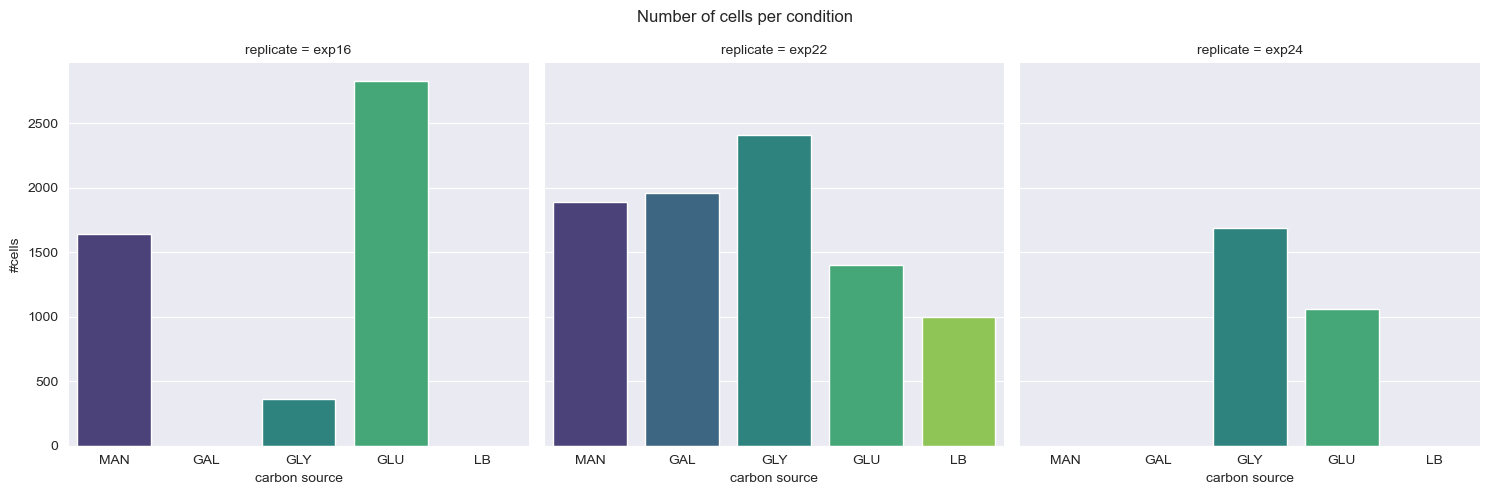

In [27]:
g = sns.catplot(pd.DataFrame(df_records.groupby(['strain', 'csource', 'replicate'])['unique_cell_id'].agg('count')).reset_index(),
            col='replicate', col_order=replicates_ordered, 
            kind='bar', estimator='sum', x='csource', order=csources_ordered, y='unique_cell_id', hue='csource', palette=palette_csource)
g.set(xlabel='carbon source', ylabel='#cells')
g.fig.suptitle('Number of cells per condition')
plt.tight_layout();

savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/nr_of_cells_vs_condition"
plt.savefig(savestem + ".pdf")


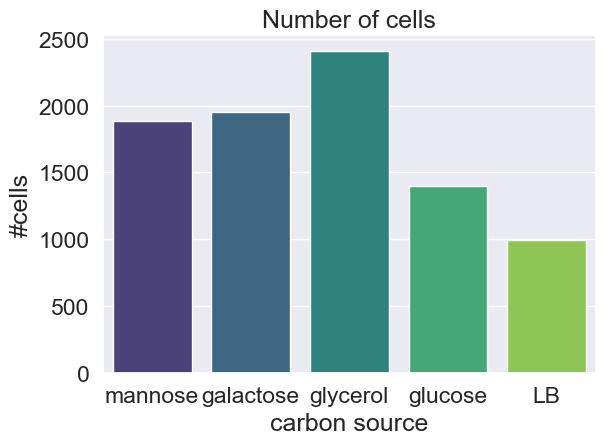

In [28]:
data = df_records.query('replicate == "exp22"')

sns.set(font_scale=1.5)
sns.barplot(pd.DataFrame(data.groupby(['strain', 'csource_d', 'replicate'])['unique_cell_id'].agg('count')).reset_index(),
            estimator='sum', x='csource_d', order=csources_ordered_d, y='unique_cell_id', hue='csource_d', palette=palette_csource_d)
plt.xlabel('carbon source')
plt.ylabel('#cells')
plt.title('Number of cells')
plt.tight_layout();

savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/nr_of_cells_vs_condition"
plt.savefig(savestem + ".pdf")


### Number of cells per csource per image

In [29]:
df_records.groupby(['strain', 'csource', 'replicate', 'seqnr'])['unique_cell_id'].agg('count')

strain  csource  replicate  seqnr
MG1655  GAL      exp22      03       1030
                            04        407
                            07        312
                            08        206
        GLU      exp16      02        825
                            03        593
                            04        514
                            05        893
                 exp22      01        143
                            02         99
                            04        148
                            05        128
                            06        171
                            07         98
                            08        110
                            09        318
                            10        184
                 exp24      01        431
                            03        307
                            05        322
        GLY      exp16      01         16
                            03         19
                            06        145


### Number of spots per csource

In [30]:
df_stacked.groupby(['strain', 'csource', 'replicate', 'mrna'])['total_RNAs'].agg(['sum'])


sum
strain csource replicate mrna       
MG1655 GAL     exp22     hipBA  1154
                         rnlAB   725
                         rpoD   1036
       GLU     exp16     hipBA  1033
                         rnlAB  2111
                         rpoD   6853
               exp22     hipBA   964
                         rnlAB   941
                         rpoD   4163
               exp24     hipBA   168
                         rnlAB   122
                         rpoD   1026
       GLY     exp16     hipBA    60
                         rnlAB   104
                         rpoD    362
               exp22     hipBA  1667
                         rnlAB  1292
                         rpoD   2538
               exp24     hipBA   511
                         rnlAB   308
                         rpoD   1153
       LB      exp22     hipBA  1571
                         rnlAB  3690
                         rpoD   6464
       MAN     exp16     hipBA   360
                         rnlAB   383
                         rpoD   1904
               exp22     hipBA   734
                         rnlAB   290
                         rpoD    628

#### QC plot

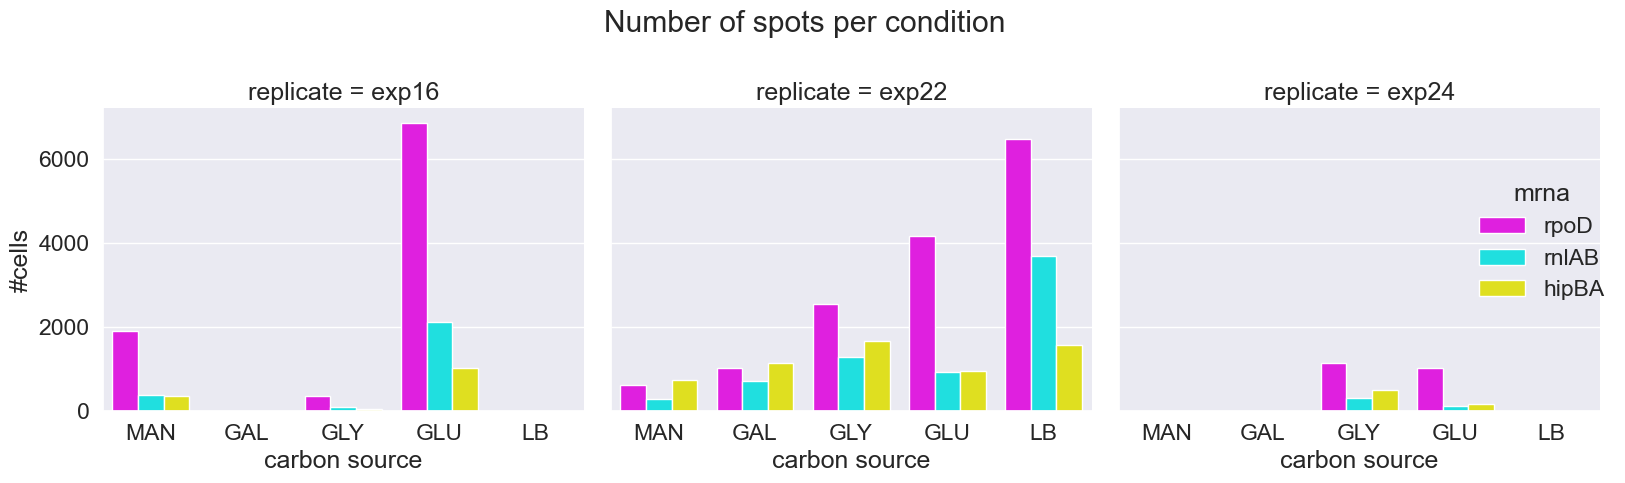

In [31]:
g = sns.catplot(pd.DataFrame(df_stacked.groupby(['strain', 'csource', 'replicate', 'mrna'])['total_RNAs'].agg('sum')).reset_index(),
            col='replicate', col_order=replicates_ordered, 
            kind='bar', x='csource', order=csources_ordered, y='total_RNAs', hue='mrna', hue_order=mrna_ordered, palette=palette_mrna)
g.set(xlabel='carbon source', ylabel='#cells')
g.fig.suptitle('Number of spots per condition')
plt.tight_layout();

## Plots

### Cell feature distributions

#### Explo plots area/length/volume distributions per condition

##### All, area

In [32]:
df_records.query('volume < 16.9').shape

(15617, 70)

In [33]:
csources_ordered

['MAN', 'GAL', 'GLY', 'GLU', 'LB']

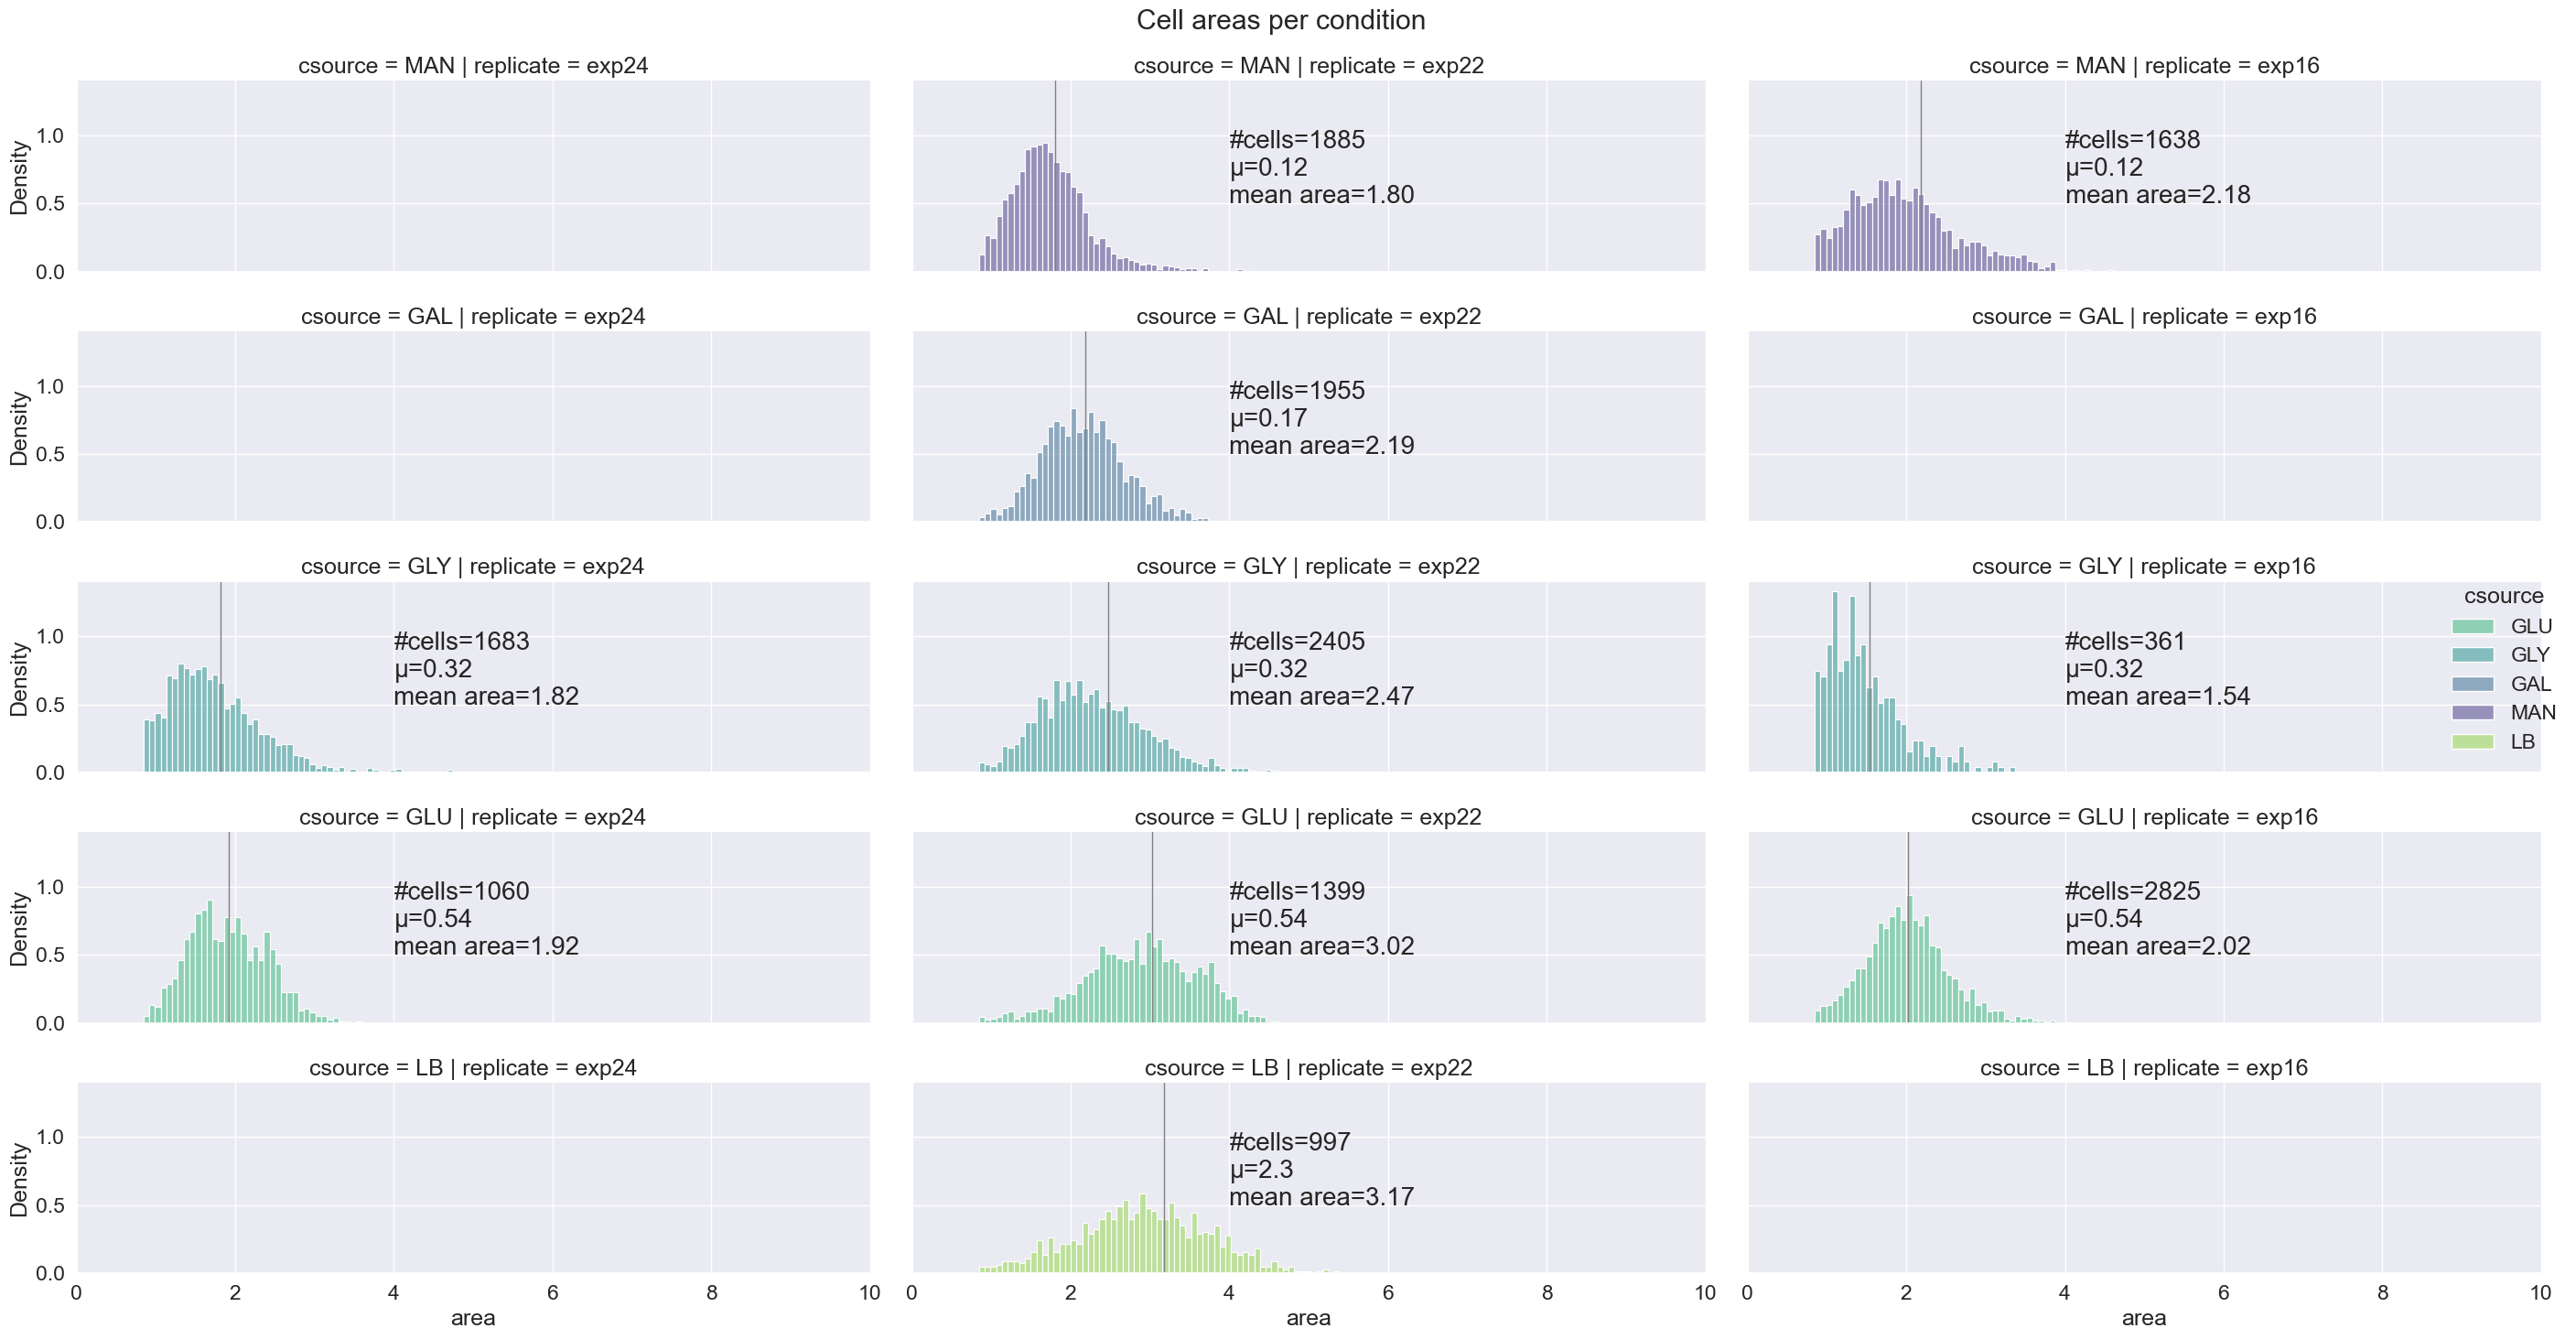

In [34]:
g = sns.displot(
    data=df_records.query('volume < 16.9'), x='area', stat='density', common_norm=False,
    row='csource', row_order=csources_ordered, col='replicate', col_order=replicates,
    hue='csource', palette=palette_csource,
    legend=True, height=3, aspect=3,
    facet_kws=dict(sharey=True, sharex=True))
g.set(xlim=(0, 10))
g.fig.suptitle('Cell areas per condition')
plt.tight_layout();

# this is pathetic but it works:
# extract and flatten the axes from the figure
axes = g.axes.flatten()

# iterate through each axes
for ax in axes:
    # extract the species name
    title = ax.get_title()
    csource = re.search('csource = (?P<csource>[A-Z]+)', title).groups()[0]
    replicate = re.search('replicate = (?P<replicate>exp[0-9]+)', title).groups()[0]
    # print(f'title: {title} csource: {csource} replicate: {replicate}')

    data = df_records.query('csource == @csource').query('replicate == @replicate')
    nr_cells = data.query('csource == @csource').shape[0]

    if data.empty is False:
        mean = data['area'].mean()
        std = data['area'].std()
        mu = data.query('csource == @csource')['mu'].unique()[0]
        ax.axvline(x=mean, c='grey', ls='-', lw=1)
        ax.annotate(f'#cells={nr_cells}\nµ={mu}\nmean area={mean:0.2f}', xy=(4, 0.5), xytext=(4, 0.5), fontsize=20)

# this is the right way to do it but it doesn't work:
# for (row, col, hue_idx), data in g.facet_data():
#     # # Skip empty data
#     if not data.values.size:
#         continue
# 
#     # Get the ax for `row` and `col`
#     # ax = g.facet_axis(row, col)
#     
#     print(row, col, hue_idx, data.shape)
#     
#     # # Set the `vline`s using the var `x_var`
#     # ax.axvline(data['area'].mean(), c="k", ls="-", lw=2.5)
#     # ax.axvline(data['area'].median(), c="orange", ls="--", lw=2.5)

In [35]:
df_records['mu'].value_counts()

mu
0.54    5284
0.32    4449
0.12    3523
0.17    1955
2.30     997
Name: count, dtype: int64

##### All, length 

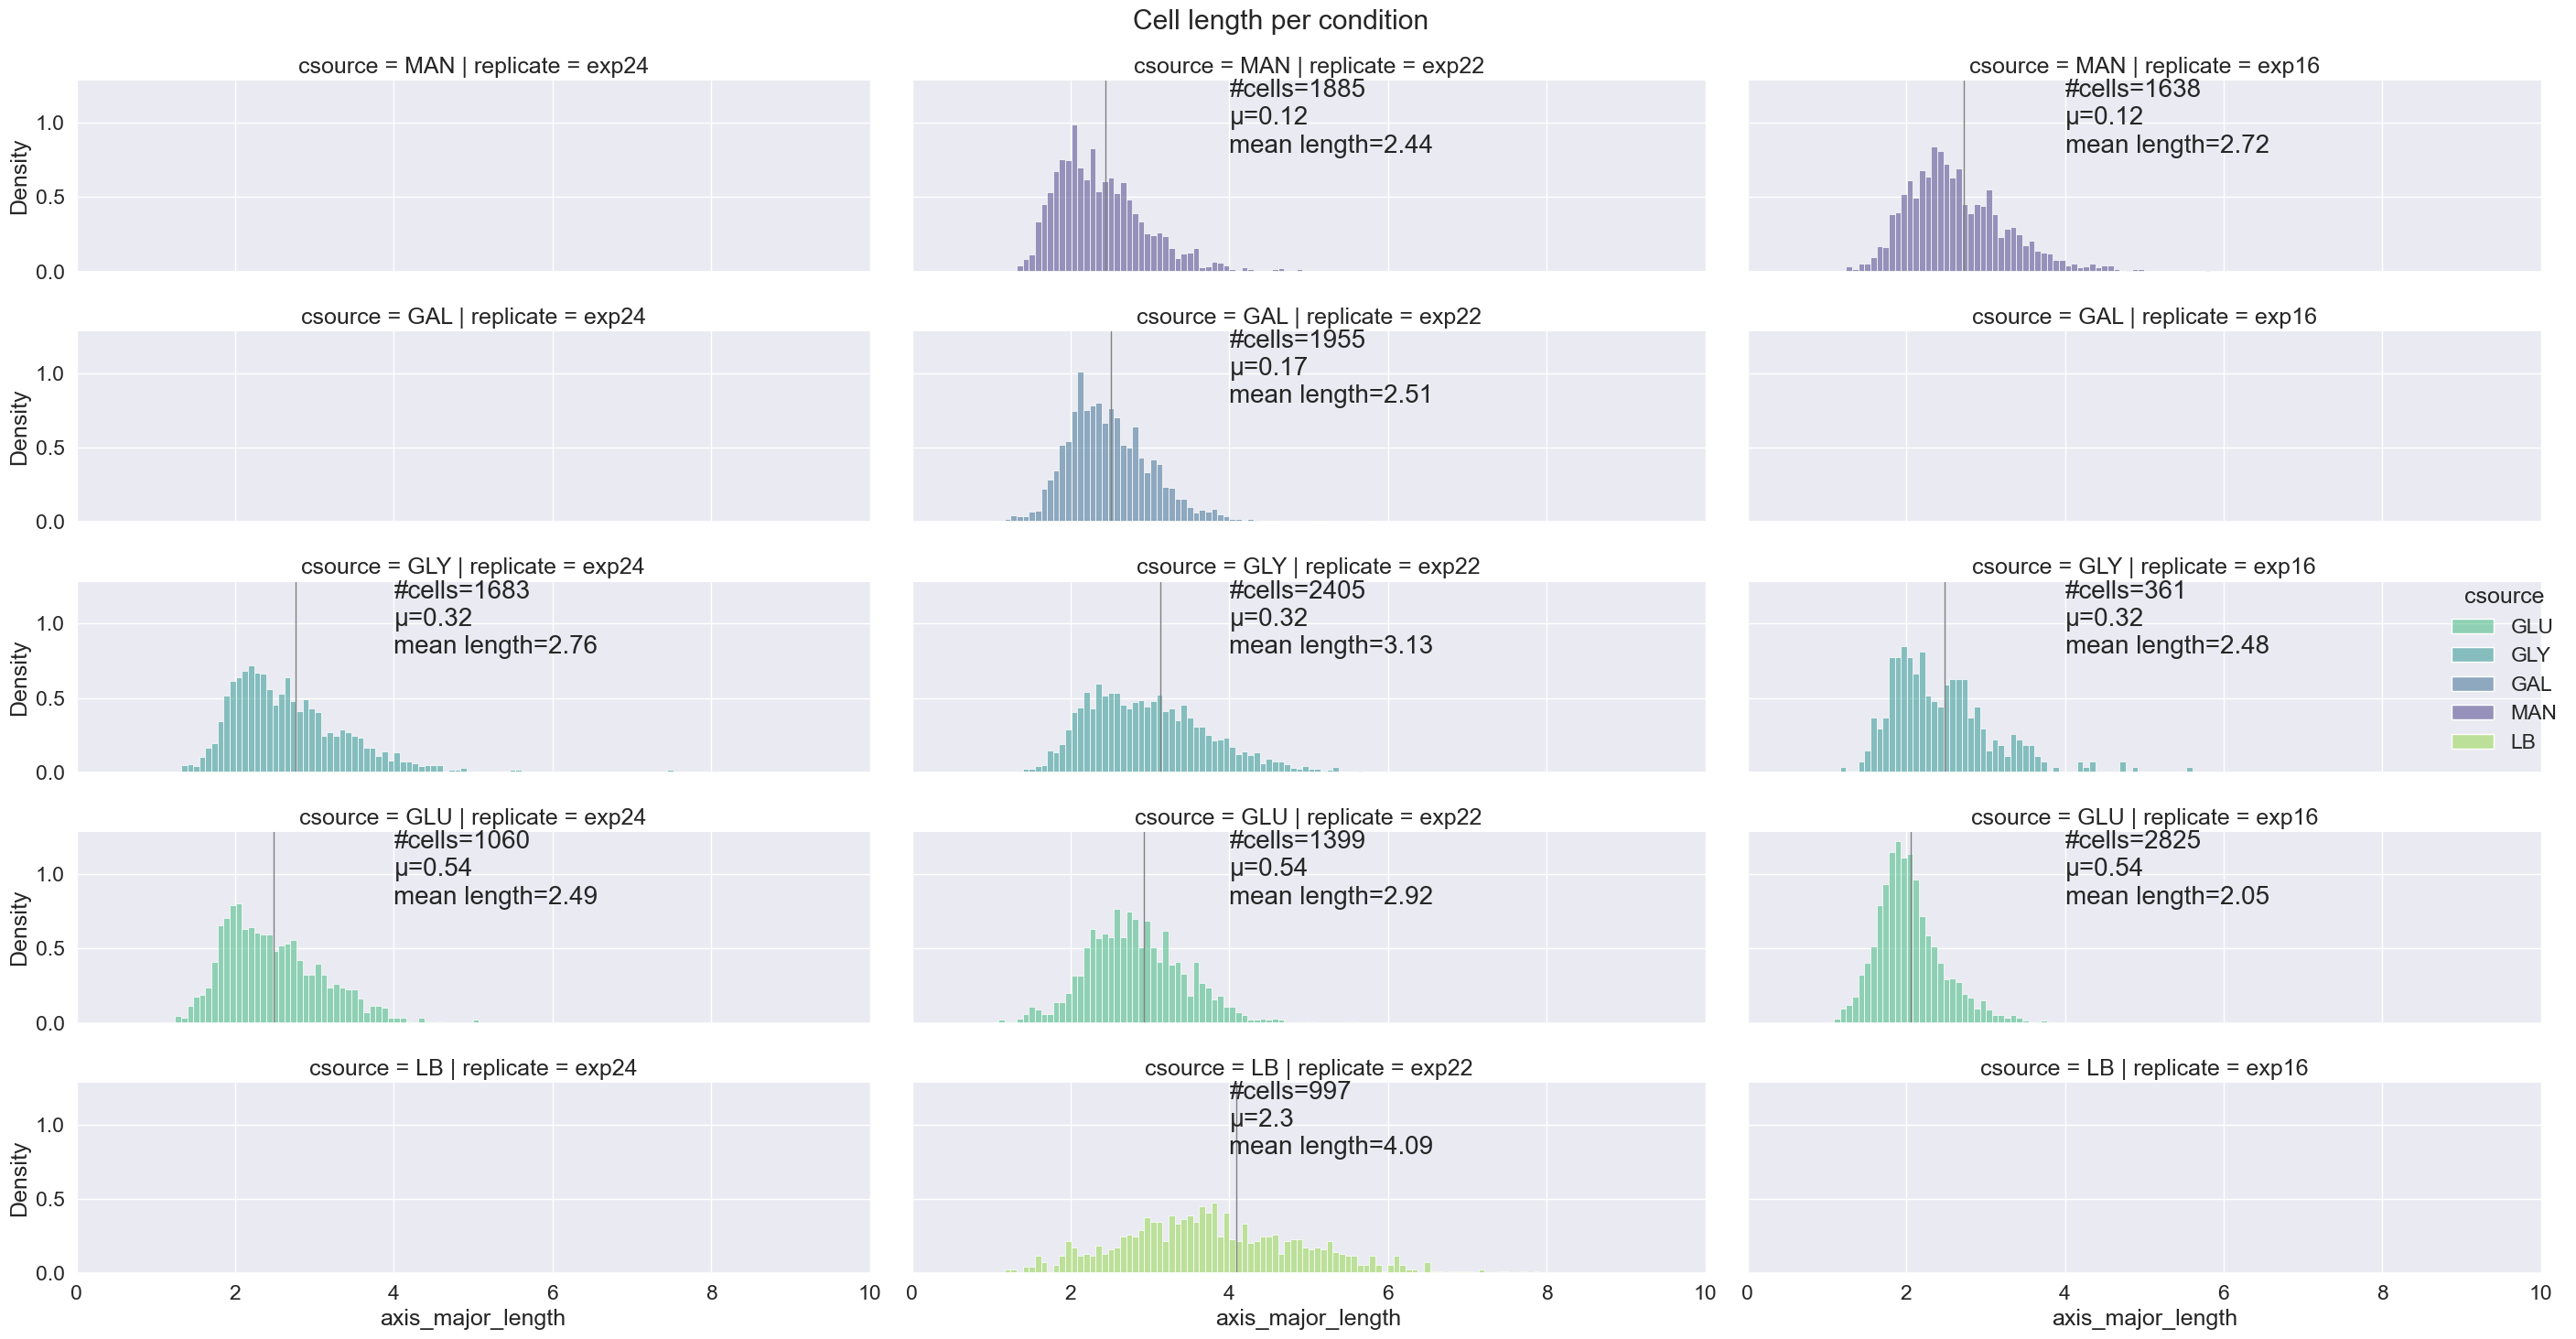

In [36]:
g = sns.displot(
    data=df_records.query('volume < 16.9'), x='axis_major_length', stat='density', common_norm=False,
    row='csource', row_order=csources_ordered, col='replicate', col_order=replicates, 
    hue='csource', palette=palette_csource, 
    legend=True, height=3, aspect=3,
    facet_kws=dict(sharey=True, sharex=True))
g.set(xlim=(0, 10))
g.fig.suptitle('Cell length per condition')
plt.tight_layout();

# this is pathetic but it works:
# extract and flatten the axes from the figure
axes = g.axes.flatten()

# iterate through each axes
for ax in axes:
    # extract the species name
    title = ax.get_title()
    csource = re.search('csource = (?P<csource>[A-Z]+)', title).groups()[0]
    replicate = re.search('replicate = (?P<replicate>exp[0-9]+)', title).groups()[0]
    # print(f'title: {title} csource: {csource} replicate: {replicate}')
    
    data = df_records.query('csource == @csource').query('replicate == @replicate')
    nr_cells = data.query('csource == @csource').shape[0]
    
    if data.empty is False: 
        mean = data['axis_major_length'].mean()
        std = data['axis_major_length'].std()
        mu = data.query('csource == @csource')['mu'].unique()[0]
        ax.axvline(x=mean, c='grey', ls='-', lw=1)
        ax.annotate(f'#cells={nr_cells}\nµ={mu}\nmean length={mean:0.2f}', xy=(4, 0.6), xytext=(4, 0.8), fontsize=20)

# this is the right way to do it but it doesn't work:
# for (row, col, hue_idx), data in g.facet_data():
#     # # Skip empty data
#     if not data.values.size:
#         continue
# 
#     # Get the ax for `row` and `col`
#     # ax = g.facet_axis(row, col)
#     
#     print(row, col, hue_idx, data.shape)
#     
#     # # Set the `vline`s using the var `x_var`
#     # ax.axvline(data['area'].mean(), c="k", ls="-", lw=2.5)
#     # ax.axvline(data['area'].median(), c="orange", ls="--", lw=2.5)

##### All, volume

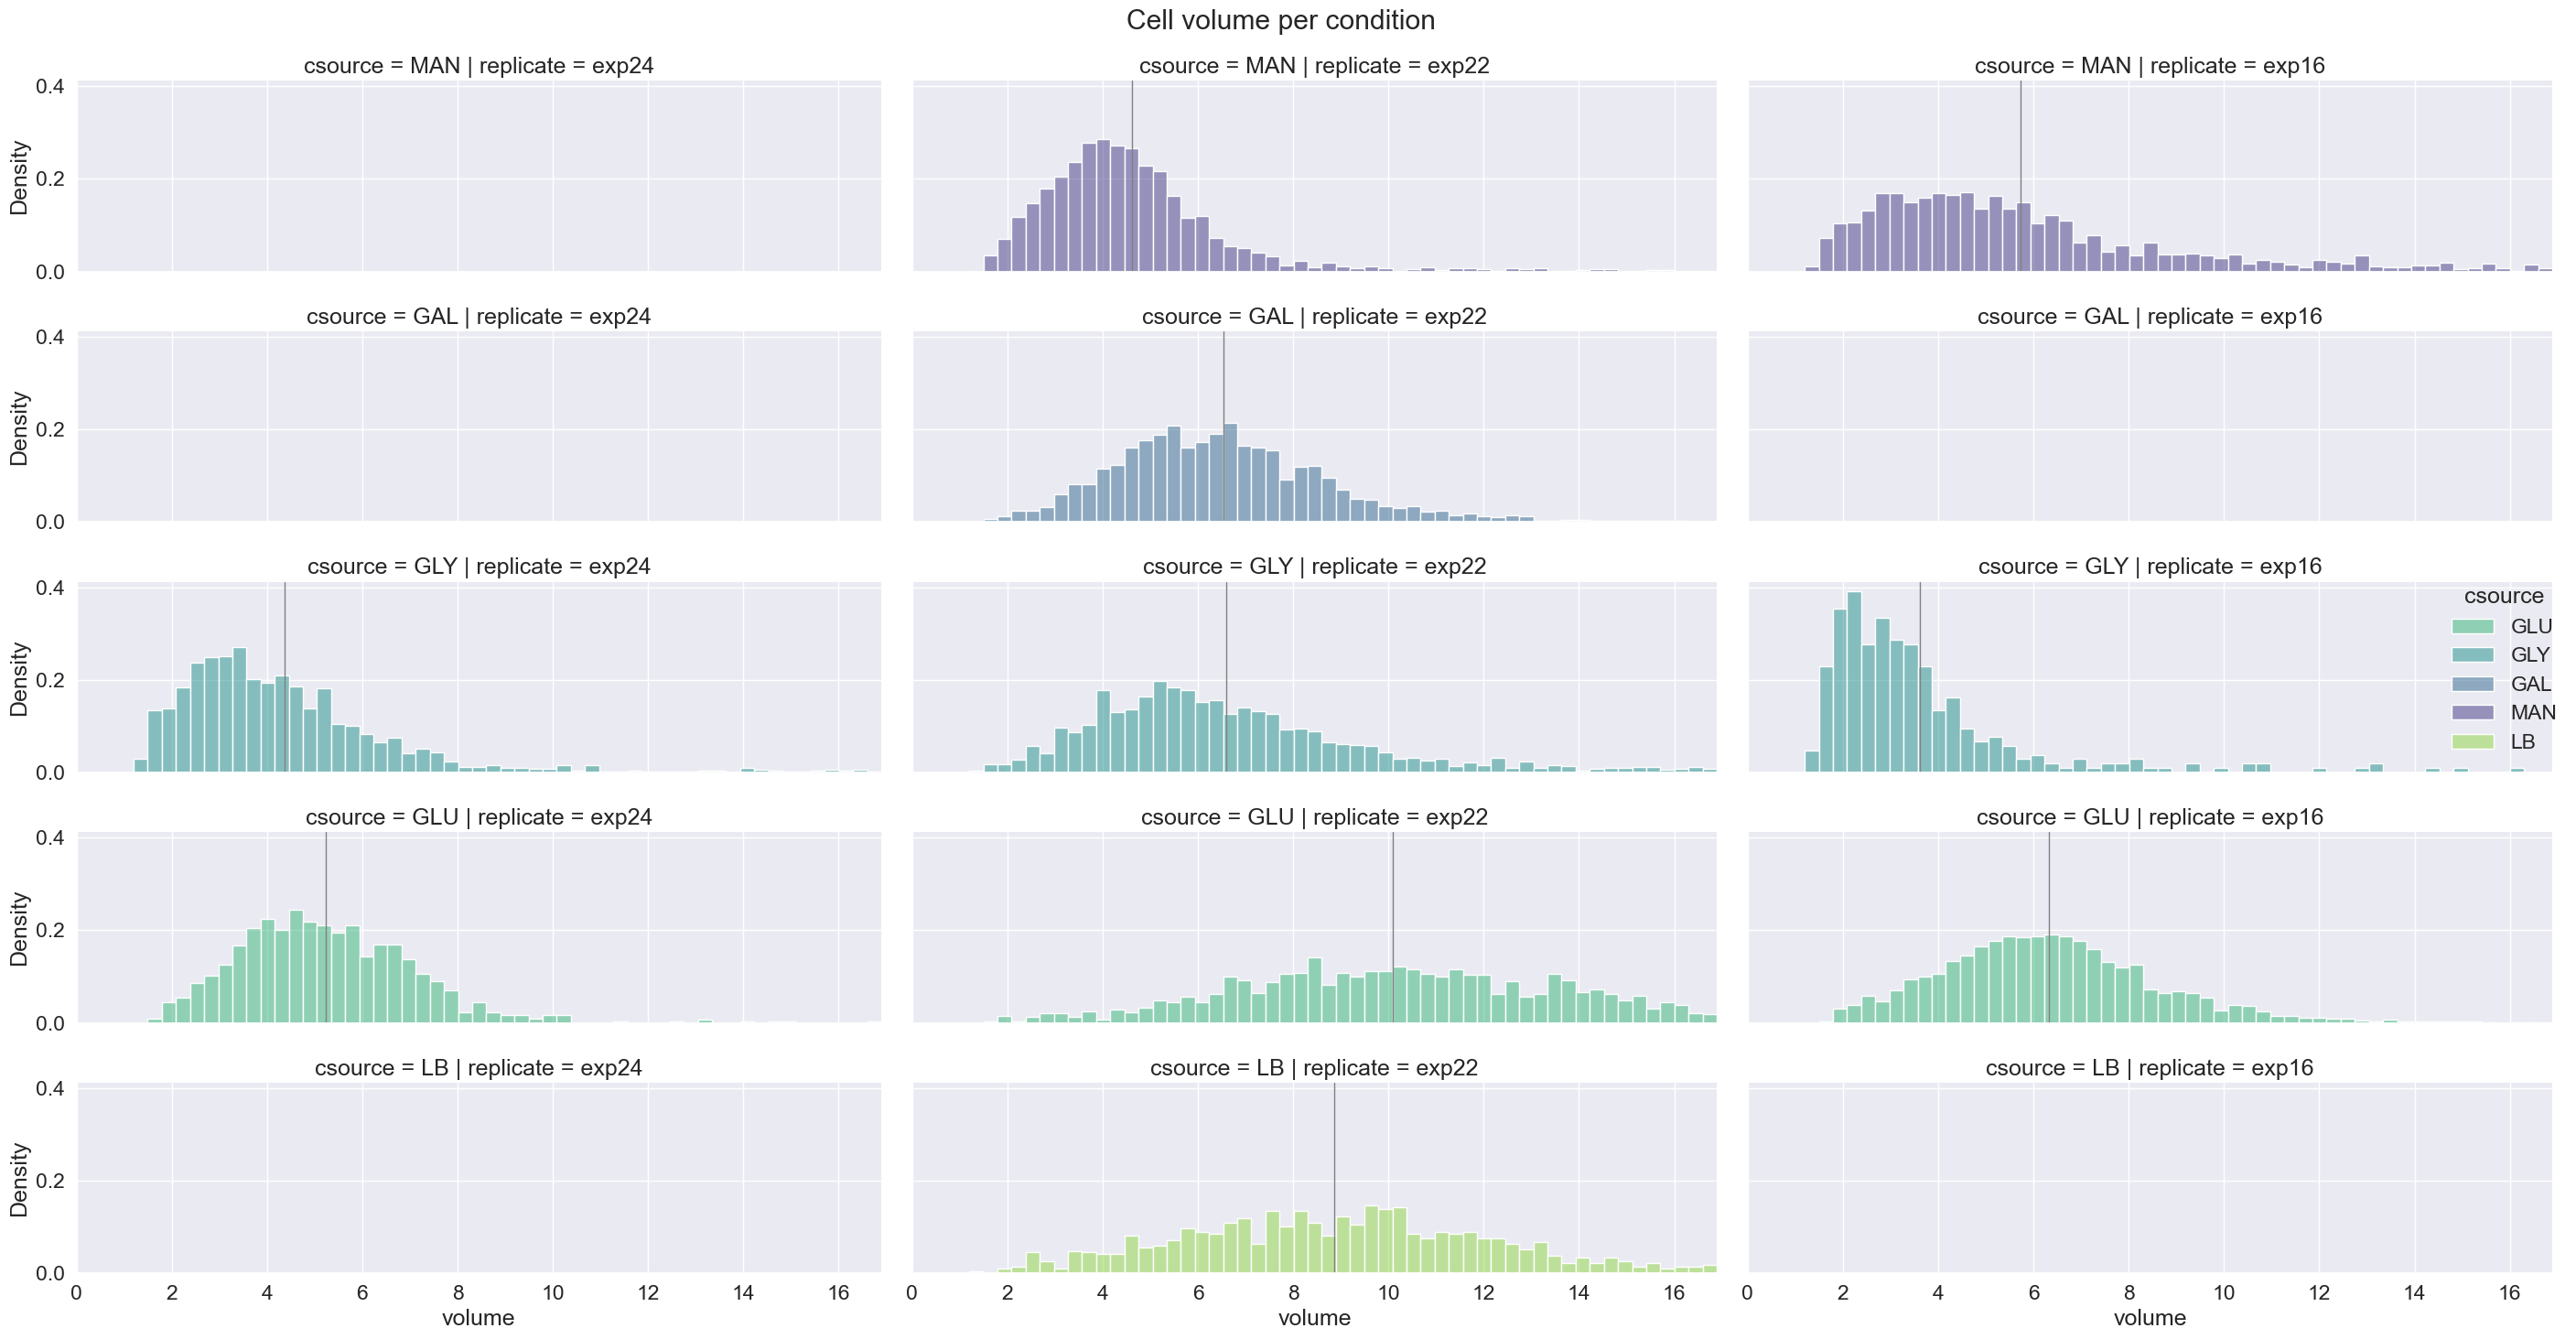

In [37]:
df_records_sane = df_records.query('volume < 16.9')
g = sns.displot(
    data=df_records_sane, x='volume', stat='density', common_norm=False,
    row='csource', row_order=csources_ordered, col='replicate', col_order=replicates,
    hue='csource', palette=palette_csource,
    legend=True, height=3, aspect=3,
    facet_kws=dict(sharey=True, sharex=True))
g.set(xlim=(0, 16.9))
g.fig.suptitle('Cell volume per condition')
plt.tight_layout();

# this is pathetic but it works:
# extract and flatten the axes from the figure
axes = g.axes.flatten()

# iterate through each axes
for ax in axes:
    # extract the species name
    title = ax.get_title()
    csource = re.search('csource = (?P<csource>[A-Z]+)', title).groups()[0]
    replicate = re.search('replicate = (?P<replicate>exp[0-9]+)', title).groups()[0]
    # print(f'title: {title} csource: {csource} replicate: {replicate}')

    data = df_records_sane.query('csource == @csource').query('replicate == @replicate')
    nr_cells = data.query('csource == @csource').shape[0]

    if data.empty is False:
        mean = data['volume'].mean()
        std = data['volume'].std()
        mu = data.query('csource == @csource')['mu'].unique()[0]
        ax.axvline(x=mean, c='grey', ls='-', lw=1)
        ax.annotate(f'#cells={nr_cells}\nµ={mu}\nmean volume={mean:0.0f}', xy=(10000, 0.00015), xytext=(10000, 0.00015), fontsize=20)

# this is the right way to do it but it doesn't work:
# for (row, col, hue_idx), data in g.facet_data():
#     # # Skip empty data
#     if not data.values.size:
#         continue
#
#     # Get the ax for `row` and `col`
#     # ax = g.facet_axis(row, col)
#
#     print(row, col, hue_idx, data.shape)
#
#     # # Set the `vline`s using the var `x_var`
#     # ax.axvline(data['area'].mean(), c="k", ls="-", lw=2.5)
#     # ax.axvline(data['area'].median(), c="orange", ls="--", lw=2.5)

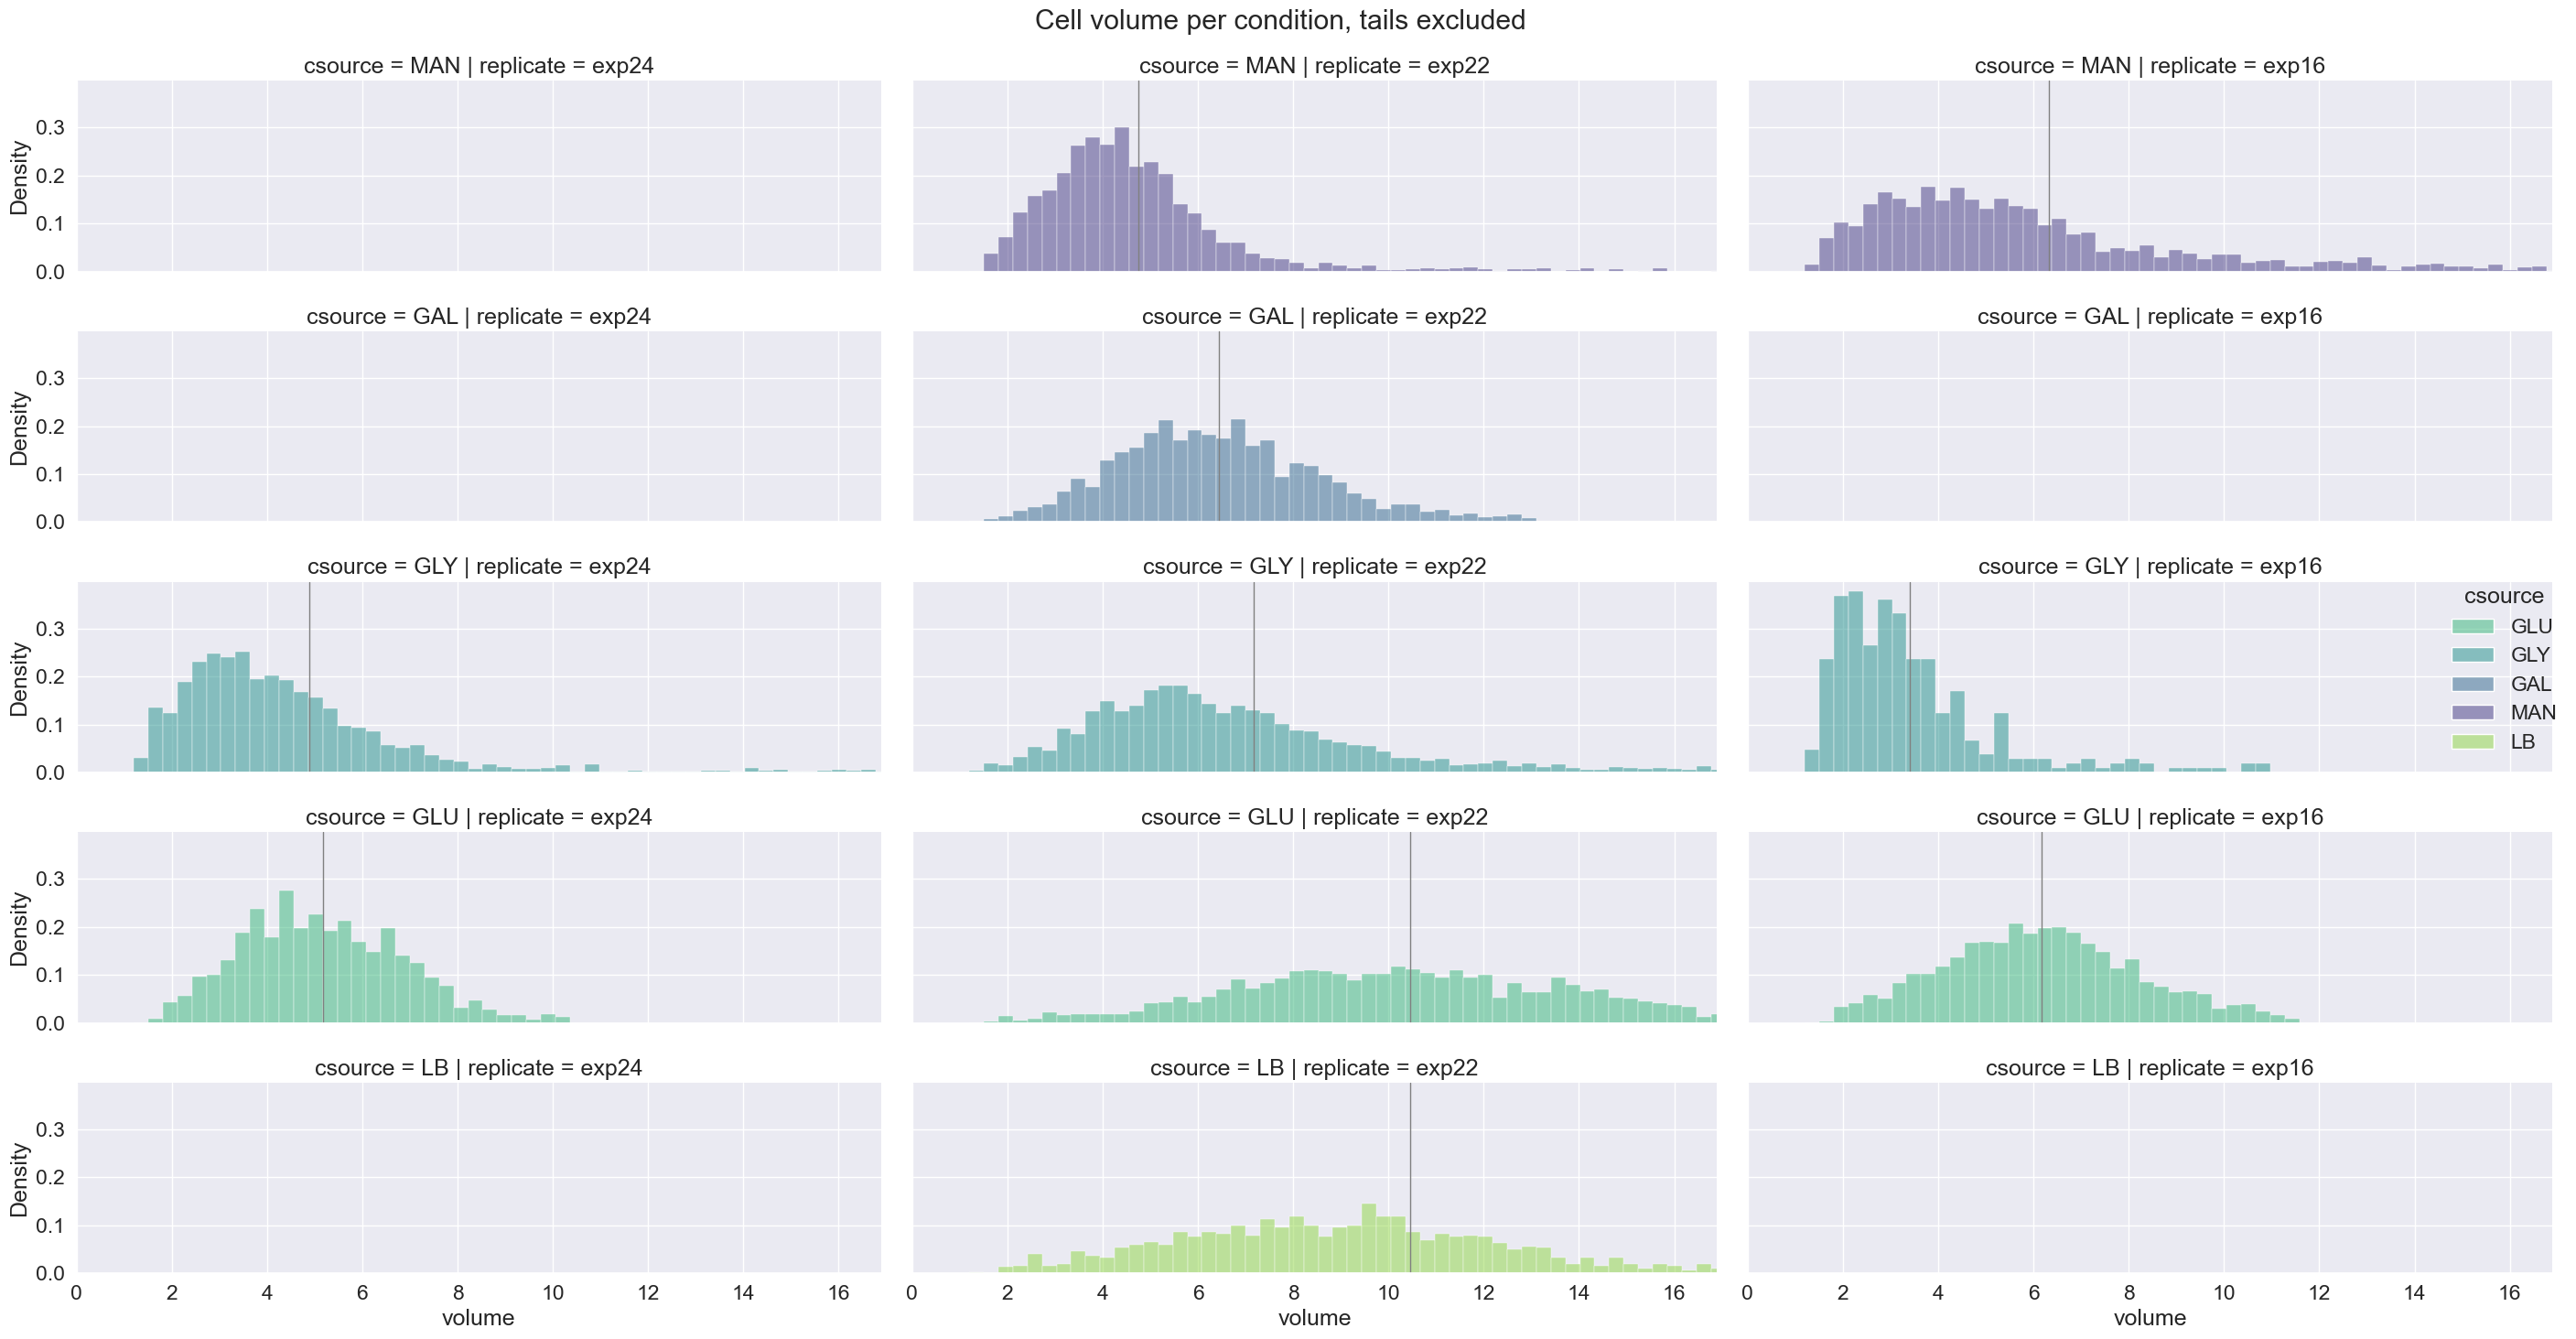

In [38]:
df_records_sane = df_records.query('volume_zscore > -2').query('volume_zscore < 2')
g = sns.displot(
    data=df_records_sane, x='volume', stat='density', common_norm=False,
    row='csource', row_order=csources_ordered, col='replicate', col_order=replicates,
    hue='csource', palette=palette_csource,
    legend=True, height=3, aspect=3,
    facet_kws=dict(sharey=True, sharex=True))
g.set(xlim=(0, 16.9))
g.fig.suptitle('Cell volume per condition, tails excluded')
plt.tight_layout();

# this is pathetic but it works:
# extract and flatten the axes from the figure
axes = g.axes.flatten()

# iterate through each axes
for ax in axes:
    # extract the species name
    title = ax.get_title()
    csource = re.search('csource = (?P<csource>[A-Z]+)', title).groups()[0]
    replicate = re.search('replicate = (?P<replicate>exp[0-9]+)', title).groups()[0]
    # print(f'title: {title} csource: {csource} replicate: {replicate}')

    data = df_records_sane.query('csource == @csource').query('replicate == @replicate')
    nr_cells = data.query('csource == @csource').shape[0]

    if data.empty is False:
        mean = data['volume'].mean()
        std = data['volume'].std()
        mu = data.query('csource == @csource')['mu'].unique()[0]
        ax.axvline(x=mean, c='grey', ls='-', lw=1)
        ax.annotate(f'#cells={nr_cells}\nµ={mu}\nmean volume={mean:0.0f}', xy=(10000, 0.00015), xytext=(10000, 0.00015), fontsize=20)

# this is the right way to do it but it doesn't work:
# for (row, col, hue_idx), data in g.facet_data():
#     # # Skip empty data
#     if not data.values.size:
#         continue
#
#     # Get the ax for `row` and `col`
#     # ax = g.facet_axis(row, col)
#
#     print(row, col, hue_idx, data.shape)
#
#     # # Set the `vline`s using the var `x_var`
#     # ax.axvline(data['area'].mean(), c="k", ls="-", lw=2.5)
#     # ax.axvline(data['area'].median(), c="orange", ls="--", lw=2.5)

#### Volume per condition

##### All

In [39]:
volumes = []
for csource in csources_ordered_d:
    # removing the one outlier with volume > 1e6 which is out of whack
    data = df_records.query('volume < 17').query('csource_d == @csource')
    volumes.append({'csource': csource, 'mean_volume': data.volume.mean(), 'mu': data.mu.mean()})
df_volume = pd.DataFrame(volumes)
df_volume

csource  mean_volume    mu
0    mannose         5.12  0.12
1  galactose         6.53  0.17
2   glycerol         5.49  0.32
3    glucose         7.07  0.54
4         LB         8.85  2.30

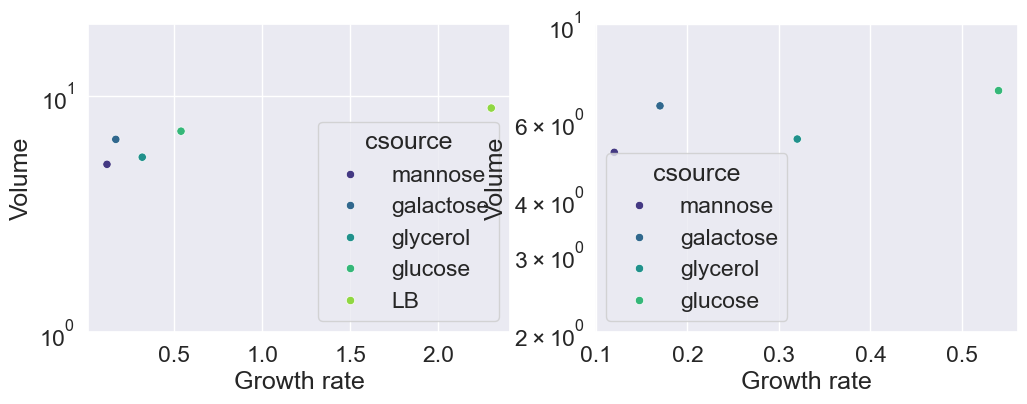

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.scatterplot(df_volume, x='mu', y='mean_volume', hue='csource', palette=palette_csource_d, ax=ax[0])
ax[0].set_xlabel('Growth rate')
ax[0].set_ylim(1, 20)
ax[0].set_ylabel('Volume')
ax[0].set_yscale('log')

sns.scatterplot(df_volume.query('csource != "LB"'), x='mu', y='mean_volume', hue='csource', palette=palette_csource_d_noLB, ax=ax[1])
ax[1].set_xlabel('Growth rate')
ax[1].set_ylim(2, 10)
ax[1].set_ylabel('Volume')
ax[1].set_yscale('log')


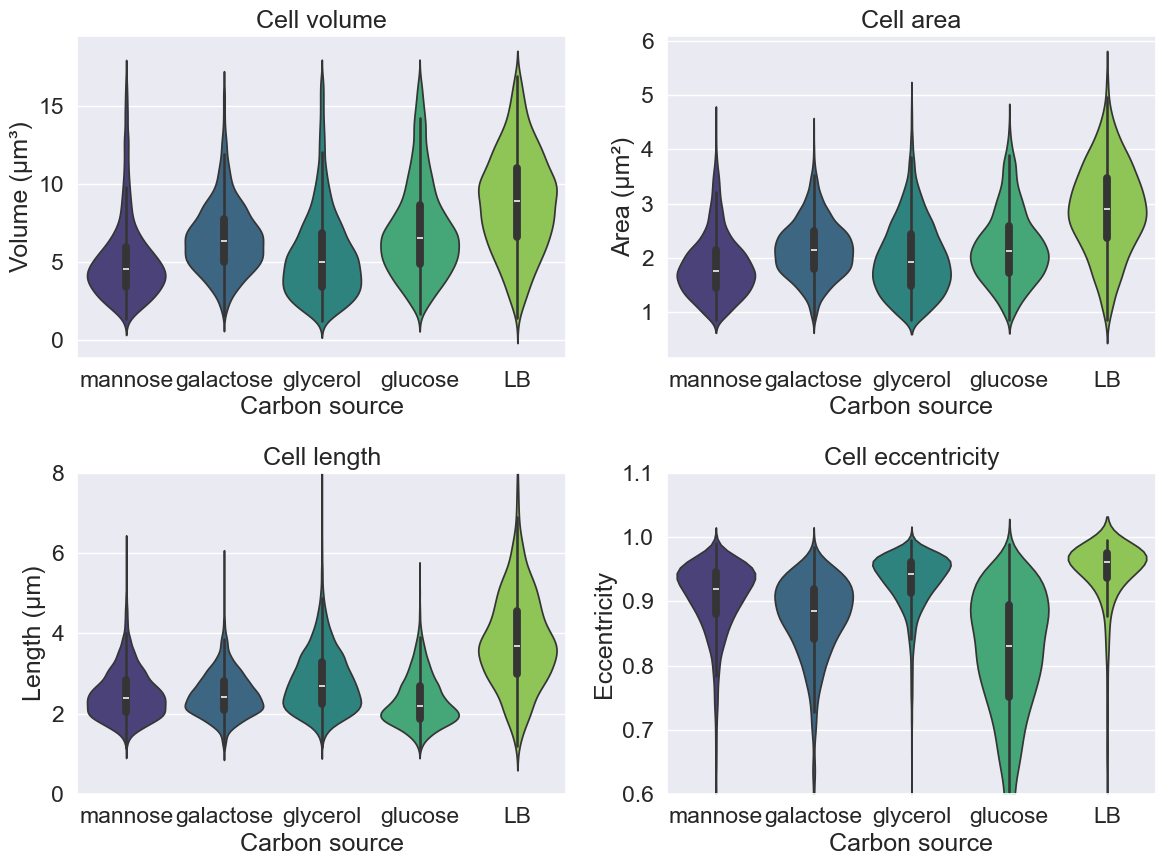

In [41]:
data = df_records.query('volume < 16.9')
fig, ax = plt.subplots(2, 2, figsize=(12, 9))

sns.violinplot(data, x='csource_d', y='volume', order=csources_ordered_d, log_scale=False, hue='csource_d', palette=palette_csource_d, ax=ax[0][0])
ax[0][0].set_title('Cell volume')
ax[0][0].set_xlabel('Carbon source')
ax[0][0].set_ylabel('Volume (µm³)')
# ax[0][0].set(ylim=(0, 2e4))

sns.violinplot(data, x='csource_d', y='area', order=csources_ordered_d, log_scale=False, hue='csource_d', palette=palette_csource_d, ax=ax[0][1])
ax[0][1].set_title('Cell area')
ax[0][1].set_xlabel('Carbon source')
ax[0][1].set_ylabel('Area (µm²)')
# ax[0][1].set(ylim=(0, 1500))

sns.violinplot(data, x='csource_d', y='axis_major_length', order=csources_ordered_d, log_scale=False, hue='csource_d', palette=palette_csource_d, ax=ax[1][0])
ax[1][0].set_title('Cell length')
ax[1][0].set_xlabel('Carbon source')
ax[1][0].set_ylabel('Length (µm)')
ax[1][0].set(ylim=(0, 8))

sns.violinplot(data, x='csource_d', y='eccentricity', order=csources_ordered_d, log_scale=False, hue='csource_d', palette=palette_csource_d, ax=ax[1][1])
ax[1][1].set_title('Cell eccentricity')
ax[1][1].set_xlabel('Carbon source')
ax[1][1].set_ylabel('Eccentricity')
ax[1][1].set_ylim(0.6, 1.1)

plt.tight_layout();

savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/area_eccentricity_vs_condition-exp16+22+24"
plt.savefig(savestem + ".pdf")

##### exp22

In [42]:
volumes = []
for csource in csources_ordered_d:
    # removing the one outlier with volume > 1e6 which is out of whack
    data = df_records.query('volume < 17').query('replicate == "exp22"').query('csource_d == @csource')
    volumes.append({'csource': csource, 'mean_volume': data.volume.mean(), 'mu': data.mu.mean()})
df_volume = pd.DataFrame(volumes)
df_volume

csource  mean_volume    mu
0    mannose         4.63  0.12
1  galactose         6.53  0.17
2   glycerol         6.61  0.32
3    glucose        10.11  0.54
4         LB         8.85  2.30

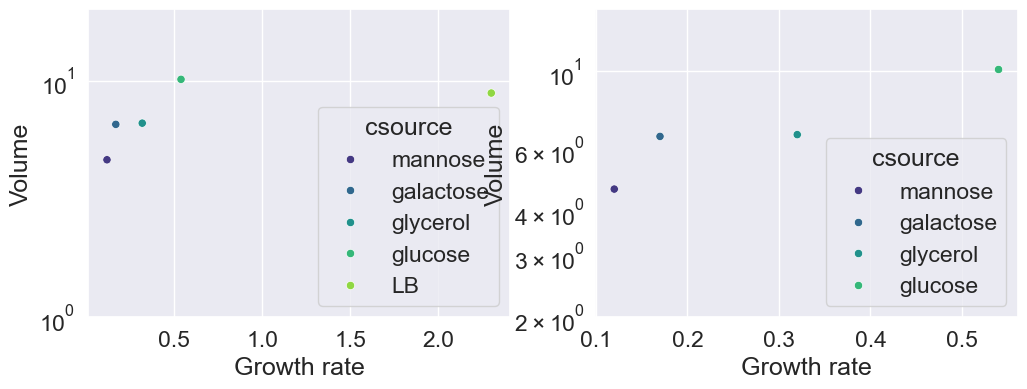

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.scatterplot(df_volume, x='mu', y='mean_volume', hue='csource', palette=palette_csource_d, ax=ax[0])
ax[0].set_xlabel('Growth rate')
ax[0].set_ylim(1, 20)
ax[0].set_ylabel('Volume')
ax[0].set_yscale('log')

sns.scatterplot(df_volume.query('csource != "LB"'), x='mu', y='mean_volume', hue='csource', palette=palette_csource_d_noLB, ax=ax[1])
ax[1].set_xlabel('Growth rate')
ax[1].set_ylim(2, 15)
ax[1].set_ylabel('Volume')
ax[1].set_yscale('log')


In [44]:
sns.set_context("paper")
# # adjust plotting settings
# font = {'family' : 'Arial',
#         'weight' : 'normal',
#         'size'   : 72}
#
# matplotlib.rc('font', **font)

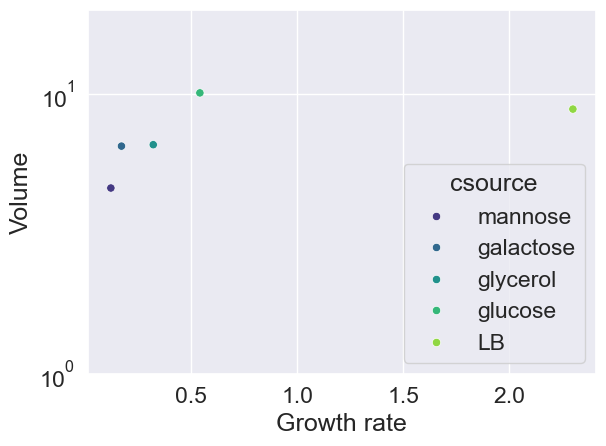

In [45]:
sns.set(font_scale=1.5)
sns.scatterplot(df_volume, x='mu', y='mean_volume', hue='csource', palette=palette_csource_d)
plt.xlabel('Growth rate')
plt.ylim(1, 20)
plt.ylabel('Volume')
plt.yscale('log')
plt.tight_layout();

savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/volume_vs_mu-exp22"
plt.savefig(savestem + ".pdf")

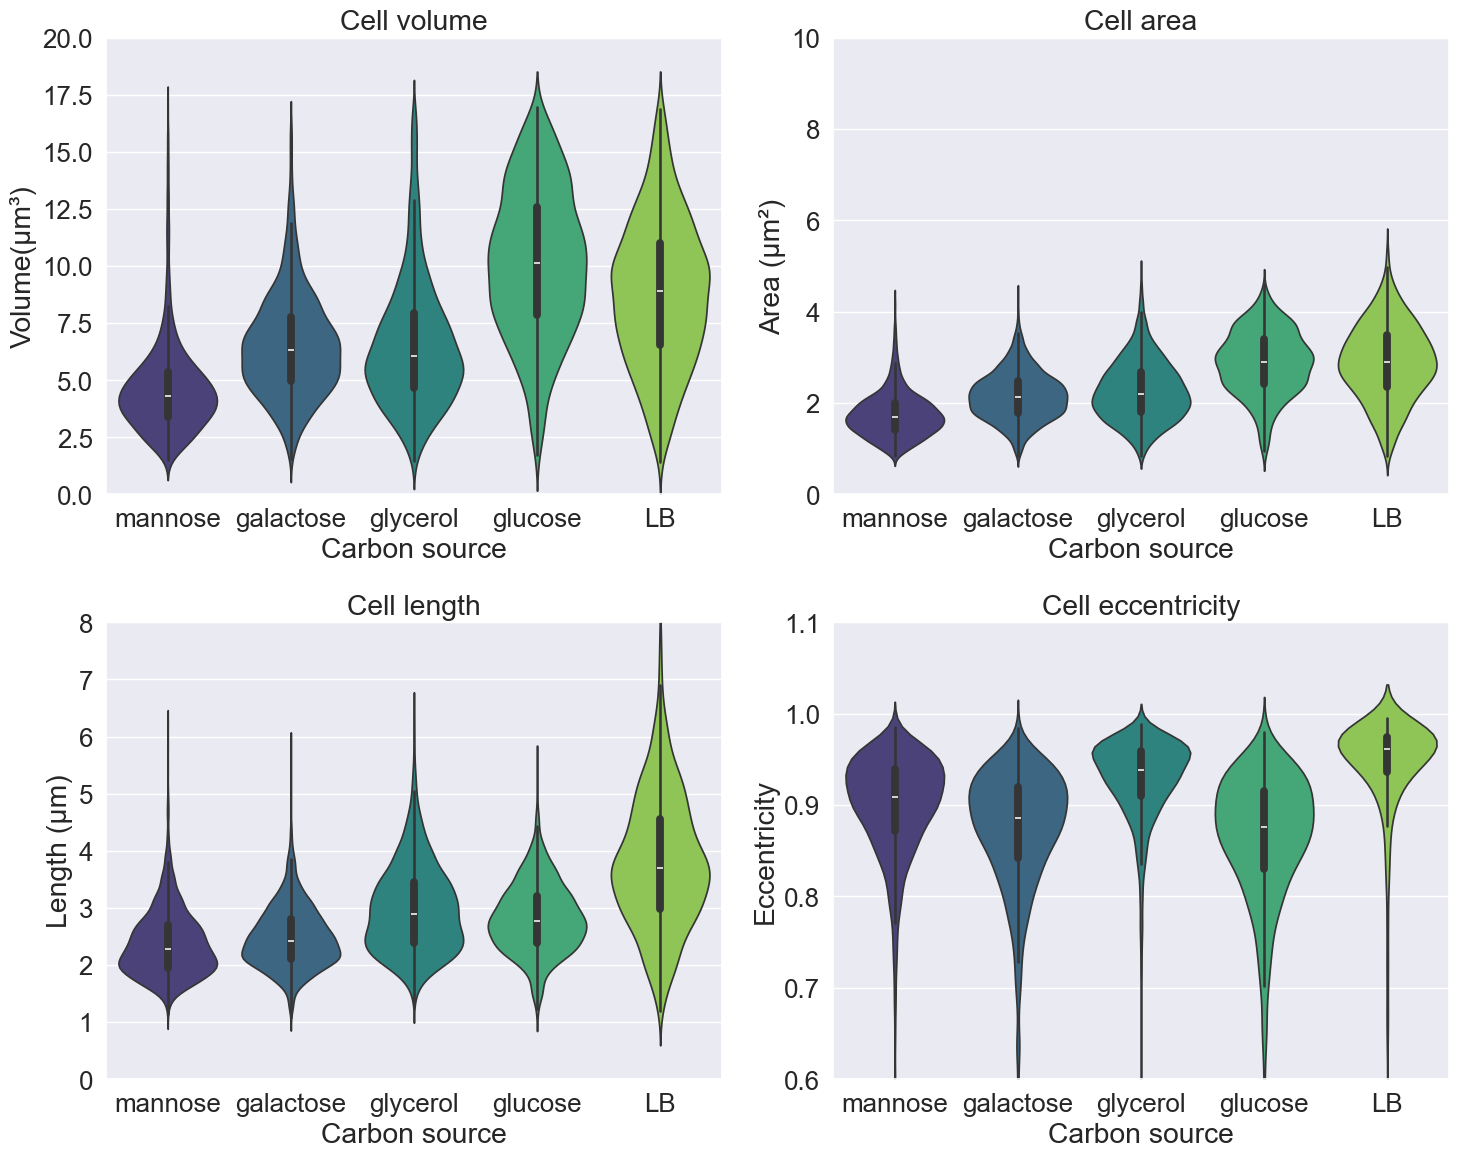

In [46]:
sns.set(font_scale=1.7)
data = df_records.query('replicate == "exp22"').query('volume < 17')
fig, ax = plt.subplots(2, 2, figsize=(15, 12))

sns.violinplot(data, x='csource_d', y='volume', order=csources_ordered_d, log_scale=False, hue='csource_d', palette=palette_csource_d, ax=ax[0][0])
ax[0][0].set_title('Cell volume')
ax[0][0].set_xlabel('Carbon source')
ax[0][0].set_ylabel('Volume(µm³)')
ax[0][0].set(ylim=(0, 20))

sns.violinplot(data, x='csource_d', y='area', order=csources_ordered_d, log_scale=False, hue='csource_d', palette=palette_csource_d, ax=ax[0][1])
ax[0][1].set_title('Cell area')
ax[0][1].set_xlabel('Carbon source')
ax[0][1].set_ylabel('Area (µm²)')
ax[0][1].set(ylim=(0, 10))

sns.violinplot(data, x='csource_d', y='axis_major_length', order=csources_ordered_d, log_scale=False, hue='csource_d', palette=palette_csource_d, ax=ax[1][0])
ax[1][0].set_title('Cell length')
ax[1][0].set_xlabel('Carbon source')
ax[1][0].set_ylabel('Length (µm)')
ax[1][0].set(ylim=(0, 8))

sns.violinplot(data, x='csource_d', y='eccentricity', order=csources_ordered_d, log_scale=False, hue='csource_d', palette=palette_csource_d, ax=ax[1][1])
ax[1][1].set_title('Cell eccentricity')
ax[1][1].set_xlabel('Carbon source')
ax[1][1].set_ylabel('Eccentricity')
ax[1][1].set_ylim(0.6, 1.1)

plt.tight_layout();

savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/area_eccentricity_vs_condition-exp22"
plt.savefig(savestem + ".pdf")
plt.savefig(savestem + ".png")

In [47]:
data = df_records
areas = data.groupby(['strain', 'csource', 'replicate'])['area'].agg(['mean', 'median', 'std']).reset_index()
volumes = data.groupby(['strain', 'csource', 'replicate'])['volume'].agg(['mean', 'median', 'std']).reset_index()
mus = pd.DataFrame(data.groupby(['strain', 'csource', 'replicate'])['mu'].agg('mean')).reset_index()
df = areas.merge(volumes, on=['strain', 'csource', 'replicate'], suffixes=('_area', '_volume')).merge(mus, on=['strain', 'csource', 'replicate'])
df

strain csource replicate  mean_area  median_area  std_area  mean_volume  \
0  MG1655     GAL     exp22       2.19         2.15      0.59         6.75   
1  MG1655     GLU     exp16       2.02         1.99      0.54         6.40   
2  MG1655     GLU     exp22       3.02         2.97      0.96        10.86   
3  MG1655     GLU     exp24       1.92         1.88      0.53         5.35   
4  MG1655     GLY     exp16       1.54         1.39      0.61         4.05   
5  MG1655     GLY     exp22       2.47         2.28      1.04         8.62   
6  MG1655     GLY     exp24       1.82         1.67      0.90         8.85   
7  MG1655      LB     exp22       3.17         3.01      1.25        11.77   
8  MG1655     MAN     exp16       2.18         1.95      1.12         7.38   
9  MG1655     MAN     exp22       1.80         1.69      0.75         5.25   

   median_volume  std_volume    mu  
0           6.34        3.20  0.17  
1           6.18        2.51  0.54  
2          10.42        4.91  0.54  
3           5.07        2.46  0.54  
4           3.07        3.67  0.32  
5           6.33        9.58  0.32  
6           3.94      162.61  0.32  
7           9.36       23.22  2.30  
8           5.21        9.93  0.12  
9           4.34        9.10  0.12

In [48]:
df_records.groupby(['strain', 'csource', 'replicate', 'seqnr'])['area'].mean()

strain  csource  replicate  seqnr
MG1655  GAL      exp22      03       2.22
                            04       2.14
                            07       2.15
                            08       2.17
        GLU      exp16      02       1.77
                            03       2.01
                            04       2.13
                            05       2.20
                 exp22      01       2.90
                            02       2.91
                            04       2.40
                            05       2.91
                            06       3.01
                            07       3.00
                            08       3.25
                            09       3.31
                            10       3.13
                 exp24      01       1.86
                            03       2.00
                            05       1.94
        GLY      exp16      01       2.05
                            03       1.80
                            06       1.60


#### Inspect suspicious area values
-> to improve segmentation later

In [49]:
df_records.query('replicate == "exp16"').query('csource == "MAN"').sort_values(by='area', ascending=False)[['experiment', 'image', 'image_cell_id', 'area', 'volume', 'bbox-1', 'bbox-2']]

experiment                      image  image_cell_id   area  volume  \
131  20240927-exp16  MG1655_MAN_OD_0.3_left_02            414  17.19  259.68   
210  20240927-exp16  MG1655_MAN_OD_0.3_left_02            642  11.37   92.05   
240  20240927-exp16  MG1655_MAN_OD_0.3_left_02            699   9.62   67.53   
307  20240927-exp16  MG1655_MAN_OD_0.3_left_02            905   8.84   71.06   
52   20240927-exp16  MG1655_MAN_OD_0.3_left_05            536   8.70   67.85   
..              ...                        ...            ...    ...     ...   
98   20240927-exp16  MG1655_MAN_OD_0.3_left_09            565   0.86    1.79   
69   20240927-exp16  MG1655_MAN_OD_0.3_left_07            514   0.86    1.73   
241  20240927-exp16  MG1655_MAN_OD_0.3_left_09            899   0.85    1.37   
353  20240927-exp16  MG1655_MAN_OD_0.3_left_09           1165   0.85    1.50   
299  20240927-exp16  MG1655_MAN_OD_0.3_left_09           1040   0.85    1.34   

     bbox-1  bbox-2  
131    1763    1074  
210     618    1585  
240    2220    1674  
307    1976    2191  
52      813     483  
..      ...     ...  
98     1687     364  
69      584     497  
241     562     904  
353    1175    1305  
299     188    1115  

[1638 rows x 7 columns]

In [50]:
df_records.groupby(['strain', 'csource', 'replicate'])['area'].mean()

strain  csource  replicate
MG1655  GAL      exp22        2.19
        GLU      exp16        2.02
                 exp22        3.02
                 exp24        1.92
        GLY      exp16        1.54
                 exp22        2.47
                 exp24        1.82
        LB       exp22        3.17
        MAN      exp16        2.18
                 exp22        1.80
Name: area, dtype: float64

In [51]:
df_records.groupby(['strain', 'csource'])['area'].mean()

strain  csource
MG1655  GAL        2.19
        GLU        2.27
        GLY        2.15
        LB         3.17
        MAN        1.98
Name: area, dtype: float64

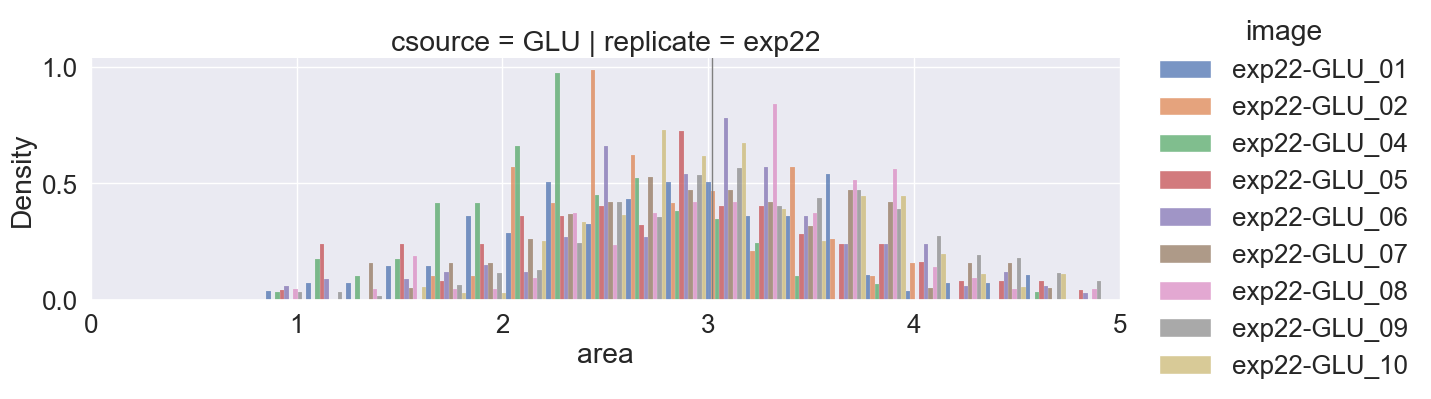

In [52]:
thisdata =  df_records.query("csource in ['GLU']").query("replicate == 'exp22'").query("area < 2500")

g = sns.displot(
    data=thisdata, x='area', stat='density', common_norm=False,
    row='csource', col='replicate',
    hue='image', multiple="dodge",
    legend=True, height=4, aspect=3,
    facet_kws=dict(sharey=True, sharex=True))
g.set(xlim=(0, 5))

# this is pathetic but it works:
# extract and flatten the axes from the figure
axes = g.axes.flatten()

# iterate through each axes
for ax in axes:
    # extract the species name
    title = ax.get_title()
    csource = re.search('csource = (?P<csource>[A-Z]+)', title).groups()[0]
    replicate = re.search('replicate = (?P<replicate>exp[0-9]+)', title).groups()[0]
    # print(f'title: {title} csource: {csource} replicate: {replicate}')

    data = thisdata.query('csource == @csource').query('replicate == @replicate')
    nr_cells = data.query('csource == @csource').shape[0]

    if data.empty is False:
        mean = data['area'].mean()
        std = data['area'].std()
        mu = data.query('csource == @csource')['mu'].unique()[0]
        ax.axvline(x=mean, c='grey', ls='-', lw=1)
        ax.annotate(f'#cells={nr_cells}\nµ={mu}\nmean area={mean:0.0f}', xy=(1200, 0.0022), xytext=(1200, 0.0022))

# this is the right way to do it but it doesn't work:
# for (row, col, hue_idx), data in g.facet_data():
#     # # Skip empty data
#     if not data.values.size:
#         continue
#
#     # Get the ax for `row` and `col`
#     # ax = g.facet_axis(row, col)
#
#     print(row, col, hue_idx, data.shape)
#
#     # # Set the `vline`s using the var `x_var`
#     # ax.axvline(data['area'].mean(), c="k", ls="-", lw=2.5)
#     # ax.axvline(data['area'].median(), c="orange", ls="--", lw=2.5)

#### Nucleoids

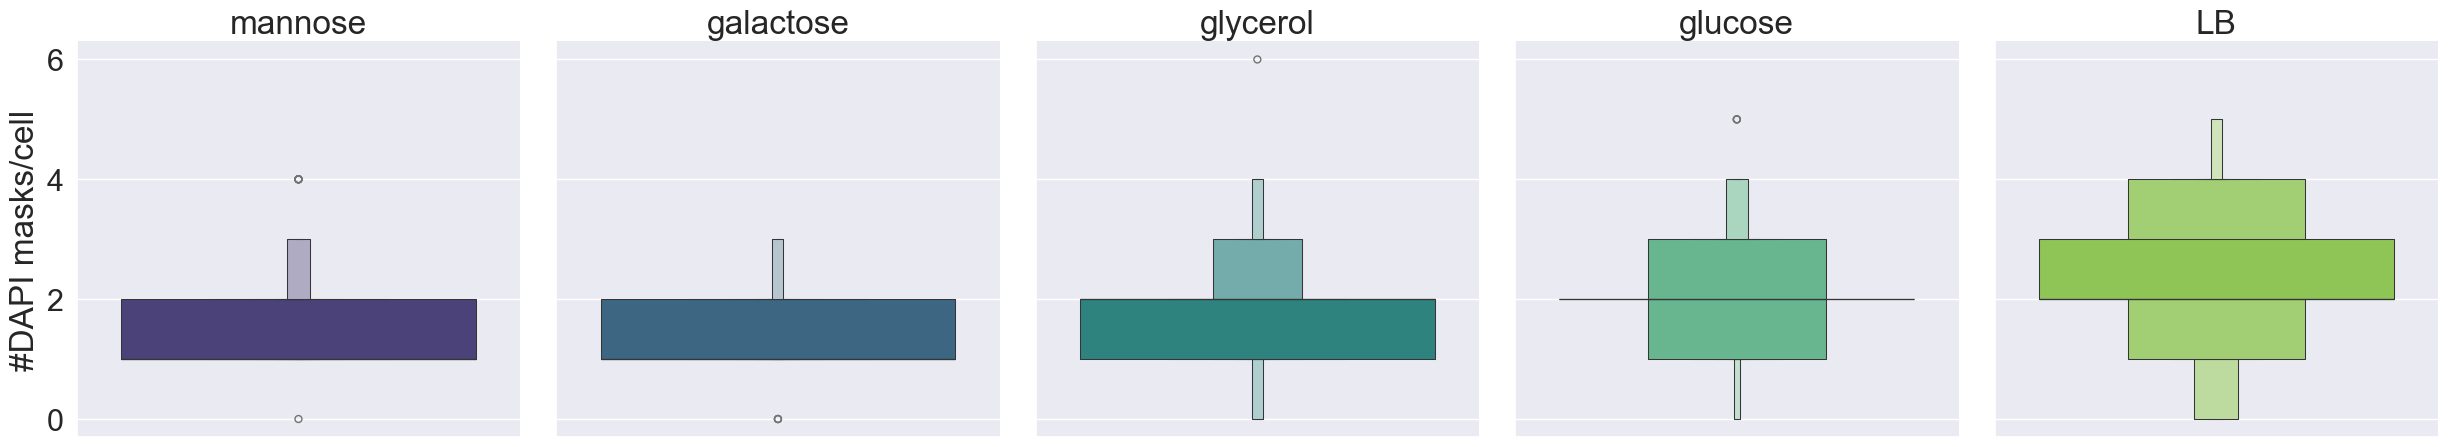

In [53]:
sns.set(font_scale=2)
data = df_records.query('replicate == "exp22"').query('volume < 17')
g = sns.catplot(data, kind='boxen', y='nuclei', col='csource_d', col_order=csources_ordered_d, hue='csource_d', palette=palette_csource_d, legend=False)
g.set_titles('{col_name}')
g.set(ylabel='#DAPI masks/cell')
plt.tight_layout();
savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/nuclei"
plt.savefig(savestem + ".pdf")
plt.savefig(savestem + ".png", dpi=600)

#### Area per condition

##### Demo plot

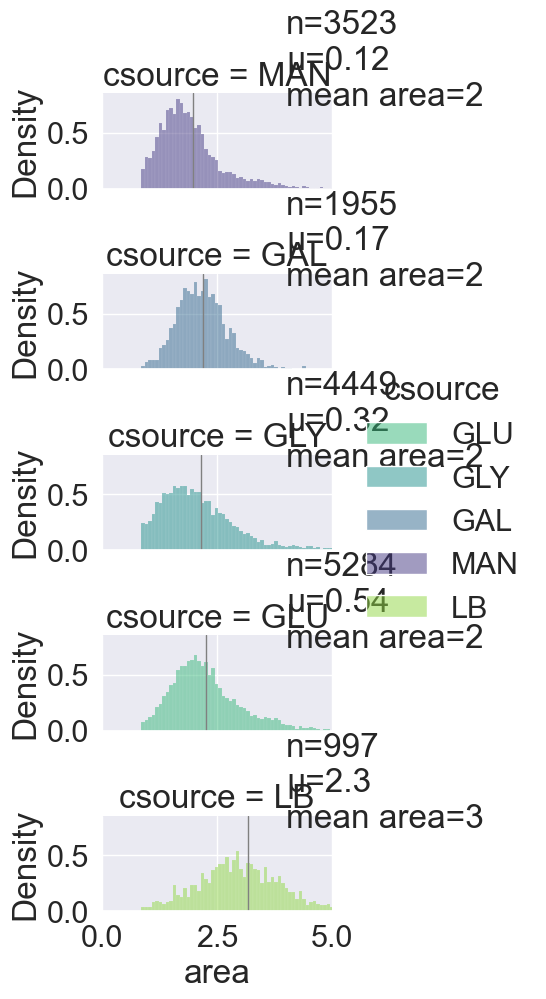

In [54]:
data = df_records
g = sns.displot(
    data=data, x='area', stat='density', common_norm=False,
    row='csource', row_order=csources_ordered, 
    hue='csource', palette=palette_csource, 
    legend=True, height=2, aspect=2,
    facet_kws=dict(sharey=True, sharex=True))
g.set(xlim=(0, 5))

axes = g.axes.flatten()
for ax in axes:
    title = ax.get_title()
    csource = re.search('csource = (?P<csource>[A-Z]+)', title).groups()[0]
    mean = data.query('csource == @csource')['area'].mean()
    std = data.query('csource == @csource')['area'].std()
    mu = data.query('csource == @csource')['mu'].unique()[0]
    nr_cells = data.query('csource == @csource').shape[0]
    
    if data.empty is False: 
        ax.axvline(x=mean, c='grey', ls='-', lw=1)
        ax.annotate(f'n={nr_cells}\nµ={mu}\nmean area={mean:0.0f}', xy=(4, 0.75), xytext=(4, 0.75))

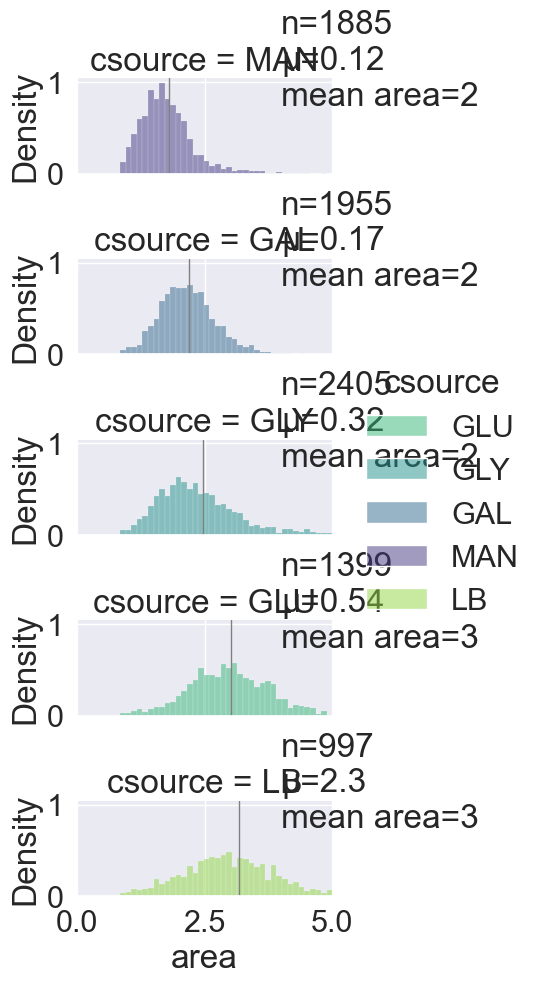

In [55]:
data = df_records.query('replicate == "exp22"')
g = sns.displot(
    data=data, x='area', stat='density', common_norm=False,
    row='csource', row_order=csources_ordered, 
    hue='csource', palette=palette_csource, 
    legend=True, height=2, aspect=2,
    facet_kws=dict(sharey=True, sharex=True))
g.set(xlim=(0, 5))

axes = g.axes.flatten()
for ax in axes:
    title = ax.get_title()
    csource = re.search('csource = (?P<csource>[A-Z]+)', title).groups()[0]
    mean = data.query('csource == @csource')['area'].mean()
    std = data.query('csource == @csource')['area'].std()
    mu = data.query('csource == @csource')['mu'].unique()[0]
    nr_cells = data.query('csource == @csource').shape[0]
    
    if data.empty is False: 
        ax.axvline(x=mean, c='grey', ls='-', lw=1)
        ax.annotate(f'n={nr_cells}\nµ={mu}\nmean area={mean:0.0f}', xy=(4, 0.77), xytext=(4, 0.75))

#### Eccentricity per condition

##### Demo plot

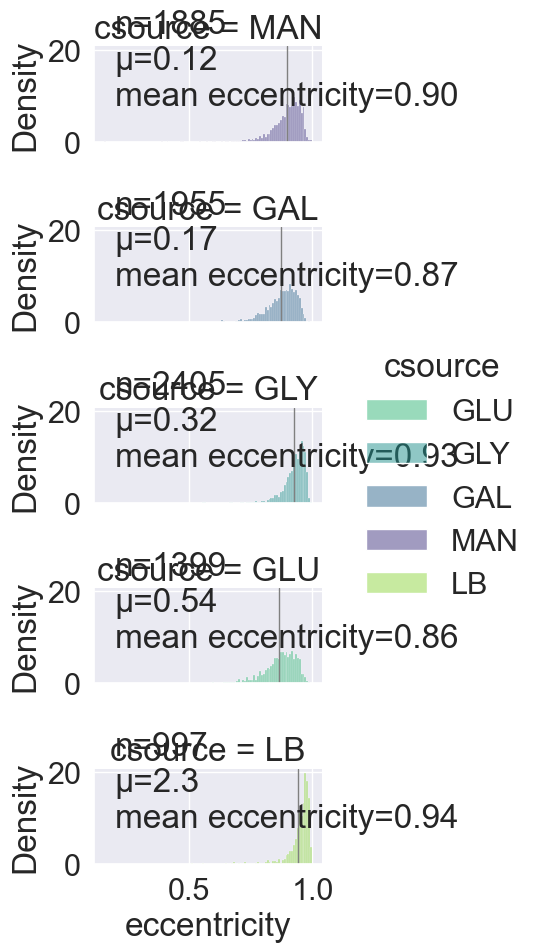

In [56]:
data = df_records.query('replicate == "exp22"')
g = sns.displot(
    data=data, x='eccentricity', stat='density', common_norm=False,
    row='csource', row_order=csources_ordered, 
    hue='csource', palette=palette_csource, 
    legend=True, height=2, aspect=2,
    facet_kws=dict(sharey=True, sharex=True))

axes = g.axes.flatten()
for ax in axes:
    # extract the species name
    title = ax.get_title()
    csource = re.search('csource = (?P<csource>[A-Z]+)', title).groups()[0]

    mean = data.query('csource == @csource')['eccentricity'].mean()
    std = data.query('csource == @csource')['eccentricity'].std()
    mu = data.query('csource == @csource')['mu'].unique()[0]
    nr_cells = data.query('csource == @csource').shape[0]

    if data.empty is False: 
        ax.axvline(x=mean, c='grey', ls='-', lw=1)
        ax.annotate(f'n={nr_cells}\nµ={mu}\nmean eccentricity={mean:0.2f}', xy=(0.2, 8), xytext=(0.2, 8))

### Expression versus growth rate

#### Mean expression per condition


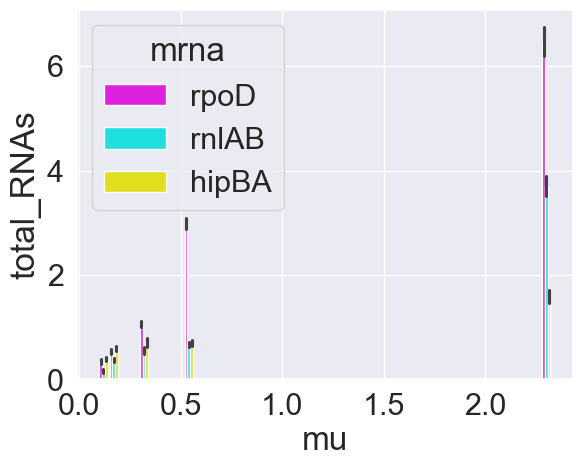

In [57]:
data = df_stacked.query('replicate == "exp22"')
sns.barplot(data, x='mu', y='total_RNAs', native_scale=True, hue='mrna', hue_order=mrna_ordered, palette=palette_mrna);

12/12/2024 02:21:52PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
12/12/2024 02:21:52PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 


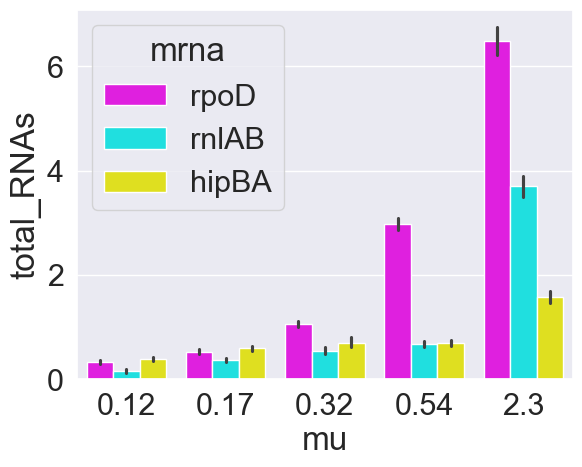

In [58]:
data = df_stacked.query('replicate == "exp22"')
sns.barplot(data, x='mu', y='total_RNAs', native_scale=False, hue='mrna', hue_order=mrna_ordered, palette=palette_mrna);

##### All

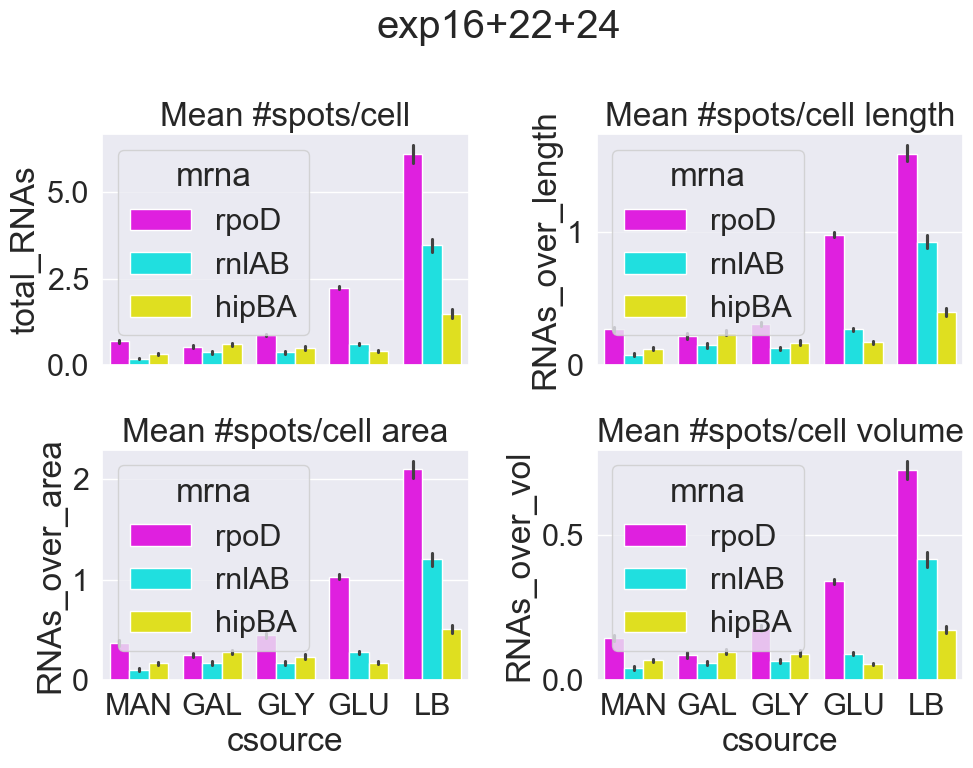

In [59]:
sns.set_style("darkgrid")
data=df_stacked.query('volume < 16.9')

fig, ax = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
g = sns.barplot(data=data, x='csource', order=csources_ordered, y='total_RNAs',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0][0])
g.set(title='Mean #spots/cell')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_length',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0][1])
g.set(title='Mean #spots/cell length')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_area',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1][0])
g.set(title='Mean #spots/cell area')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_vol',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1][1])
g.set(title='Mean #spots/cell volume');

fig.suptitle("exp16+22+24")
plt.tight_layout()


savestem = ("/Users/adele/Master/Projects/persisters/fig/analysis/mean_expression_vs_condition_exp16+22+24")
plt.savefig(savestem + ".pdf")
# ? expected #mRNAs and proteins /cell
# expectation: rpoD is growth dependent, TA systems are not
# normalize by nr copies of genome and distance from oriC


##### exp22

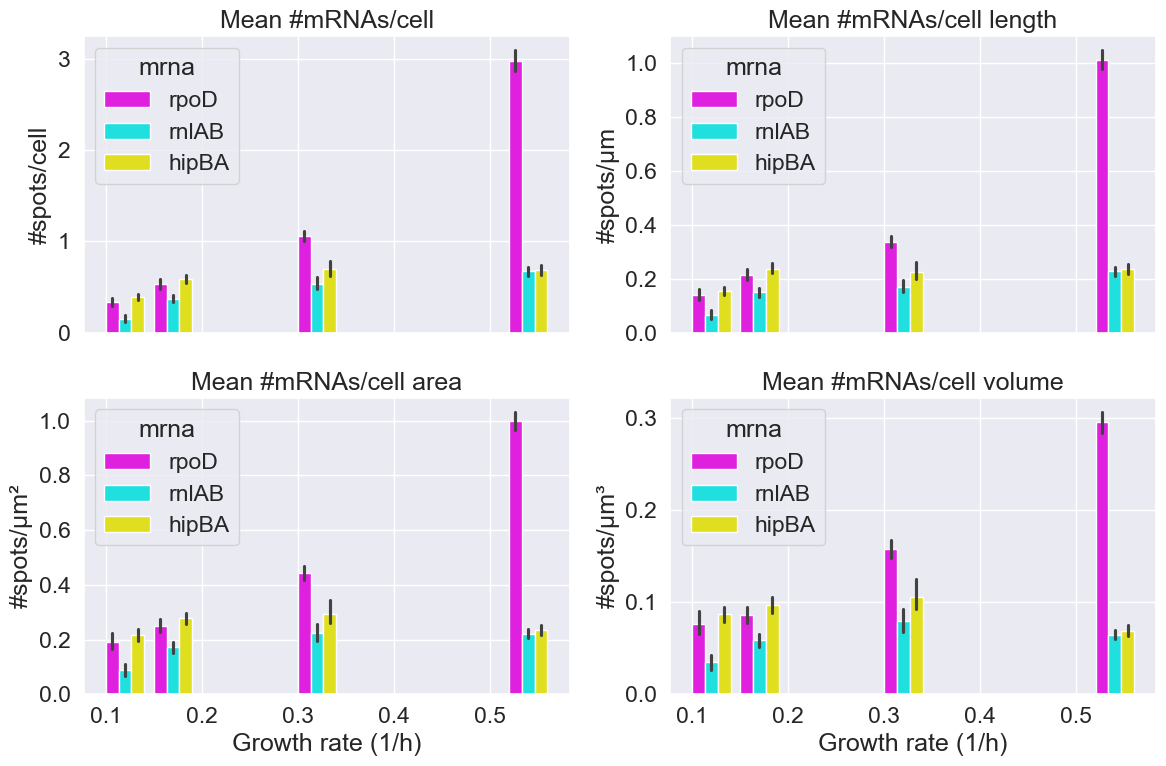

In [60]:
sns.set_style("darkgrid")
sns.set(font_scale=1.5)
data=df_stacked.query("replicate == 'exp22'").query('csource != "LB"')

fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
g = sns.barplot(data=data, x='mu', native_scale=True, y='total_RNAs',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0][0])
g.set(title='Mean #mRNAs/cell')
g.set(xlabel='Growth rate (1/h)', ylabel='#spots/cell')

g = sns.barplot(data=data, x='mu', native_scale=True, y='RNAs_over_length',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0][1])
g.set(title='Mean #mRNAs/cell length')
g.set(xlabel='Growth rate (1/h)', ylabel='#spots/µm')

g = sns.barplot(data=data, x='mu', native_scale=True, y='RNAs_over_area',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1][0])
g.set(title='Mean #mRNAs/cell area')
g.set(xlabel='Growth rate (1/h)', ylabel='#spots/µm²')

g = sns.barplot(data=data, x='mu', native_scale=True, y='RNAs_over_vol',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1][1])
g.set(title='Mean #mRNAs/cell volume');
g.set(xlabel='Growth rate (1/h)', ylabel='#spots/µm³')

# fig.suptitle("exp22")
plt.tight_layout()


savestem = ("/Users/adele/Master/Projects/persisters/fig/analysis/mean_expression_vs_condition_exp22")
plt.savefig(savestem + ".pdf")
plt.savefig(savestem + ".png", dpi=600)



#### Normalization


##### Genome copy number depends on growth rate


In [61]:
# at generation times > 60 minutes, we only have one copy of the genome
# in LB, tau = 20 minutes, so we should something between 4 and 8 DNA copies
# it depends on C period (OK) and D period (which I don't know how to compute)
# I used the values from the Bremer article
Gc = { 'LB': 4.0, 'GLU': 1.8, 'GLY': 1, 'GAL': 1, 'MAN': 1}
df_stacked['DNA_copy_number'] = df_stacked['csource'].apply(lambda x: Gc[x])
df_stacked['DNA_copy_number'].value_counts()


DNA_copy_number
1.0    29781
1.8    15852
4.0     2991
Name: count, dtype: int64

In [62]:
df_stacked['mu'].unique(), df_stacked['tau (h)'].unique(), df_stacked['tau (min)'].unique()

(array([0.54, 0.32, 0.17, 0.12, 2.3 ]),
 array([1.28360589, 2.16608494, 4.07733636, 5.7762265 , 0.30136834]),
 array([ 77.0163534 , 129.96509635, 244.64018137, 346.57359028,
         18.08210036]))

In [63]:
df_stacked['total_RNAs_normalized1'] = df_stacked['total_RNAs'] / df_stacked['DNA_copy_number']
df_stacked['RNAs_over_length_normalized1'] = df_stacked['RNAs_over_length'] / df_stacked['DNA_copy_number']
df_stacked['RNAs_over_area_normalized1'] = df_stacked['RNAs_over_area'] / df_stacked['DNA_copy_number']
df_stacked['RNAs_over_vol_normalized1'] = df_stacked['RNAs_over_vol'] / df_stacked['DNA_copy_number']

##### Gene copy number depends on genome copy number and distance of gene from oriC

In [64]:
gene_map_locations = { 'rpoD': 69.21, 'rnlAB': 59.59, 'hipBA': 34.3}
# rpoD is closest from oriC, then rnlAB, then hipBA
# hipBA is right opposite oriC, so mprime is max (value of 1)
# mprime = 0 => max expression (from start of replication because distance is minimal)
# mprime = 1 => min expression
# mprime = { 'rpoD': 0.3, 'rnlAB': 0.48, 'hipBA': 1}
C = { 'LB': 33, 'GLU': 62 }
D = { 'LB': 22, 'GLU': 28 }


def number_of_gene_per_cell(csource, mrna, tau):
    if csource == 'GLY' or csource == 'GAL' or csource == 'MAN':
        return 1

    elif csource == 'LB' or csource == 'GLU':
        # oriC_loc = 84.57
        m = gene_map_locations[mrna]
        if m <= 36:
            # hipBA
            mprime = (m + 16) / 50
        elif m <= 84:
            # rpoD and rnlAB
            mprime = (84 - m) / 50
        else:
            mprime = (m - 84) / 50

        exponent = (C[csource] * (1 - mprime) + D[csource]) / tau
        Xc = pow(2, exponent)
        return Xc


df_stacked['gene_copy_number'] = df_stacked.apply(lambda r: number_of_gene_per_cell(r['csource'], r['mrna'], r['tau (min)']), axis=1)
df_stacked[['csource', 'mrna', 'gene_copy_number']].value_counts()

csource  mrna   gene_copy_number
GLU      hipBA  1.28                5284
         rnlAB  1.71                5284
         rpoD   1.91                5284
GLY      hipBA  1.00                4449
         rnlAB  1.00                4449
         rpoD   1.00                4449
MAN      hipBA  1.00                3523
         rnlAB  1.00                3523
         rpoD   1.00                3523
GAL      hipBA  1.00                1955
         rnlAB  1.00                1955
         rpoD   1.00                1955
LB       hipBA  2.31                 997
         rnlAB  4.44                 997
         rpoD   5.66                 997
Name: count, dtype: int64

In [65]:
gene_copy_number = df_stacked.query('replicate == "exp22"').groupby(['strain', 'csource', 'mrna', 'mu'])['gene_copy_number'].mean().reset_index()
gene_copy_number['tau (h)'] = np.log(2) / gene_copy_number['mu']
gene_copy_number['tau (min)'] = 60 * gene_copy_number['tau (h)']
gene_copy_number

strain csource   mrna    mu  gene_copy_number  tau (h)  tau (min)
0   MG1655     GAL  hipBA  0.17              1.00     4.08     244.64
1   MG1655     GAL  rnlAB  0.17              1.00     4.08     244.64
2   MG1655     GAL   rpoD  0.17              1.00     4.08     244.64
3   MG1655     GLU  hipBA  0.54              1.28     1.28      77.02
4   MG1655     GLU  rnlAB  0.54              1.71     1.28      77.02
5   MG1655     GLU   rpoD  0.54              1.91     1.28      77.02
6   MG1655     GLY  hipBA  0.32              1.00     2.17     129.97
7   MG1655     GLY  rnlAB  0.32              1.00     2.17     129.97
8   MG1655     GLY   rpoD  0.32              1.00     2.17     129.97
9   MG1655      LB  hipBA  2.30              2.31     0.30      18.08
10  MG1655      LB  rnlAB  2.30              4.44     0.30      18.08
11  MG1655      LB   rpoD  2.30              5.66     0.30      18.08
12  MG1655     MAN  hipBA  0.12              1.00     5.78     346.57
13  MG1655     MAN  rnlAB  0.12              1.00     5.78     346.57
14  MG1655     MAN   rpoD  0.12              1.00     5.78     346.57

12/12/2024 02:21:59PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
12/12/2024 02:21:59PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 


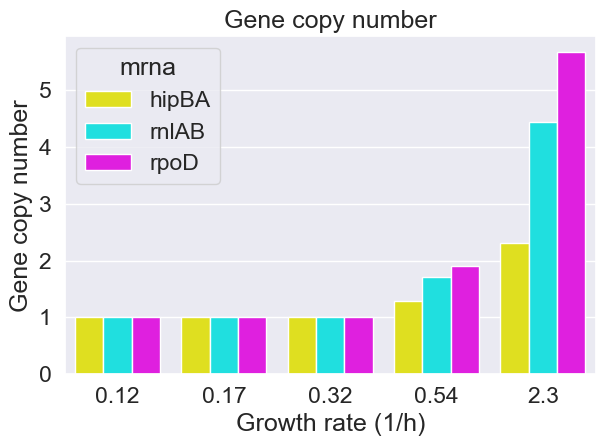

In [66]:
sns.set(font_scale=1.5)
sns.barplot(data=gene_copy_number, x='mu', y='gene_copy_number', native_scale=False, hue='mrna', palette=palette_mrna).set_title('Gene copy number')
plt.xlabel('Growth rate (1/h)')
plt.ylabel('Gene copy number')
plt.tight_layout();


savestem = ("/Users/adele/Master/Projects/persisters/fig/analysis/gene_copy_number")
plt.savefig(savestem + ".pdf")

In [67]:
df_stacked['total_RNAs_normalized2'] = df_stacked['total_RNAs']  / df_stacked['gene_copy_number']
df_stacked['RNAs_over_length_normalized2'] = df_stacked['RNAs_over_length'] / df_stacked['gene_copy_number']
df_stacked['RNAs_over_area_normalized2'] = df_stacked['RNAs_over_area'] / df_stacked['gene_copy_number']
df_stacked['RNAs_over_vol_normalized2'] = df_stacked['RNAs_over_vol'] / df_stacked['gene_copy_number']

In [68]:
df_stacked.columns

Index(['image_cell_id', 'spots', 'dense_regions', 'decomposed_RNAs', 'tx',
       'nascent_RNAs', 'total_RNAs', 'mrna', 'strain', 'condition', 'seqnr',
       'image', 'experiment', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'area',
       'eccentricity', 'axis_minor_length', 'axis_major_length', 'orientation',
       'perimeter', 'solidity', 'bbox-0_expanded', 'bbox-1_expanded',
       'bbox-2_expanded', 'bbox-3_expanded', 'area_expanded',
       'eccentricity_expanded', 'axis_minor_length_expanded',
       'axis_major_length_expanded', 'orientation_expanded',
       'perimeter_expanded', 'solidity_expanded', 'nuclei', 'csource',
       'coverslip', 'replicate', 'unique_cell_id', 'selected', 'volume',
       'volume_ellipsoid', 'RNAs_over_area', 'RNAs_over_vol',
       'RNAs_over_length', 'RNAs_over_eccentricity', 'mu', 'tau (h)',
       'tau (min)', 'csource_d', 'DNA_copy_number', 'total_RNAs_normalized1',
       'RNAs_over_length_normalized1', 'RNAs_over_area_normalized1',
       'RNAs

##### All

###### Unnormalized

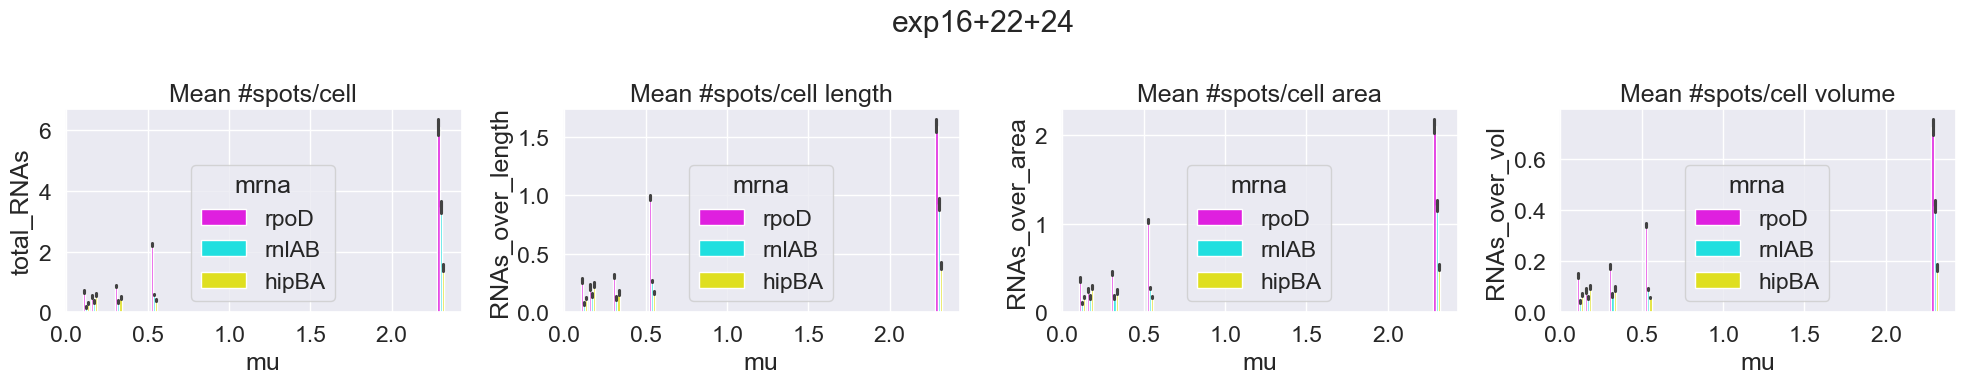

In [69]:
sns.set_style("darkgrid")
data=df_stacked.query('volume < 16.9')

fig, ax = plt.subplots(1, 4, figsize=(20, 4), sharex=True)
g = sns.barplot(data=data, x='mu', native_scale=True, y='total_RNAs',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0])
g.set(title='Mean #spots/cell')

g = sns.barplot(data=data, x='mu', native_scale=True, y='RNAs_over_length',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1])
g.set(title='Mean #spots/cell length')

g = sns.barplot(data=data, x='mu', native_scale=True, y='RNAs_over_area',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[2])
g.set(title='Mean #spots/cell area')

g = sns.barplot(data=data, x='mu', native_scale=True, y='RNAs_over_vol',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[3])
g.set(title='Mean #spots/cell volume');

fig.suptitle("exp16+22+24")
plt.tight_layout()


savestem = ("/Users/adele/Master/Projects/persisters/fig/analysis/mean_expression_vs_condition_exp16+22+24")
plt.savefig(savestem + ".pdf")



12/12/2024 02:22:04PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
12/12/2024 02:22:04PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
12/12/2024 02:22:05PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
12/12/2024 02:22:05PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
12/12/2024 02:22:05PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates.

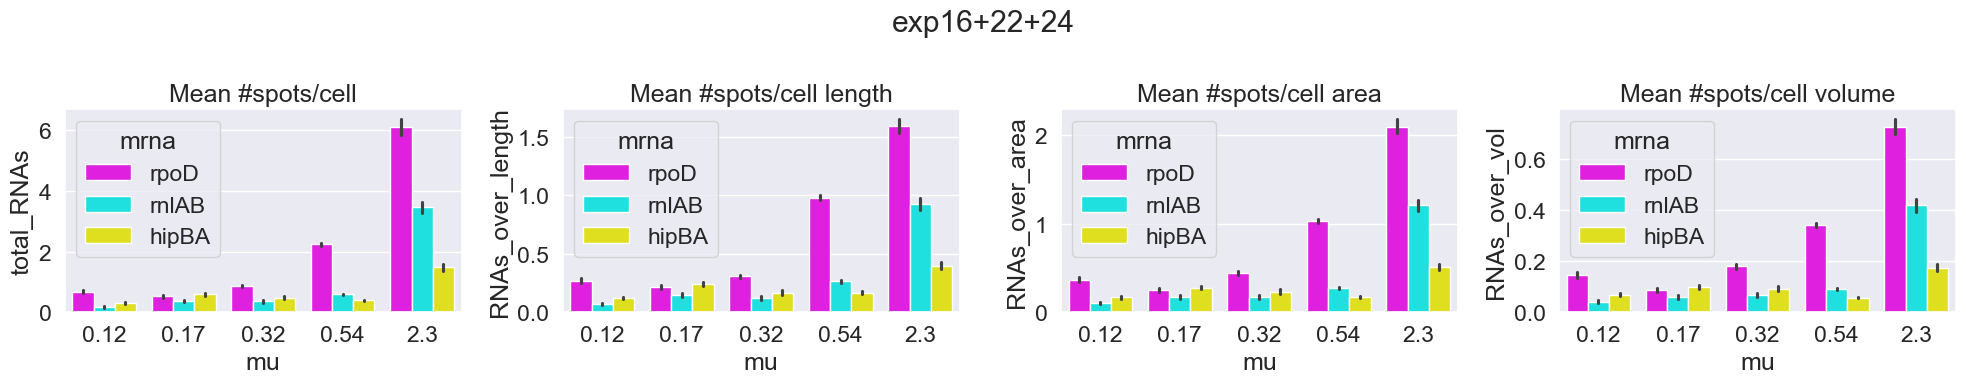

In [70]:
sns.set_style("darkgrid")
data=df_stacked.query('volume < 16.9')

fig, ax = plt.subplots(1, 4, figsize=(20, 4), sharex=True)
g = sns.barplot(data=data, x='mu', native_scale=False, y='total_RNAs',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0])
g.set(title='Mean #spots/cell')

g = sns.barplot(data=data, x='mu', native_scale=False, y='RNAs_over_length',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1])
g.set(title='Mean #spots/cell length')

g = sns.barplot(data=data, x='mu', native_scale=False, y='RNAs_over_area',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[2])
g.set(title='Mean #spots/cell area')

g = sns.barplot(data=data, x='mu', native_scale=False, y='RNAs_over_vol',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[3])
g.set(title='Mean #spots/cell volume');

fig.suptitle("exp16+22+24")
plt.tight_layout()


savestem = ("/Users/adele/Master/Projects/persisters/fig/analysis/mean_expression_vs_condition_exp16+22+24")
plt.savefig(savestem + ".pdf")



###### Normalized by genome copy number

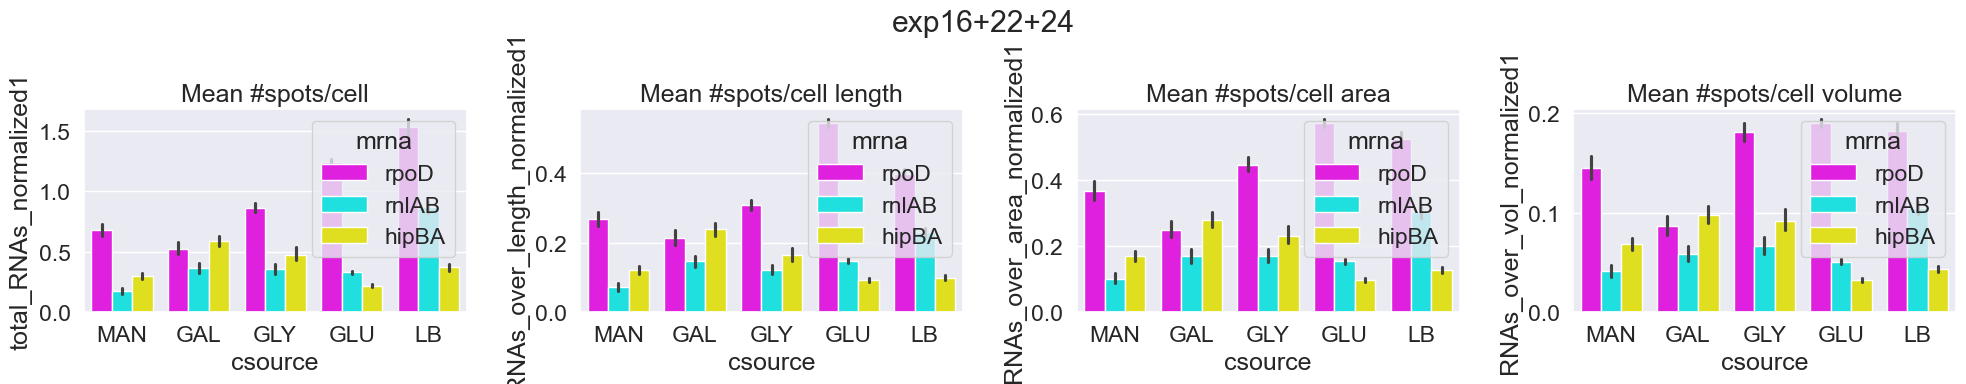

In [71]:
sns.set_style("darkgrid")
data=df_stacked.query('volume < 16.9')

fig, ax = plt.subplots(1, 4, figsize=(20, 4), sharex=True)
g = sns.barplot(data=data, x='csource', order=csources_ordered, y='total_RNAs_normalized1',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0])
g.set(title='Mean #spots/cell')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_length_normalized1',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1])
g.set(title='Mean #spots/cell length')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_area_normalized1',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[2])
g.set(title='Mean #spots/cell area')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_vol_normalized1',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[3])
g.set(title='Mean #spots/cell volume');

fig.suptitle("exp16+22+24")
plt.tight_layout()


savestem = ("/Users/adele/Master/Projects/persisters/fig/analysis/mean_expression_vs_condition_normalized_by_genome_copy_number_exp16+22+24")
plt.savefig(savestem + ".pdf")



###### Normalized by genome copy number and gene copy number


12/12/2024 02:22:09PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
12/12/2024 02:22:09PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
12/12/2024 02:22:09PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
12/12/2024 02:22:09PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
12/12/2024 02:22:10PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates.

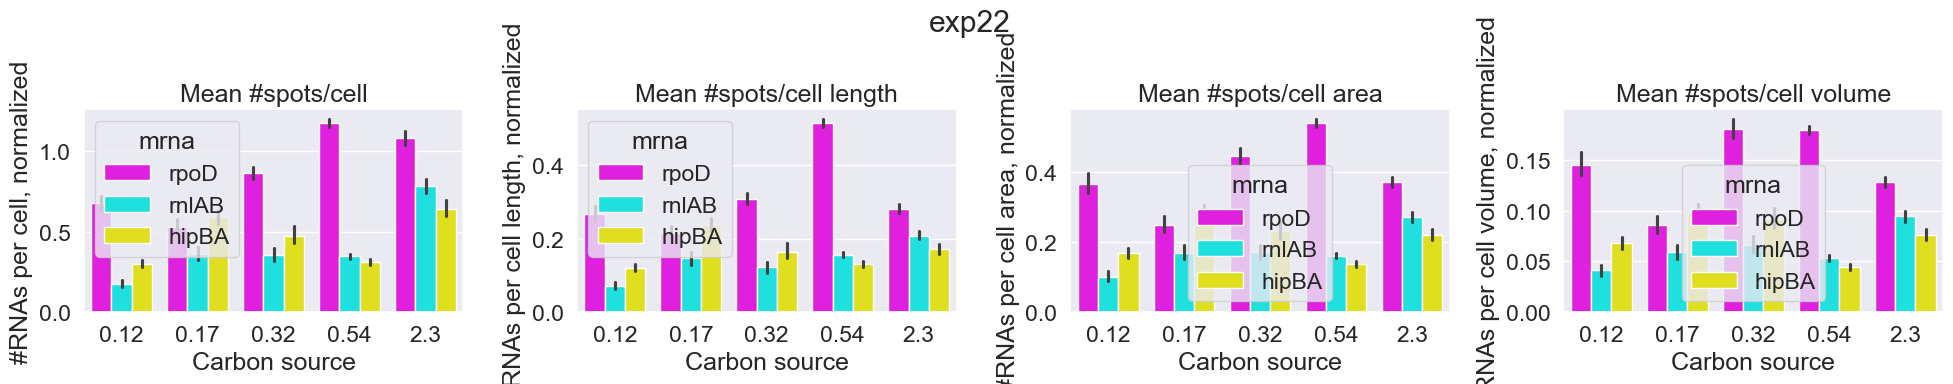

In [72]:
sns.set_style("darkgrid")
data=df_stacked.query('volume < 16.9')

fig, ax = plt.subplots(1, 4, figsize=(20, 4), sharex=True)
g = sns.barplot(data=data, x='mu', y='total_RNAs_normalized2',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0])
g.set(title='Mean #spots/cell', xlabel='Carbon source', ylabel='#RNAs per cell, normalized')

g = sns.barplot(data=data, x='mu', y='RNAs_over_length_normalized2',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1])
g.set(title='Mean #spots/cell length', xlabel='Carbon source', ylabel='#RNAs per cell length, normalized')

g = sns.barplot(data=data, x='mu', y='RNAs_over_area_normalized2',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[2])
g.set(title='Mean #spots/cell area', xlabel='Carbon source', ylabel='#RNAs per cell area, normalized')

g = sns.barplot(data=data, x='mu', y='RNAs_over_vol_normalized2',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[3])
g.set(title='Mean #spots/cell volume', xlabel='Carbon source', ylabel='#RNAs per cell volume, normalized');

fig.suptitle("exp22")
plt.tight_layout()


savestem = ("/Users/adele/Master/Projects/persisters/fig/analysis/mean_expression_vs_condition_normalized_by genome_and_gene_copy_number_exp16+22+24")
plt.savefig(savestem + ".pdf")




##### exp22

###### Unnormalized

12/12/2024 02:22:11PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
12/12/2024 02:22:11PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
12/12/2024 02:22:11PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
12/12/2024 02:22:11PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
12/12/2024 02:22:12PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates.

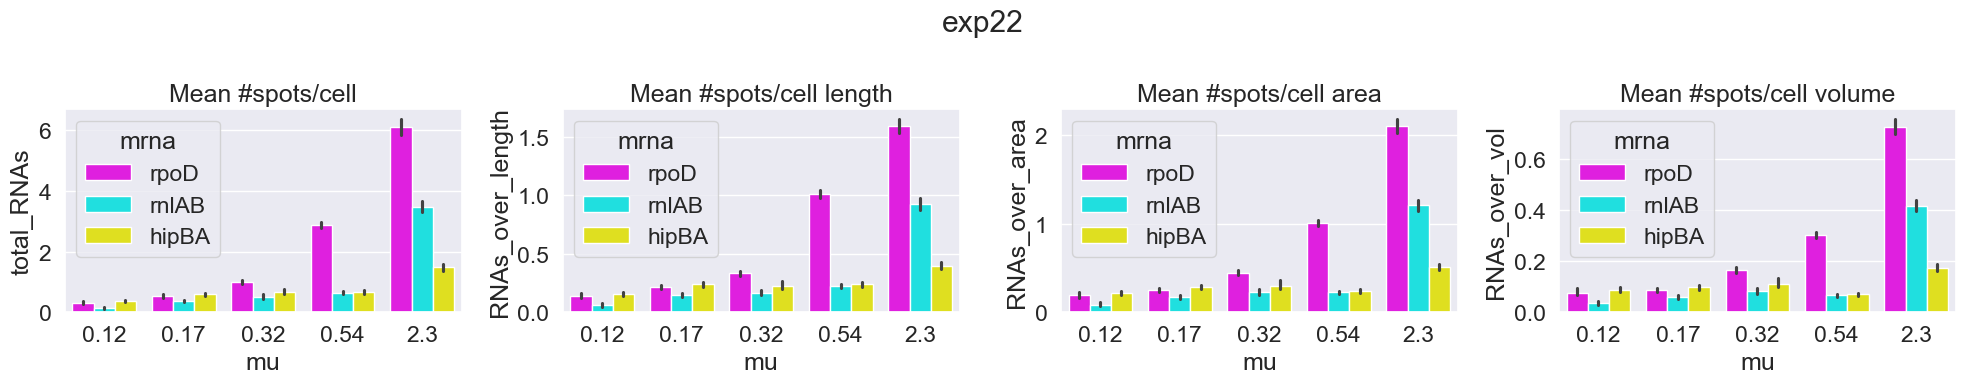

In [73]:
sns.set_style("darkgrid")
data=df_stacked.query('replicate == "exp22"').query('volume < 16.9')

fig, ax = plt.subplots(1, 4, figsize=(20, 4), sharex=True)
g = sns.barplot(data=data, x='mu', y='total_RNAs',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0])
g.set(title='Mean #spots/cell')

g = sns.barplot(data=data, x='mu', y='RNAs_over_length',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1])
g.set(title='Mean #spots/cell length')

g = sns.barplot(data=data, x='mu', y='RNAs_over_area',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[2])
g.set(title='Mean #spots/cell area')

g = sns.barplot(data=data, x='mu', y='RNAs_over_vol',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[3])
g.set(title='Mean #spots/cell volume');

fig.suptitle("exp22")
plt.tight_layout()


savestem = ("/Users/adele/Master/Projects/persisters/fig/analysis/mean_expression_vs_condition_exp22")
plt.savefig(savestem + ".pdf")



###### Normalized by genome copy number

12/12/2024 02:22:13PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
12/12/2024 02:22:13PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
12/12/2024 02:22:13PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
12/12/2024 02:22:13PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
12/12/2024 02:22:13PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates.

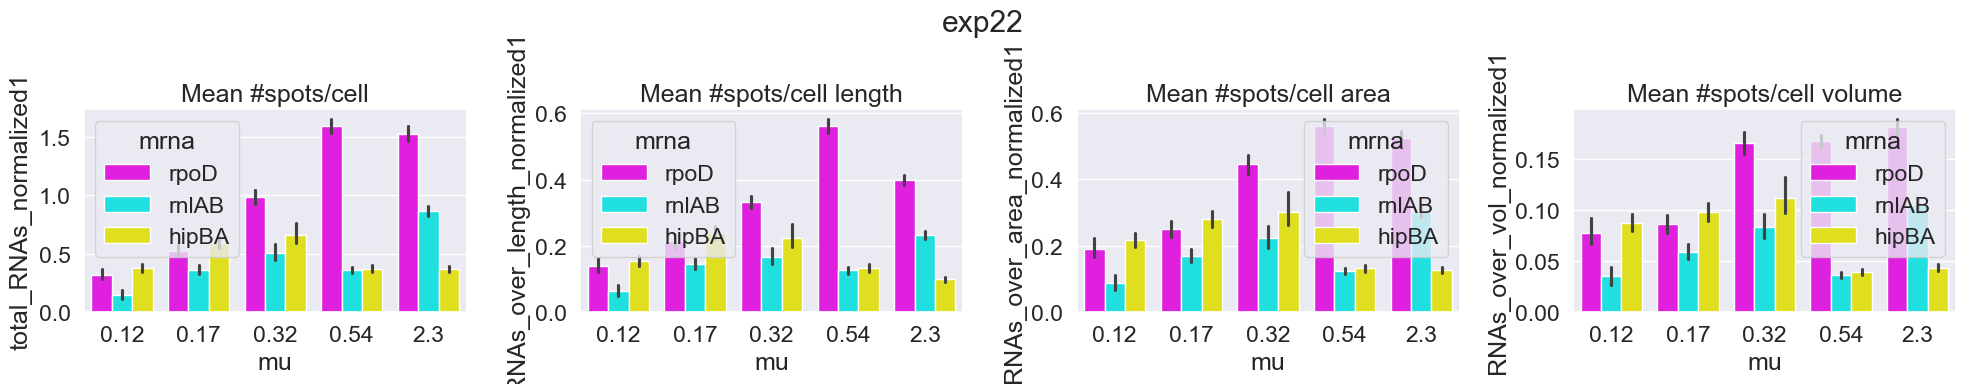

In [74]:
sns.set_style("darkgrid")
data=df_stacked.query('replicate == "exp22"').query('volume < 16.9')

fig, ax = plt.subplots(1, 4, figsize=(20, 4), sharex=True)
g = sns.barplot(data=data, x='mu', y='total_RNAs_normalized1',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0])
g.set(title='Mean #spots/cell')

g = sns.barplot(data=data, x='mu', y='RNAs_over_length_normalized1',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1])
g.set(title='Mean #spots/cell length')

g = sns.barplot(data=data, x='mu', y='RNAs_over_area_normalized1',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[2])
g.set(title='Mean #spots/cell area')

g = sns.barplot(data=data, x='mu', y='RNAs_over_vol_normalized1',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[3])
g.set(title='Mean #spots/cell volume');

fig.suptitle("exp22")
plt.tight_layout()


savestem = ("/Users/adele/Master/Projects/persisters/fig/analysis/mean_expression_vs_condition_normalized_by_genome_copy_number_exp22")
plt.savefig(savestem + ".pdf")



###### Normalized by genome copy number and gene copy number


12/12/2024 02:22:15PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
12/12/2024 02:22:15PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
12/12/2024 02:22:15PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
12/12/2024 02:22:15PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
12/12/2024 02:22:16PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates.

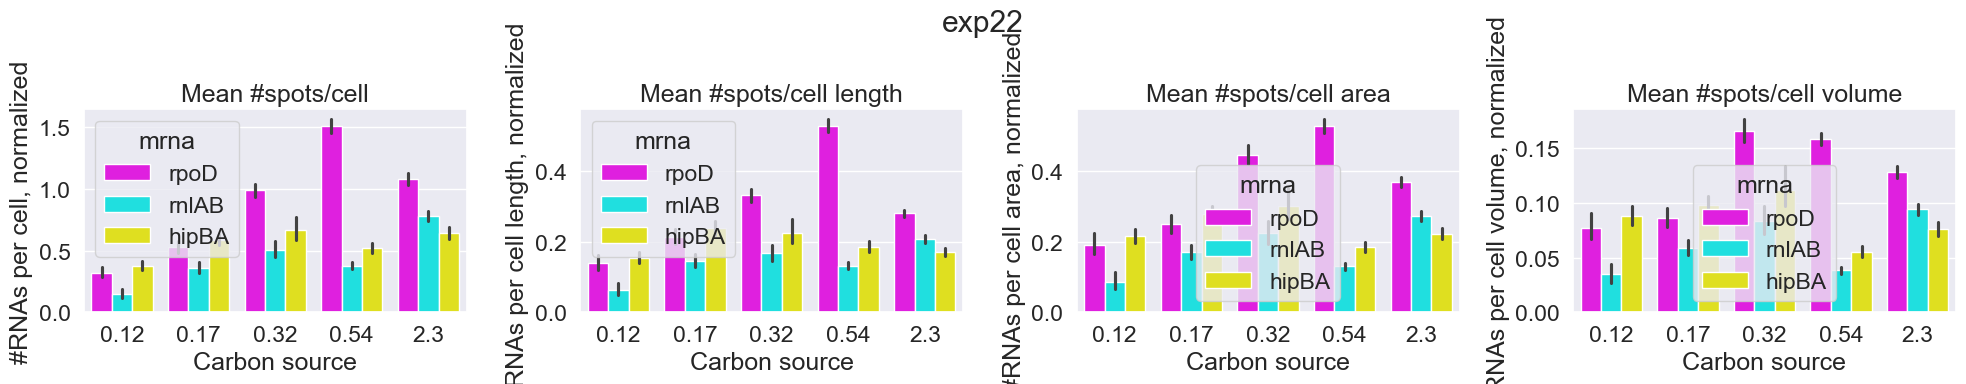

In [75]:
sns.set_style("darkgrid")
data=df_stacked.query('replicate == "exp22"').query('volume < 16.9')

fig, ax = plt.subplots(1, 4, figsize=(20, 4), sharex=True)
g = sns.barplot(data=data, x='mu', y='total_RNAs_normalized2',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0])
g.set(title='Mean #spots/cell', xlabel='Carbon source', ylabel='#RNAs per cell, normalized')

g = sns.barplot(data=data, x='mu', y='RNAs_over_length_normalized2',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1])
g.set(title='Mean #spots/cell length', xlabel='Carbon source', ylabel='#RNAs per cell length, normalized')

g = sns.barplot(data=data, x='mu', y='RNAs_over_area_normalized2',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[2])
g.set(title='Mean #spots/cell area', xlabel='Carbon source', ylabel='#RNAs per cell area, normalized')

g = sns.barplot(data=data, x='mu', y='RNAs_over_vol_normalized2',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[3])
g.set(title='Mean #spots/cell volume', xlabel='Carbon source', ylabel='#RNAs per cell volume, normalized');

fig.suptitle("exp22")
plt.tight_layout()


savestem = ("/Users/adele/Master/Projects/persisters/fig/analysis/mean_expression_vs_condition_normalized_by genome_and_gene_copy_number_exp22")
plt.savefig(savestem + ".pdf")




###### All 3 versions on the same plot

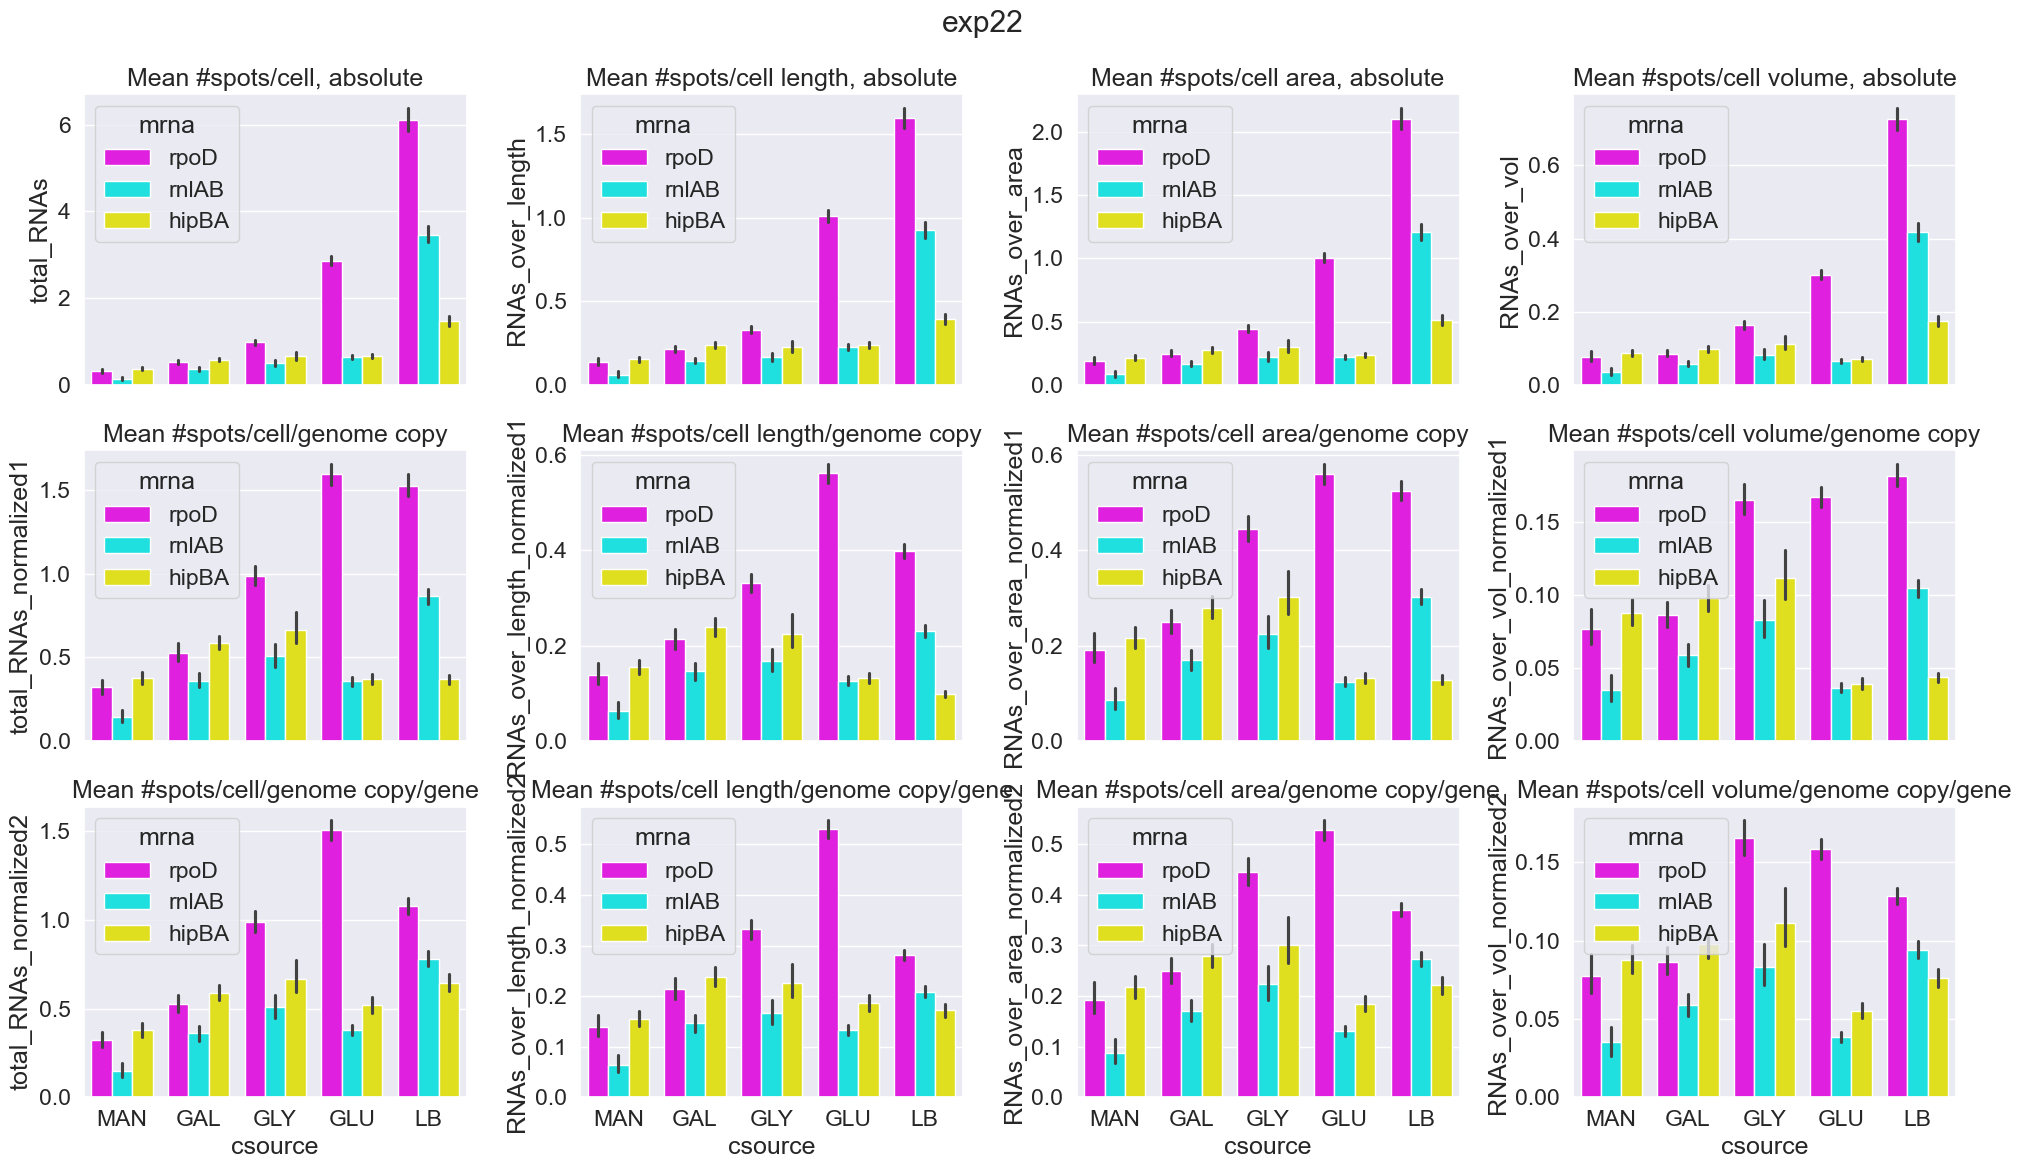

In [76]:
# categorical x-axis
sns.set_style("darkgrid")
data=df_stacked.query('replicate == "exp22"').query('volume < 16.9')

fig, ax = plt.subplots(3, 4, figsize=(20, 12), sharex=True)


# Absolute
g = sns.barplot(data=data, x='csource', order=csources_ordered, y='total_RNAs',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0][0])
g.set(title='Mean #spots/cell, absolute')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_length',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0][1])
g.set(title='Mean #spots/cell length, absolute')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_area',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0][2])
g.set(title='Mean #spots/cell area, absolute')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_vol',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0][3])
g.set(title='Mean #spots/cell volume, absolute')

# Normalized by genome copy number
g = sns.barplot(data=data, x='csource', order=csources_ordered, y='total_RNAs_normalized1',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1][0])
g.set(title='Mean #spots/cell/genome copy')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_length_normalized1',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1][1])
g.set(title='Mean #spots/cell length/genome copy')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_area_normalized1',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1][2])
g.set(title='Mean #spots/cell area/genome copy')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_vol_normalized1',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1][3])
g.set(title='Mean #spots/cell volume/genome copy')


# Normalized by gene copy number
g = sns.barplot(data=data, x='csource', order=csources_ordered, y='total_RNAs_normalized2',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[2][0])
g.set(title='Mean #spots/cell/genome copy/gene')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_length_normalized2',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[2][1])
g.set(title='Mean #spots/cell length/genome copy/gene')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_area_normalized2',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[2][2])
g.set(title='Mean #spots/cell area/genome copy/gene')

g = sns.barplot(data=data, x='csource', order=csources_ordered, y='RNAs_over_vol_normalized2',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[2][3])
g.set(title='Mean #spots/cell volume/genome copy/gene')


fig.suptitle("exp22")
plt.tight_layout()


savestem = ("/Users/adele/Master/Projects/persisters/fig/analysis/mean_expression_vs_condition_all_3versions_exp22")
plt.savefig(savestem + ".pdf")



12/12/2024 02:22:21PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
12/12/2024 02:22:21PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
12/12/2024 02:22:21PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
12/12/2024 02:22:21PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
12/12/2024 02:22:22PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates.

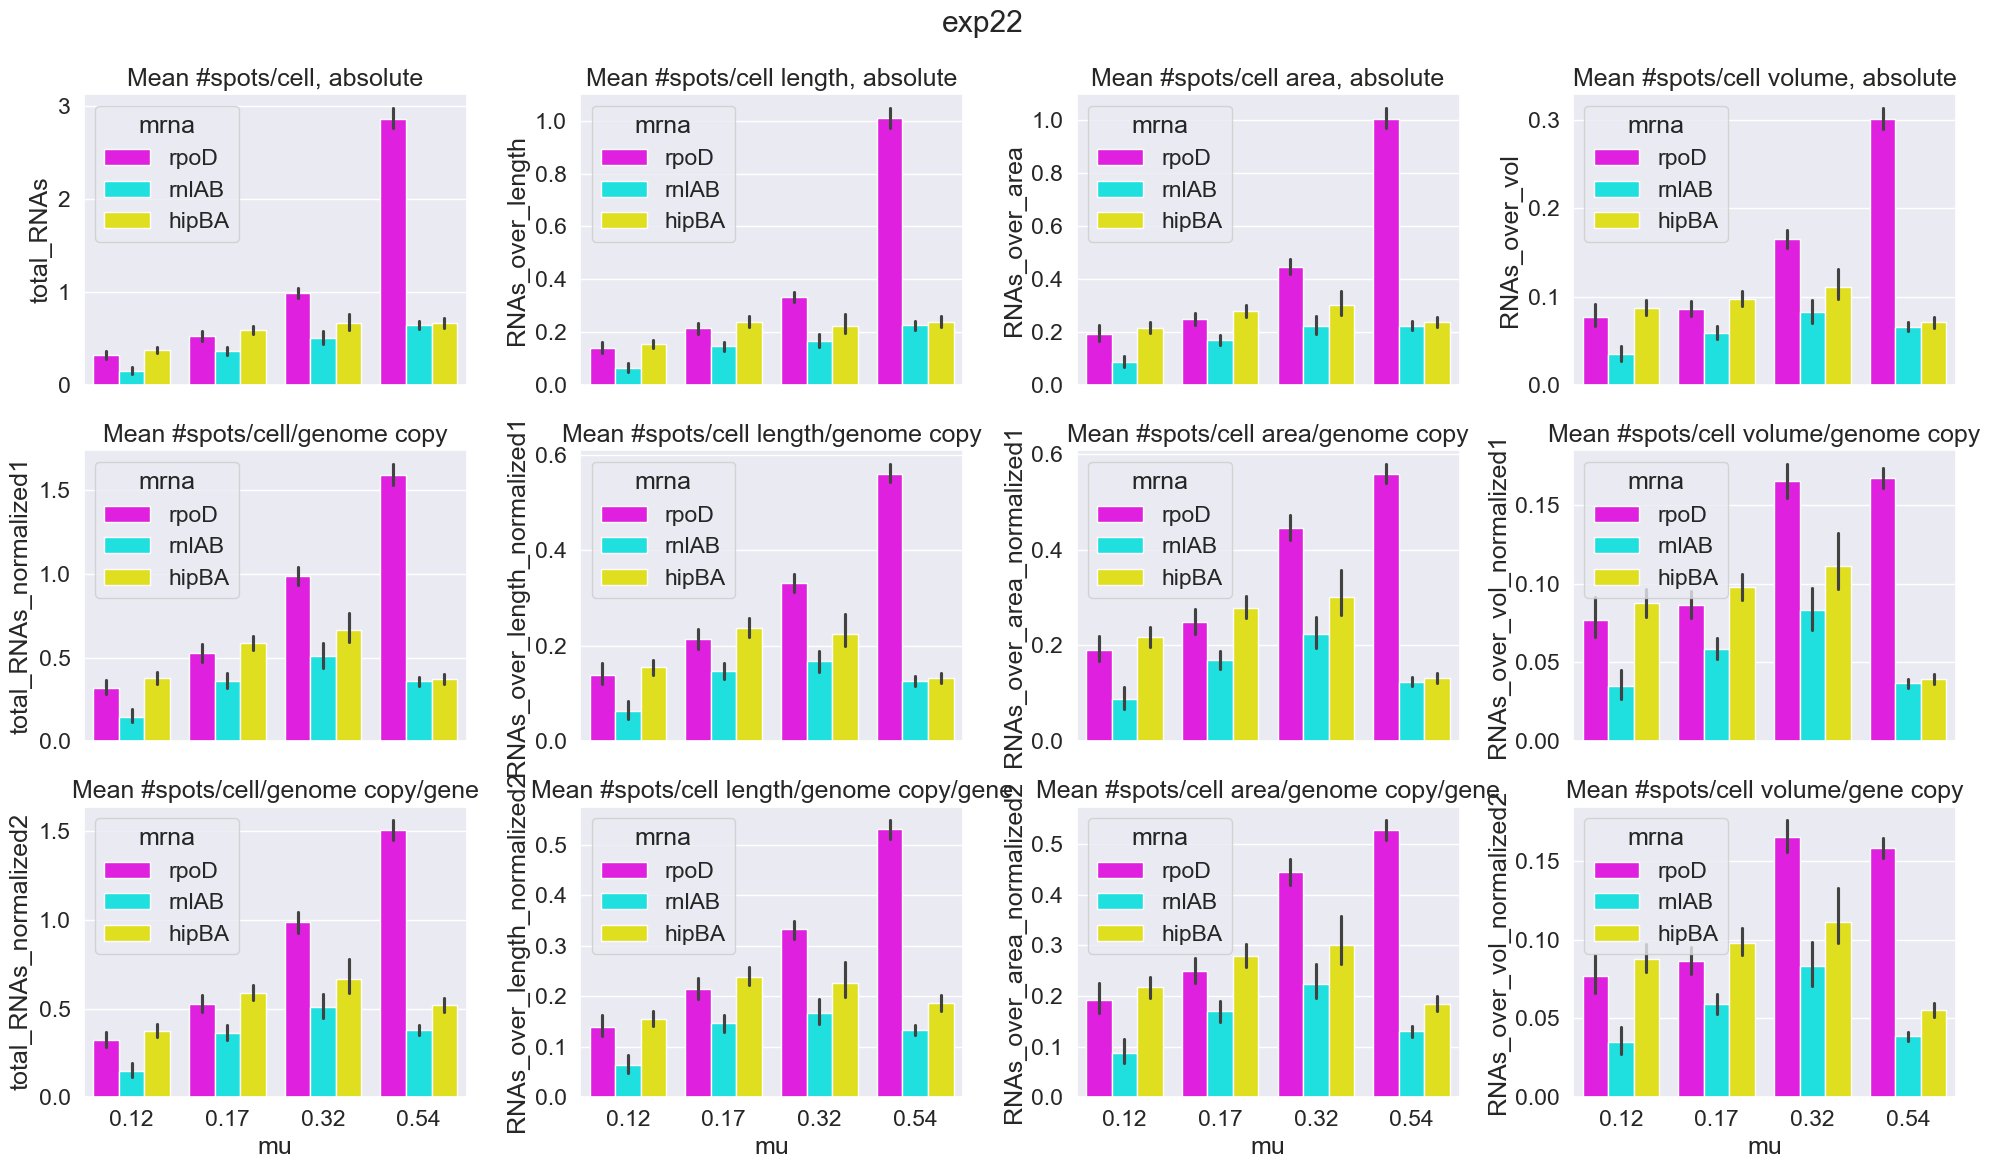

In [77]:
# numerical x-axis, remove LB
sns.set_style("darkgrid")
data=df_stacked.query('replicate == "exp22"').query('volume < 16.9').query('csource != "LB"')

fig, ax = plt.subplots(3, 4, figsize=(20, 12), sharex=True)


# Absolute
g = sns.barplot(data=data, x='mu', y='total_RNAs',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0][0])
g.set(title='Mean #spots/cell, absolute')

g = sns.barplot(data=data, x='mu', y='RNAs_over_length',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0][1])
g.set(title='Mean #spots/cell length, absolute')

g = sns.barplot(data=data, x='mu', y='RNAs_over_area',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0][2])
g.set(title='Mean #spots/cell area, absolute')

g = sns.barplot(data=data, x='mu', y='RNAs_over_vol',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0][3])
g.set(title='Mean #spots/cell volume, absolute')

# Normalized by genome copy number
g = sns.barplot(data=data, x='mu', y='total_RNAs_normalized1',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1][0])
g.set(title='Mean #spots/cell/genome copy')

g = sns.barplot(data=data, x='mu', y='RNAs_over_length_normalized1',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1][1])
g.set(title='Mean #spots/cell length/genome copy')

g = sns.barplot(data=data, x='mu', y='RNAs_over_area_normalized1',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1][2])
g.set(title='Mean #spots/cell area/genome copy')

g = sns.barplot(data=data, x='mu', y='RNAs_over_vol_normalized1',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1][3])
g.set(title='Mean #spots/cell volume/genome copy')


# Normalized by genome copy number and gene copy number
g = sns.barplot(data=data, x='mu', y='total_RNAs_normalized2',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[2][0])
g.set(title='Mean #spots/cell/genome copy/gene')

g = sns.barplot(data=data, x='mu', y='RNAs_over_length_normalized2',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[2][1])
g.set(title='Mean #spots/cell length/genome copy/gene')

g = sns.barplot(data=data, x='mu', y='RNAs_over_area_normalized2',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[2][2])
g.set(title='Mean #spots/cell area/genome copy/gene')

g = sns.barplot(data=data, x='mu', y='RNAs_over_vol_normalized2',
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[2][3])
g.set(title='Mean #spots/cell volume/gene copy')


fig.suptitle("exp22")
plt.tight_layout()


savestem = ("/Users/adele/Master/Projects/persisters/fig/analysis/mean_expression_vs_condition_all_3versions_exp22")
plt.savefig(savestem + ".pdf")



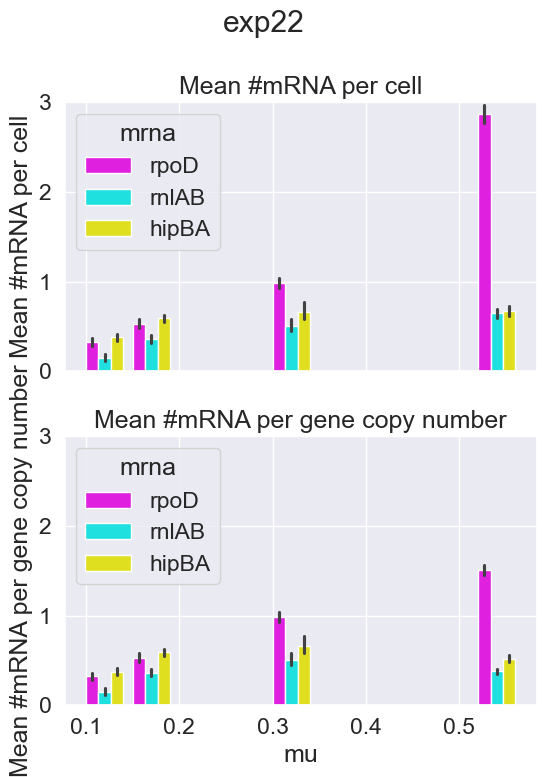

In [78]:
# numerical x-axis, true scale, LB excluded
sns.set_style("darkgrid")
data=df_stacked.query('replicate == "exp22"').query('volume < 16.9').query('csource != "LB"')

fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharex=True)


# Absolute
g = sns.barplot(data=data, x='mu', y='total_RNAs', native_scale=True, width=0.8,
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0])
g.set(title='Mean #mRNA per cell')
g.set_ylim(0, 3)
g.set_ylabel('Mean #mRNA per cell')

# Normalized by genome copy number and gene copy number
g = sns.barplot(data=data, x='mu', y='total_RNAs_normalized2', native_scale=True, width=0.8,
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1])
g.set(title='Mean #mRNA per gene copy number')
g.set_ylim(0, 3)
g.set_ylabel('Mean #mRNA per gene copy number')


fig.suptitle("exp22")
plt.tight_layout()


savestem = ("/Users/adele/Master/Projects/persisters/fig/analysis/mean_expression_vs_condition_all_3versions_exp22")
plt.savefig(savestem + ".pdf")



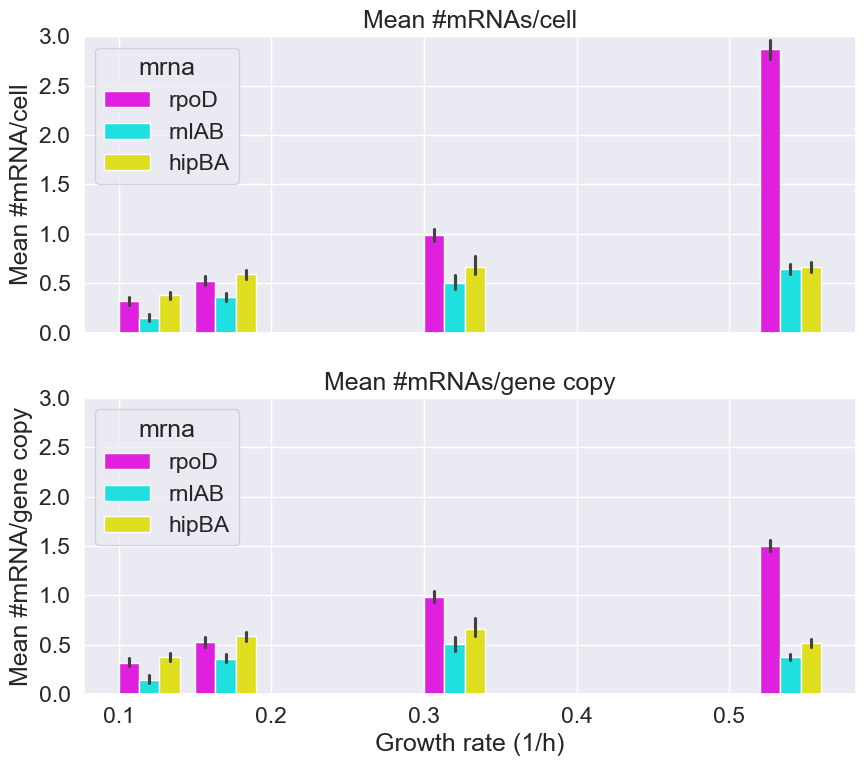

In [79]:
# numerical x-axis, LB excluded
sns.set_style("darkgrid")
sns.set(font_scale=1.5)
data=df_stacked.query('replicate == "exp22"').query('volume < 16.9').query('csource != "LB"')

fig, ax = plt.subplots(2, figsize=(9, 8), sharex=True)


# Absolute
g = sns.barplot(data=data, x='mu', y='total_RNAs', native_scale=True, width=0.8,
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0])
g.set(title='Mean #mRNAs/cell')
g.set_ylim(0, 3)
g.set_ylabel('Mean #mRNA/cell')
g.set(xlabel='Growth rate (1/h)')

# Normalized by genome copy number and gene copy number
g = sns.barplot(data=data, x='mu', y='total_RNAs_normalized2', native_scale=True, width=0.8,
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1])
g.set(title='Mean #mRNAs/gene copy')
g.set_ylim(0, 3)
g.set_ylabel('Mean #mRNA/gene copy')
g.set(xlabel='Growth rate (1/h)')


# fig.suptitle("exp22")
plt.tight_layout()


savestem = ("/Users/adele/Master/Projects/persisters/fig/analysis/mean_expression_vs_condition_normalized_exp22")
plt.savefig(savestem + ".pdf")
plt.savefig(savestem + ".png", dpi=600)
 

#### E.coli parameters and proteomics data

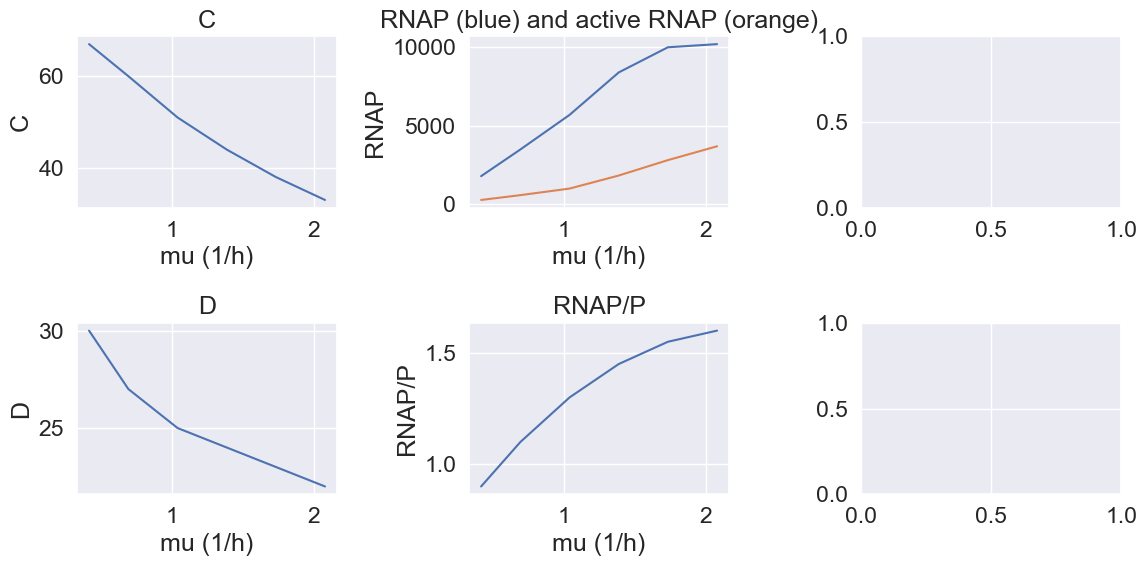

In [80]:
# numbers from Bremer2008
ecoli_params = pd.DataFrame({
    'tau': [100, 60, 40, 30, 24, 20],
    'C': [67, 60, 51, 44, 38, 33], 
    'D': [30, 27, 25, 24, 23, 22],
    'RNAP': [1800, 3500, 5700, 8400, 10000, 10200], # mol./cell
    'RNAP (active)': [285, 592, 1010, 1840, 2820, 3700], # mol./cell (fraction of RNAP molecules that are actively transcribing)
    'RNAP/P': [0.90, 1.10, 1.30, 1.45, 1.55, 1.60], # fraction of total protein that is core RNAP 
})
ecoli_params['mu (doublings/h)'] = 60 / ecoli_params['tau']
ecoli_params['mu (1/h)'] = ecoli_params['mu (doublings/h)'] * np.log(2)

fig, ax = plt.subplots(2, 3, figsize=(12, 6))
sns.lineplot(data=ecoli_params, x='mu (1/h)', y='C', ax=ax[0][0]).set_title("C")
sns.lineplot(data=ecoli_params, x='mu (1/h)', y='D', ax=ax[1][0]).set_title("D")
sns.lineplot(data=ecoli_params, x='mu (1/h)', y='RNAP', ax=ax[0][1])
sns.lineplot(data=ecoli_params, x='mu (1/h)', y='RNAP (active)', ax=ax[0][1]).set_title("RNAP (blue) and active RNAP (orange)")
sns.lineplot(data=ecoli_params, x='mu (1/h)', y='RNAP/P', ax=ax[1][1]).set_title("RNAP/P")
# sns.scatterplot(data=proteomics, x='mu', y='abundance', hue='label', palette=palette_csource_d, ax=ax[0][2]).set_title("rpoD SH2016 (#mol./cell)");
# Mori2021: does not have the same carbon sources nor the same strain
# I can't tell from the tables what the condtions are 
# sns.scatterplot(data=mori_data, x='mu (1/h)', y='abundance', ax=ax[1][2]).set_title("rpoD Mori2021 (absolute mass fractions)")
plt.tight_layout();

(0.0, 3.0)

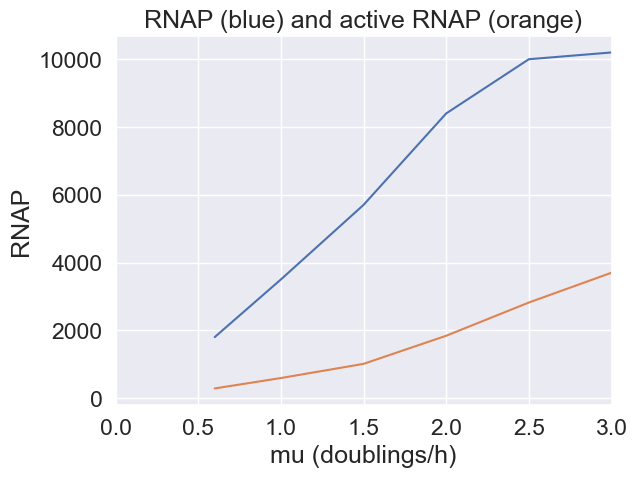

In [81]:
sns.lineplot(data=ecoli_params, x='mu (doublings/h)', y='RNAP').set_title("RNAP (blue) and active RNAP (orange)")
sns.lineplot(data=ecoli_params, x='mu (doublings/h)', y='RNAP (active)')
plt.xlim(0, 3)


(0.0, 11000.0)

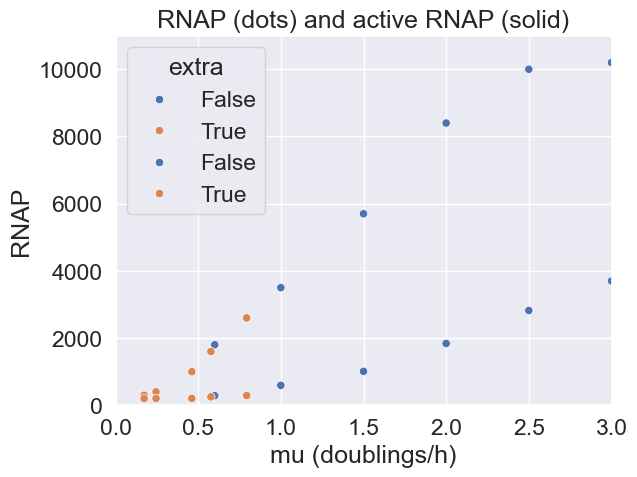

In [82]:
# numbers from Bremer2008
ecoli_params = pd.DataFrame({
    'tau': [100, 60, 40, 30, 24, 20],
    'C': [67, 60, 51, 44, 38, 33],
    'D': [30, 27, 25, 24, 23, 22],
    'RNAP': [1800, 3500, 5700, 8400, 10000, 10200], # mol./cell
    'RNAP (active)': [285, 592, 1010, 1840, 2820, 3700], # mol./cell (fraction of RNAP molecules that are actively transcribing)
    'RNAP/P': [0.90, 1.10, 1.30, 1.45, 1.55, 1.60], # fraction of total protein that is core RNAP
    'extra': False
})
ecoli_params['mu (doublings/h)'] = 60 / ecoli_params['tau']
ecoli_params['mu (1/h)'] = ecoli_params['mu (doublings/h)'] * np.log(2)

for mu, rnap, rnap_active in zip([0.12, 0.17, 0.32, 0.4, 0.55], [300,  400, 1000, 1600, 2600], [200,  202, 205, 250, 290]):
    new_row = pd.DataFrame({'mu (1/h)': mu, 'RNAP': rnap, 'RNAP (active)': rnap_active, 'mu (doublings/h)': mu / np.log(2), 'tau': 60 / mu * np.log(2), 'extra': True}, index=[0])
    ecoli_params = pd.concat([ecoli_params, new_row], ignore_index=True)
sns.scatterplot(data=ecoli_params, x='mu (doublings/h)', y='RNAP', hue='extra').set_title("RNAP (dots) and active RNAP (solid)")
sns.scatterplot(data=ecoli_params, x='mu (doublings/h)', y='RNAP (active)', hue='extra')
plt.xlim(0, 3)
plt.ylim(0, 11000)


In [83]:
ecoli_params

tau     C     D   RNAP  RNAP (active)  RNAP/P  extra  mu (doublings/h)  \
0   100.00  67.0  30.0   1800            285    0.90  False              0.60   
1    60.00  60.0  27.0   3500            592    1.10  False              1.00   
2    40.00  51.0  25.0   5700           1010    1.30  False              1.50   
3    30.00  44.0  24.0   8400           1840    1.45  False              2.00   
4    24.00  38.0  23.0  10000           2820    1.55  False              2.50   
5    20.00  33.0  22.0  10200           3700    1.60  False              3.00   
6   346.57   NaN   NaN    300            200     NaN   True              0.17   
7   244.64   NaN   NaN    400            202     NaN   True              0.25   
8   129.97   NaN   NaN   1000            205     NaN   True              0.46   
9   103.97   NaN   NaN   1600            250     NaN   True              0.58   
10   75.62   NaN   NaN   2600            290     NaN   True              0.79   

    mu (1/h)  
0       0.42  
1       0.69  
2       1.04  
3       1.39  
4       1.73  
5       2.08  
6       0.12  
7       0.17  
8       0.32  
9       0.40  
10      0.55

In [84]:
gene_copy_number.loc[gene_copy_number['csource'] == 'LB', 'RNAP'] = 10200
gene_copy_number.loc[gene_copy_number['csource'] == 'GLU', 'RNAP'] = 2600
gene_copy_number.loc[gene_copy_number['csource'] == 'GLY', 'RNAP'] = 1000
gene_copy_number.loc[gene_copy_number['csource'] == 'GAL', 'RNAP'] = 520
gene_copy_number.loc[gene_copy_number['csource'] == 'MAN', 'RNAP'] = 500

gene_copy_number.loc[gene_copy_number['csource'] == 'LB', 'RNAP (active)'] = 3700
gene_copy_number.loc[gene_copy_number['csource'] == 'GLU', 'RNAP (active)'] = 290
gene_copy_number.loc[gene_copy_number['csource'] == 'GLY', 'RNAP (active)'] = 250
gene_copy_number.loc[gene_copy_number['csource'] == 'GAL', 'RNAP (active)'] = 205
gene_copy_number.loc[gene_copy_number['csource'] == 'MAN', 'RNAP (active)'] = 202
gene_copy_number['RNAP/GCN'] = gene_copy_number['RNAP'] / gene_copy_number['gene_copy_number']
gene_copy_number

strain csource   mrna    mu  gene_copy_number  tau (h)  tau (min)  \
0   MG1655     GAL  hipBA  0.17              1.00     4.08     244.64   
1   MG1655     GAL  rnlAB  0.17              1.00     4.08     244.64   
2   MG1655     GAL   rpoD  0.17              1.00     4.08     244.64   
3   MG1655     GLU  hipBA  0.54              1.28     1.28      77.02   
4   MG1655     GLU  rnlAB  0.54              1.71     1.28      77.02   
5   MG1655     GLU   rpoD  0.54              1.91     1.28      77.02   
6   MG1655     GLY  hipBA  0.32              1.00     2.17     129.97   
7   MG1655     GLY  rnlAB  0.32              1.00     2.17     129.97   
8   MG1655     GLY   rpoD  0.32              1.00     2.17     129.97   
9   MG1655      LB  hipBA  2.30              2.31     0.30      18.08   
10  MG1655      LB  rnlAB  2.30              4.44     0.30      18.08   
11  MG1655      LB   rpoD  2.30              5.66     0.30      18.08   
12  MG1655     MAN  hipBA  0.12              1.00     5.78     346.57   
13  MG1655     MAN  rnlAB  0.12              1.00     5.78     346.57   
14  MG1655     MAN   rpoD  0.12              1.00     5.78     346.57   

       RNAP  RNAP (active)  RNAP/GCN  
0     520.0          205.0    520.00  
1     520.0          205.0    520.00  
2     520.0          205.0    520.00  
3    2600.0          290.0   2027.61  
4    2600.0          290.0   1518.81  
5    2600.0          290.0   1364.20  
6    1000.0          250.0   1000.00  
7    1000.0          250.0   1000.00  
8    1000.0          250.0   1000.00  
9   10200.0         3700.0   4422.23  
10  10200.0         3700.0   2297.05  
11  10200.0         3700.0   1800.82  
12    500.0          202.0    500.00  
13    500.0          202.0    500.00  
14    500.0          202.0    500.00

In [85]:

df_stacked.loc[df_stacked['csource'] == 'LB', 'RNAP'] = 10200
df_stacked.loc[df_stacked['csource'] == 'GLU', 'RNAP'] = 2600
df_stacked.loc[df_stacked['csource'] == 'GLY', 'RNAP'] = 1000
df_stacked.loc[df_stacked['csource'] == 'GAL', 'RNAP'] = 500
df_stacked.loc[df_stacked['csource'] == 'MAN', 'RNAP'] = 300

df_stacked.loc[df_stacked['csource'] == 'LB', 'RNAP (active)'] = 3700
df_stacked.loc[df_stacked['csource'] == 'GLU', 'RNAP (active)'] = 290
df_stacked.loc[df_stacked['csource'] == 'GLY', 'RNAP (active)'] = 250
df_stacked.loc[df_stacked['csource'] == 'GAL', 'RNAP (active)'] = 205
df_stacked.loc[df_stacked['csource'] == 'MAN', 'RNAP (active)'] = 202

df_stacked['total_mRNAs_over_RNAP'] = df_stacked['total_RNAs'] / df_stacked['RNAP']
df_stacked['total_mRNAs_over_active_RNAP'] = df_stacked['total_RNAs'] / df_stacked['RNAP (active)']

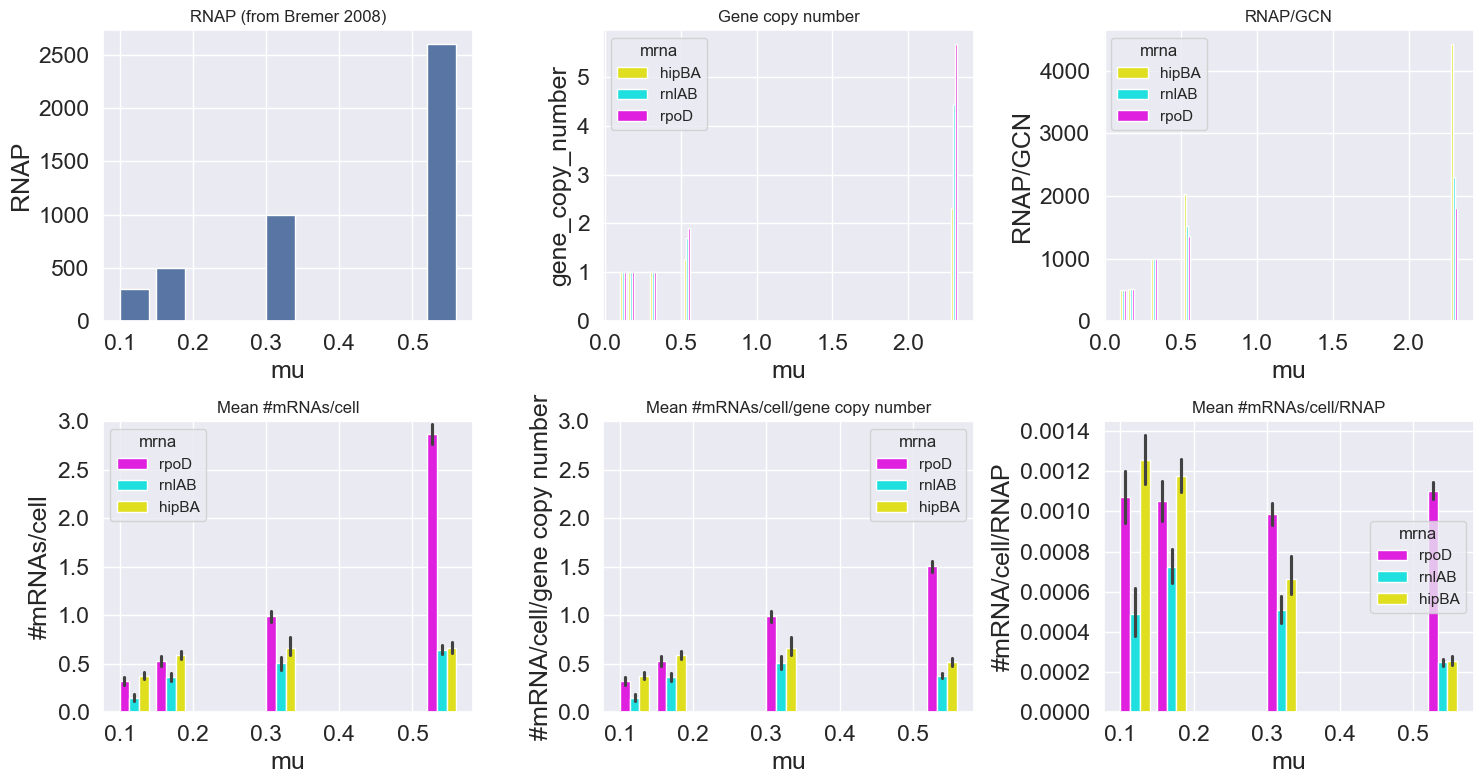

In [86]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
sns.set(font_scale=1)
native_scale = True
data=df_stacked.query('replicate == "exp22"').query('volume < 16.9').query('csource != "LB"')

# RNAP as a function of growth rate
sns.barplot(data=data, x='mu', y='RNAP', native_scale=native_scale, ax=ax[0][0]).set_title("RNAP (from Bremer 2008)")
sns.barplot(data=gene_copy_number, x='mu', y='gene_copy_number', native_scale=native_scale, hue='mrna', palette=palette_mrna, ax=ax[0][1]).set_title(
    'Gene copy number')
sns.barplot(data=gene_copy_number, x='mu', y='RNAP/GCN', native_scale=native_scale, hue='mrna', palette=palette_mrna, ax=ax[0][2]).set_title('RNAP/GCN')

# Expression = #mRNAs/cell
sns.barplot(data=data, x='mu', y='total_RNAs', native_scale=native_scale, width=0.8,
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1][0])
ax[1][0].set_title('Mean #mRNAs/cell')
ax[1][0].set_ylim(0, 3)
ax[1][0].set_ylabel('#mRNAs/cell')

# Expression normalized by gene copy number
sns.barplot(data=data, x='mu', y='total_RNAs_normalized2', native_scale=native_scale, width=0.8,
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1][1])
ax[1][1].set_title('Mean #mRNAs/cell/gene copy number')
ax[1][1].set_ylim(0, 3)
ax[1][1].set_ylabel('#mRNA/cell/gene copy number')

sns.barplot(data=data, x='mu', y='total_mRNAs_over_RNAP', native_scale=native_scale, width=0.8,
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[1][2])
ax[1][2].set_title('Mean #mRNAs/cell/RNAP')
# ax[1][2].set_ylim(0, 3)
ax[1][2].set_ylabel('#mRNA/cell/RNAP')

# Expression normalized by RNAP


plt.tight_layout();

# #RNAP per #rpoD gene copy remain almost the same (they are coupled, whereas for the TA systems we have more RNAP per gene at higher growth rates)

12/12/2024 02:22:33PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
12/12/2024 02:22:33PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
12/12/2024 02:22:33PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
12/12/2024 02:22:33PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
12/12/2024 02:22:33PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates.

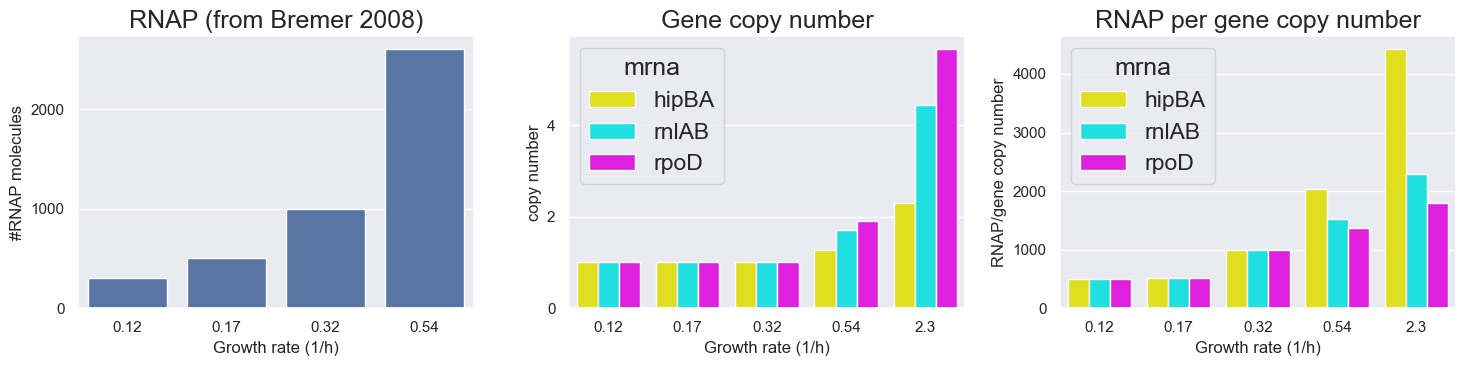

In [87]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
sns.set(font_scale=1.5)
native_scale = False
data=df_stacked.query('replicate == "exp22"').query('volume < 16.9').query('csource != "LB"')

# RNAP as a function of growth rate
sns.barplot(data=data, x='mu', y='RNAP', native_scale=native_scale, width=0.8, ax=ax[0])
ax[0].set(title="RNAP (from Bremer 2008)", xlabel='Growth rate (1/h)', ylabel='#RNAP molecules')

sns.barplot(data=gene_copy_number, x='mu', y='gene_copy_number', native_scale=native_scale, width=0.8, hue='mrna', palette=palette_mrna, ax=ax[1])
ax[1].set(title="Gene copy number", xlabel='Growth rate (1/h)', ylabel='copy number')

sns.barplot(data=gene_copy_number, x='mu', y='RNAP/GCN', native_scale=native_scale, width=0.8, hue='mrna', palette=palette_mrna, ax=ax[2])
ax[2].set(title='RNAP per gene copy number', xlabel='Growth rate (1/h)', ylabel='RNAP/gene copy number'),
plt.tight_layout();

savestem = ("/Users/adele/Master/Projects/persisters/fig/analysis/RNAP_per_GCN")
plt.savefig(savestem + ".pdf")
plt.savefig(savestem + ".png", dpi=600)


# #RNAP per #rpoD gene copy remain almost the same (they are coupled, whereas for the TA systems we have more RNAP per gene at higher growth rates)

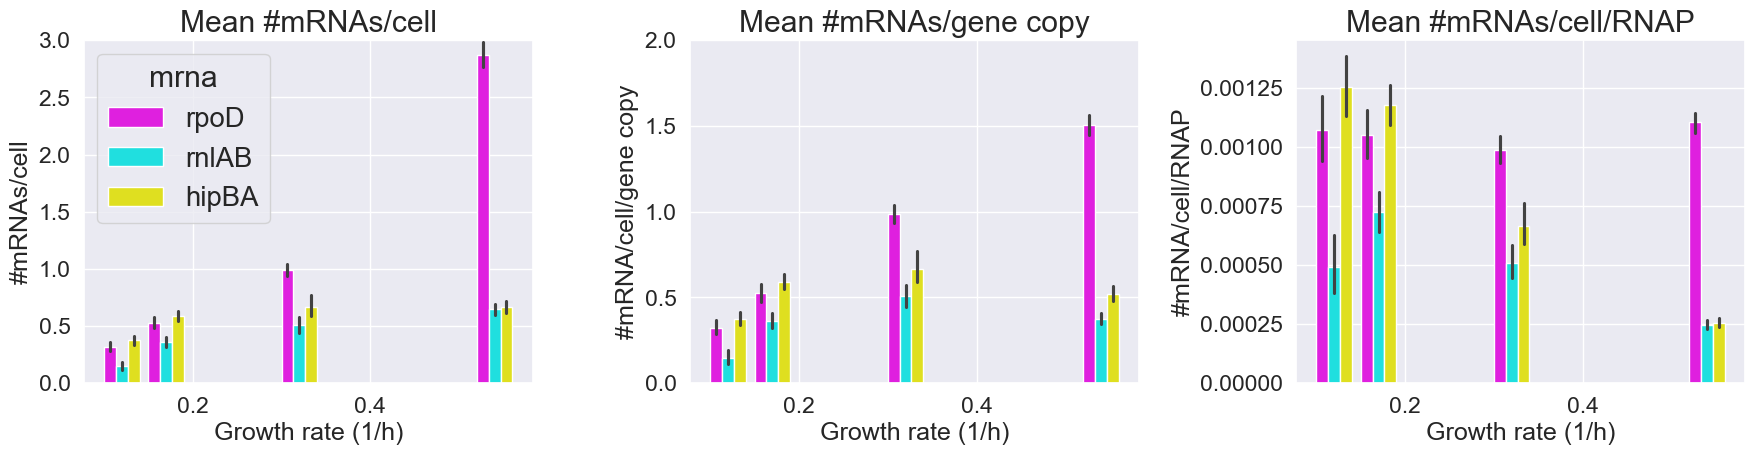

In [88]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
sns.set(font_scale=1.8)
native_scale = True
data=df_stacked.query('replicate == "exp22"').query('volume < 16.9').query('csource != "LB"')

# Expression = #mRNAs/cell
sns.barplot(data=data, x='mu', y='total_RNAs', native_scale=native_scale, width=0.8,
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, ax=ax[0])
ax[0].set_title('Mean #mRNAs/cell')
ax[0].set_ylim(0, 3)
ax[0].set_xlabel('Growth rate (1/h)')
ax[0].set_ylabel('#mRNAs/cell')

# Expression normalized by gene copy number
sns.barplot(data=data, x='mu', y='total_RNAs_normalized2', native_scale=native_scale, width=0.8,
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, legend=False, ax=ax[1])
ax[1].set_title('Mean #mRNAs/gene copy')
ax[1].set_ylim(0, 2)
ax[1].set_xlabel('Growth rate (1/h)')
ax[1].set_ylabel('#mRNA/cell/gene copy')

sns.barplot(data=data, x='mu', y='total_mRNAs_over_RNAP', native_scale=native_scale, width=0.8,
            hue='mrna', hue_order=mrna_ordered, palette=palette_mrna, legend=False, ax=ax[2])
ax[2].set_title('Mean #mRNAs/cell/RNAP')
# ax[2].set_ylim(0, 3)
ax[2].set_xlabel('Growth rate (1/h)')
ax[2].set_ylabel('#mRNA/cell/RNAP')

plt.tight_layout();

savestem = ("/Users/adele/Master/Projects/persisters/fig/analysis/mean_expression_vs_RNAP_exp22")
plt.savefig(savestem + ".pdf")
plt.savefig(savestem + ".png", dpi=600)

# #RNAP per #rpoD gene copy remain almost the same (they are coupled, whereas for the TA systems we have more RNAP per gene at higher growth rates)

In [89]:
data=df_stacked.query('replicate == "exp22"')
data[['total_RNAs', 'gene_copy_number', 'total_RNAs_normalized2']]

total_RNAs  \
unique_id                                                        
exp22.exp22-GLU_01.3.rpoD                                    0   
exp22.exp22-GLU_01.4.rpoD                                    3   
exp22.exp22-GLU_01.5.rpoD                                    5   
exp22.exp22-GLU_01.6.rpoD                                    2   
exp22.exp22-GLU_01.7.rpoD                                    1   
...                                                        ...   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...           1   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...           1   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...           2   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.217...           0   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.217...           0   

                                                    gene_copy_number  \
unique_id                                                              
exp22.exp22-GLU_01.3.rpoD                                       1.91   
exp22.exp22-GLU_01.4.rpoD                                       1.91   
exp22.exp22-GLU_01.5.rpoD                                       1.91   
exp22.exp22-GLU_01.6.rpoD                                       1.91   
exp22.exp22-GLU_01.7.rpoD                                       1.91   
...                                                              ...   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...              2.31   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...              2.31   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...              2.31   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.217...              2.31   
exp22.MG1655_LB_fixed2806_hybed1906_left_07.217...              2.31   

                                                    total_RNAs_normalized2  
unique_id                                                                   
exp22.exp22-GLU_01.3.rpoD                                             0.00  
exp22.exp22-GLU_01.4.rpoD                                             1.57  
exp22.exp22-GLU_01.5.rpoD                                             2.62  
exp22.exp22-GLU_01.6.rpoD                                             1.05  
exp22.exp22-GLU_01.7.rpoD                                             0.52  
...                                                                    ...  
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...                    0.43  
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...                    0.43  
exp22.MG1655_LB_fixed2806_hybed1906_left_07.216...                    0.87  
exp22.MG1655_LB_fixed2806_hybed1906_left_07.217...                    0.00  
exp22.MG1655_LB_fixed2806_hybed1906_left_07.217...                    0.00  

[25923 rows x 3 columns]

In [90]:
data.columns

Index(['image_cell_id', 'spots', 'dense_regions', 'decomposed_RNAs', 'tx',
       'nascent_RNAs', 'total_RNAs', 'mrna', 'strain', 'condition', 'seqnr',
       'image', 'experiment', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'area',
       'eccentricity', 'axis_minor_length', 'axis_major_length', 'orientation',
       'perimeter', 'solidity', 'bbox-0_expanded', 'bbox-1_expanded',
       'bbox-2_expanded', 'bbox-3_expanded', 'area_expanded',
       'eccentricity_expanded', 'axis_minor_length_expanded',
       'axis_major_length_expanded', 'orientation_expanded',
       'perimeter_expanded', 'solidity_expanded', 'nuclei', 'csource',
       'coverslip', 'replicate', 'unique_cell_id', 'selected', 'volume',
       'volume_ellipsoid', 'RNAs_over_area', 'RNAs_over_vol',
       'RNAs_over_length', 'RNAs_over_eccentricity', 'mu', 'tau (h)',
       'tau (min)', 'csource_d', 'DNA_copy_number', 'total_RNAs_normalized1',
       'RNAs_over_length_normalized1', 'RNAs_over_area_normalized1',
       'RNAs

In [91]:
mean_mRNA_per_gene_copy = data.groupby(['strain', 'replicate', 'mrna', 'mu'])['total_RNAs_normalized2'].mean()
mean_mRNA_over_mean_volume = data.groupby(['strain', 'replicate', 'mrna', 'mu'])['total_RNAs'].mean() / data.groupby(['strain', 'replicate', 'mrna', 'mu'])['volume'].mean()
mean_mRNA_over_volume =  data.groupby(['strain', 'replicate', 'mrna', 'mu'])['RNAs_over_vol'].mean()
mean_mRNAs = pd.DataFrame({ 'mean_mRNA_per_gene_copy': mean_mRNA_per_gene_copy, 'mean_mRNA_over_mean_volume': mean_mRNA_over_mean_volume, 'mean_mRNA_over_volume': mean_mRNA_over_volume})
mean_mRNAs

mean_mRNA_per_gene_copy  \
strain replicate mrna  mu                              
MG1655 exp22     hipBA 0.12                     0.39   
                       0.17                     0.59   
                       0.32                     0.69   
                       0.54                     0.54   
                       2.30                     0.68   
                 rnlAB 0.12                     0.15   
                       0.17                     0.37   
                       0.32                     0.54   
                       0.54                     0.39   
                       2.30                     0.83   
                 rpoD  0.12                     0.33   
                       0.17                     0.53   
                       0.32                     1.06   
                       0.54                     1.56   
                       2.30                     1.14   

                             mean_mRNA_over_mean_volume  mean_mRNA_over_volume  
strain replicate mrna  mu                                                       
MG1655 exp22     hipBA 0.12                        0.07                   0.09  
                       0.17                        0.09                   0.10  
                       0.32                        0.08                   0.11  
                       0.54                        0.06                   0.07  
                       2.30                        0.13                   0.17  
                 rnlAB 0.12                        0.03                   0.03  
                       0.17                        0.05                   0.06  
                       0.32                        0.06                   0.08  
                       0.54                        0.06                   0.06  
                       2.30                        0.31                   0.40  
                 rpoD  0.12                        0.06                   0.08  
                       0.17                        0.08                   0.09  
                       0.32                        0.12                   0.16  
                       0.54                        0.27                   0.30  
                       2.30                        0.55                   0.69

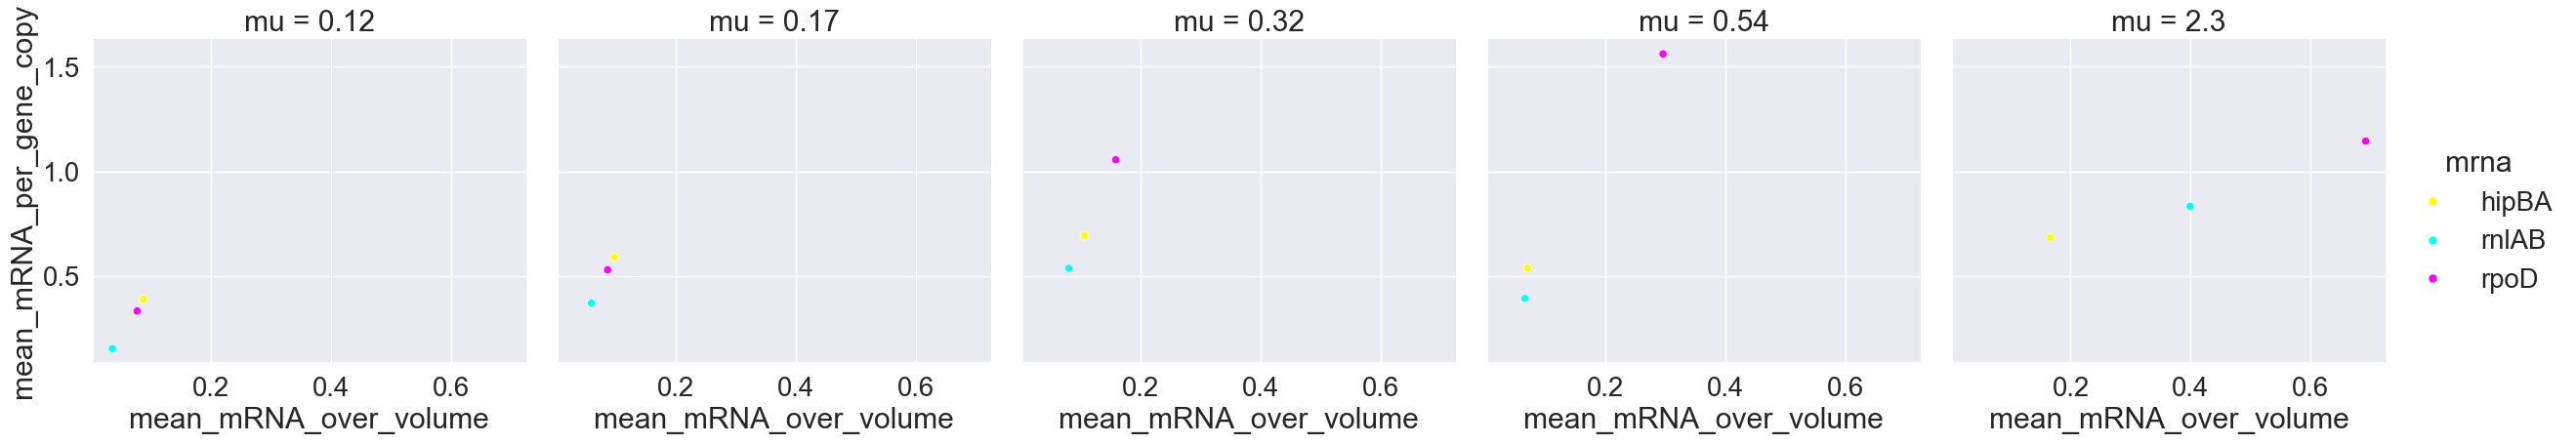

In [92]:
sns.relplot(data=mean_mRNAs, x='mean_mRNA_over_volume', y='mean_mRNA_per_gene_copy', col='mu', hue='mrna', palette=palette_mrna);

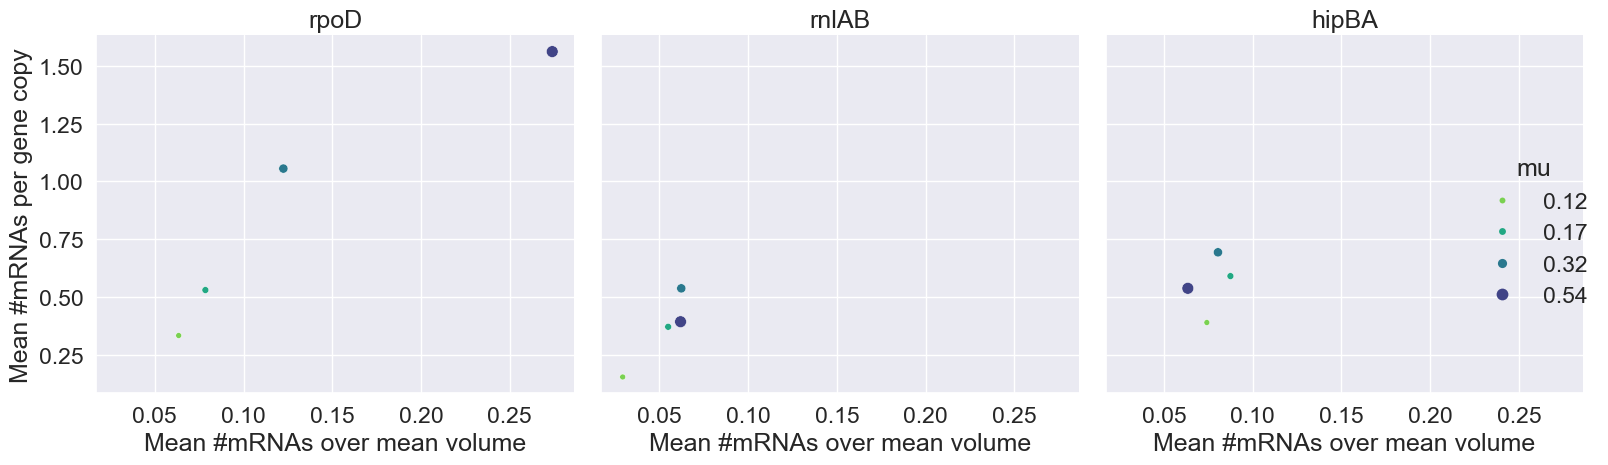

In [93]:
sns.set(font_scale=1.5)
g = sns.relplot(data=mean_mRNAs.query('mu != 2.3'), x='mean_mRNA_over_mean_volume', y='mean_mRNA_per_gene_copy', col='mrna', col_order=mrna_ordered, hue='mu', palette=sns.color_palette("viridis_r", 4), size='mu')
g.set_titles('{col_name}')
g.set_xlabels('Mean #mRNAs over mean volume')
g.set_ylabels('Mean #mRNAs per gene copy');
plt.tight_layout();



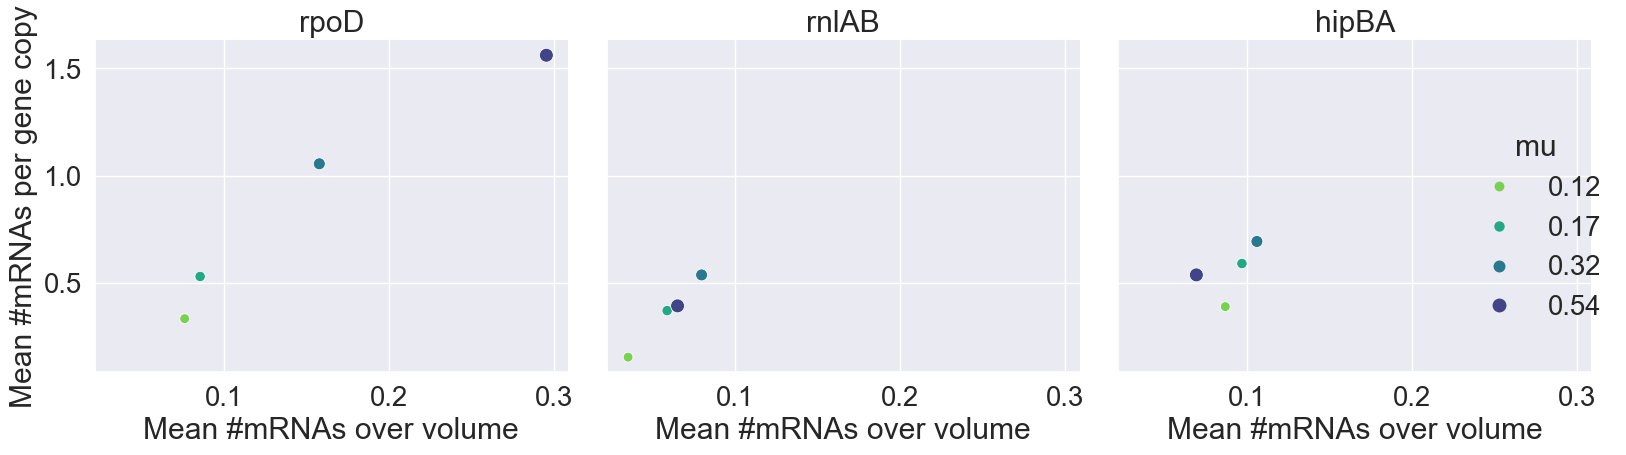

In [94]:
sns.set(font_scale=1.8)
g = sns.relplot(data=mean_mRNAs.query('mu != 2.3'), x='mean_mRNA_over_volume', y='mean_mRNA_per_gene_copy', col='mrna', col_order=mrna_ordered, hue='mu', palette=sns.color_palette("viridis_r", 4), size='mu', sizes=(50, 100), legend=True)
g.set_titles('{col_name}')
g.set_xlabels('Mean #mRNAs over volume')
g.set_ylabels('Mean #mRNAs per gene copy')
plt.tight_layout()

savestem = ("/Users/adele/Master/Projects/persisters/fig/analysis/mean_expression_per_gene_copy_vs_mean_expression_per_volume_exp22")
plt.savefig(savestem + ".pdf")

In [ ]:
mori = pd.read_excel("/Users/adele/Master/Projects/persisters/data/proteomics/mori2021/44320_2021_bfmsb20209536_moesm9_esm.xlsx", sheet_name="EV8-AbsoluteMassFractions-1")
mori_rpoD = mori[mori['Gene name'] == 'rpoD']
mori_rpoD

In [ ]:
del mori

In [ ]:
mori_rpoD.columns

In [ ]:
mori_data = pd.DataFrame({
    'tau': [83, 104, 173, 46, 61, 37, 85, 50, 54, 49],
    'col': ['Lib-06', 'Lib-13', 'Lib-15', 'Lib-24', 'Lib-25', 'Lib-26', 'Lib-27', 'Lib-28', 'Lib-29', 'Lib-30']
})
mori_data['abundance'] = mori_rpoD[mori_data['col']].values.T
mori_data['mu (doublings/h)'] = 60 / mori_data['tau']
mori_data['mu (1/h)'] = mori_data['mu (doublings/h)'] * np.log(2)

mori_data

In [ ]:
sns.scatterplot(mori_data, x='mu (1/h)', y='abundance');

In [ ]:
schmidt_heinemann_LB_GLU = pd.read_excel("/Users/adele/Master/Projects/persisters/data/proteomics/41587_2016_BFnbt3418_MOESM18_ESM.xlsx", sheet_name="Table S9", skiprows=2)
schmidt_heinemann_LB_GLU.dropna().query('Description.str.contains("RNA polymerase")')

In [ ]:
schmidt_heinemann_absolute = pd.read_excel("/Users/adele/Master/Projects/persisters/data/proteomics/41587_2016_BFnbt3418_MOESM18_ESM.xlsx", sheet_name="Table S6", skiprows=2)
schmidt_heinemann_absolute.dropna().query('Description.str.contains("RNA polymerase")')

In [ ]:
schmidt_heinemann_absolute.query('Gene == "rpoD"').columns

In [ ]:
schmidt_heinemann_absolute.query('Gene == "rpoD"')[['LB', 'Glucose', 'Glycerol', 'Galactose ', 'Mannose']]

In [ ]:
proteomics = pd.DataFrame(conditions_d)
proteomics['abundance'] = schmidt_heinemann_absolute.query('Gene == "rpoD"')[['LB', 'Glucose', 'Glycerol', 'Galactose ', 'Mannose']].values.T
sns.scatterplot(proteomics, x='mu', y='abundance', hue='label', palette=palette_csource_d);

#### Noise and Fano factor 
as per Taniguchi 2010, except:
- "Because the same probe is used for all strains, the optimized hybridization efficiency is unbiased for every measured gene"
is not true for us.
- also not: "We excluded gene dosage effects by gating with the cell size to select the cells that have not yet gone through chromosome replication"
- 

##### Per replicate

In [97]:
rep_mrna_counts = df_stacked.groupby(['strain', 'csource', 'replicate', 'mrna'])['total_RNAs'].sum()
rep_cell_counts = df_stacked.groupby(['strain', 'csource', 'replicate', 'mrna']).size()
rep_frequencies_series = rep_mrna_counts / rep_cell_counts
rep_frequencies_series.name = "mean"
rep_frequencies = pd.DataFrame(rep_frequencies_series).reset_index()
rep_mrna_stds = pd.DataFrame(df_stacked.groupby(['strain', 'csource', 'replicate', 'mrna'])['total_RNAs'].std()).reset_index()
rep_mrna_stds.rename(columns={'total_RNAs': 'std'}, inplace=True)
rep_frequencies = rep_frequencies.merge(rep_mrna_stds, on=['strain', 'csource', 'replicate', 'mrna'])
rep_frequencies['noise'] = np.square(rep_frequencies['std'] / rep_frequencies['mean'])
rep_frequencies['fano'] = np.square(rep_frequencies['std']) / rep_frequencies['mean']
rep_frequencies

strain csource replicate   mrna  mean   std  noise  fano
0   MG1655     GAL     exp22  hipBA  0.59  0.95   2.62  1.54
1   MG1655     GAL     exp22  rnlAB  0.37  0.97   6.86  2.54
2   MG1655     GAL     exp22   rpoD  0.53  1.15   4.68  2.48
3   MG1655     GLU     exp16  hipBA  0.37  0.89   5.91  2.16
4   MG1655     GLU     exp16  rnlAB  0.75  1.04   1.94  1.45
5   MG1655     GLU     exp16   rpoD  2.43  1.52   0.39  0.95
6   MG1655     GLU     exp22  hipBA  0.69  1.04   2.26  1.56
7   MG1655     GLU     exp22  rnlAB  0.67  0.96   2.06  1.38
8   MG1655     GLU     exp22   rpoD  2.98  2.12   0.51  1.51
9   MG1655     GLU     exp24  hipBA  0.16  0.48   9.22  1.46
10  MG1655     GLU     exp24  rnlAB  0.12  0.39  11.69  1.35
11  MG1655     GLU     exp24   rpoD  0.97  1.21   1.58  1.52
12  MG1655     GLY     exp16  hipBA  0.17  0.57  11.87  1.97
13  MG1655     GLY     exp16  rnlAB  0.29  0.99  11.85  3.41
14  MG1655     GLY     exp16   rpoD  1.00  2.00   4.00  4.01
15  MG1655     GLY     exp22  hipBA  0.69  2.23  10.37  7.19
16  MG1655     GLY     exp22  rnlAB  0.54  1.69   9.92  5.33
17  MG1655     GLY     exp22   rpoD  1.06  1.44   1.86  1.96
18  MG1655     GLY     exp24  hipBA  0.30  1.11  13.28  4.03
19  MG1655     GLY     exp24  rnlAB  0.18  0.81  19.66  3.60
20  MG1655     GLY     exp24   rpoD  0.69  1.03   2.27  1.55
21  MG1655      LB     exp22  hipBA  1.58  1.92   1.49  2.35
22  MG1655      LB     exp22  rnlAB  3.70  3.24   0.77  2.84
23  MG1655      LB     exp22   rpoD  6.48  4.30   0.44  2.85
24  MG1655     MAN     exp16  hipBA  0.22  0.59   7.22  1.59
25  MG1655     MAN     exp16  rnlAB  0.23  0.62   7.08  1.65
26  MG1655     MAN     exp16   rpoD  1.16  1.91   2.70  3.14
27  MG1655     MAN     exp22  hipBA  0.39  0.86   4.85  1.89
28  MG1655     MAN     exp22  rnlAB  0.15  0.87  31.88  4.90
29  MG1655     MAN     exp22   rpoD  0.33  0.94   7.90  2.63

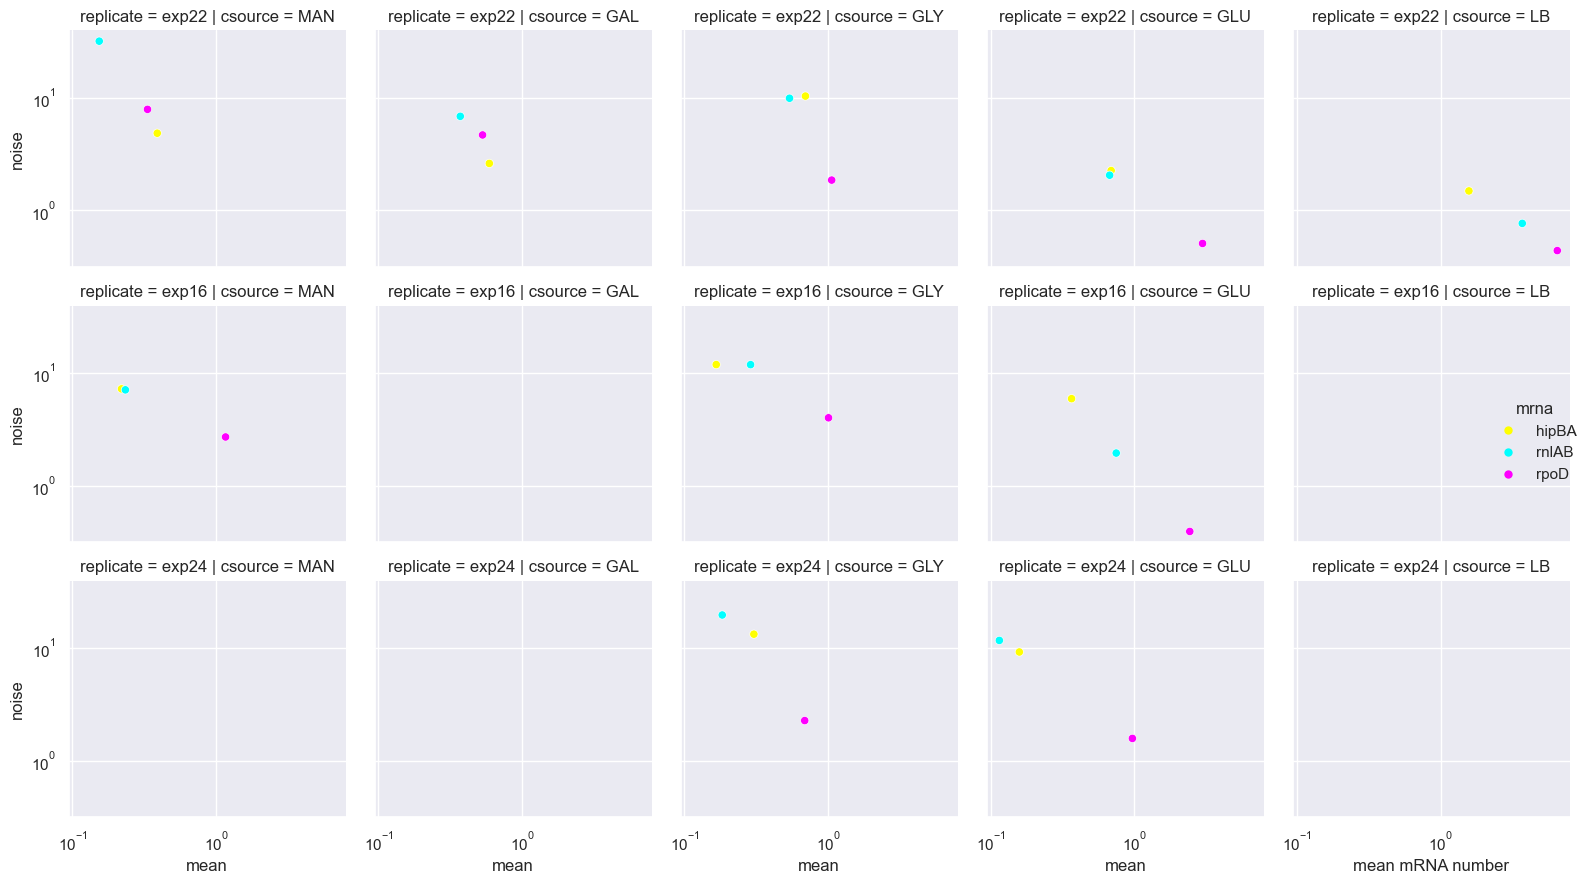

In [98]:
sns.relplot(rep_frequencies, x='mean', y='noise', 
            col='csource', col_order=csources_ordered, 
            row='replicate', 
            hue='mrna', palette=palette_mrna,
            height=3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('mean mRNA number')
plt.ylabel('mRNA noise')
plt.tight_layout();

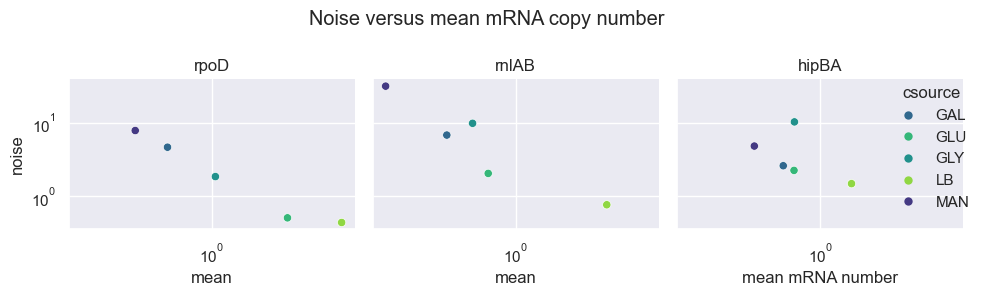

In [99]:
g = sns.relplot(rep_frequencies.query('replicate == "exp22"'), x='mean', y='noise', 
            col='mrna', col_order=mrna_ordered, 
            row='replicate', 
            hue='csource', palette=palette_csource,
            height=3)
g.set_titles('{col_name}');
g.fig.suptitle("Noise versus mean mRNA copy number")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('mean mRNA number')
plt.ylabel('mRNA noise')
plt.tight_layout();

savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/noise_vs_mean_expression-exp22"
plt.savefig(savestem + ".pdf")

##### Per image

In [100]:
mrna_counts = df_stacked.groupby(['strain', 'csource', 'replicate', 'seqnr', 'mrna'])['total_RNAs'].sum()  # Number of spots per csource per image per channel
cell_counts = df_stacked.groupby(['strain', 'csource', 'replicate', 'seqnr', 'mrna']).size() # Number of cells per csource per image exploded per channel
frequencies_series = mrna_counts / cell_counts # mean number of spots per image per channel
frequencies_series.name = "mean"
frequencies = pd.DataFrame(frequencies_series).reset_index()
mrna_stds = pd.DataFrame(df_stacked.groupby(['strain', 'csource', 'replicate', 'seqnr', 'mrna'])['total_RNAs'].std()).reset_index() # Standard deviation of number of spots per csource per image per channel
mrna_stds.rename(columns={'total_RNAs': 'std'}, inplace=True)
frequencies = frequencies.merge(mrna_stds, on=['strain', 'csource', 'replicate', 'mrna', 'seqnr'])
frequencies['noise'] = np.square(frequencies['std'] / frequencies['mean']) # noise
frequencies['fano'] = np.square(frequencies['std']) / frequencies['mean'] # Fano factor

frequencies

strain csource replicate seqnr   mrna  mean   std  noise  fano
0    MG1655     GAL     exp22    03  hipBA  0.52  0.86   2.68  1.40
1    MG1655     GAL     exp22    03  rnlAB  0.31  0.98  10.25  3.15
2    MG1655     GAL     exp22    03   rpoD  0.46  0.93   4.19  1.91
3    MG1655     GAL     exp22    04  hipBA  0.74  1.10   2.21  1.64
4    MG1655     GAL     exp22    04  rnlAB  0.44  1.01   5.28  2.32
..      ...     ...       ...   ...    ...   ...   ...    ...   ...
124  MG1655     MAN     exp22    05  rnlAB  0.11  0.48  17.49  2.00
125  MG1655     MAN     exp22    05   rpoD  0.35  0.62   3.15  1.10
126  MG1655     MAN     exp22    06  hipBA  0.33  1.00   9.23  3.02
127  MG1655     MAN     exp22    06  rnlAB  0.11  0.58  26.48  3.00
128  MG1655     MAN     exp22    06   rpoD  0.25  0.55   4.96  1.23

[129 rows x 9 columns]

In [101]:
frequencies.query('replicate == "exp22"').query('csource == "GLY"')

strain csource replicate seqnr   mrna  mean   std  noise  fano
72  MG1655     GLY     exp22    09  hipBA  0.68  2.28  11.17  7.62
73  MG1655     GLY     exp22    09  rnlAB  0.50  1.51   9.21  4.59
74  MG1655     GLY     exp22    09   rpoD  1.04  1.39   1.81  1.88
75  MG1655     GLY     exp22    10  hipBA  0.86  1.32   2.38  2.04
76  MG1655     GLY     exp22    10  rnlAB  1.11  3.33   8.98  9.99
77  MG1655     GLY     exp22    10   rpoD  1.34  1.97   2.18  2.92

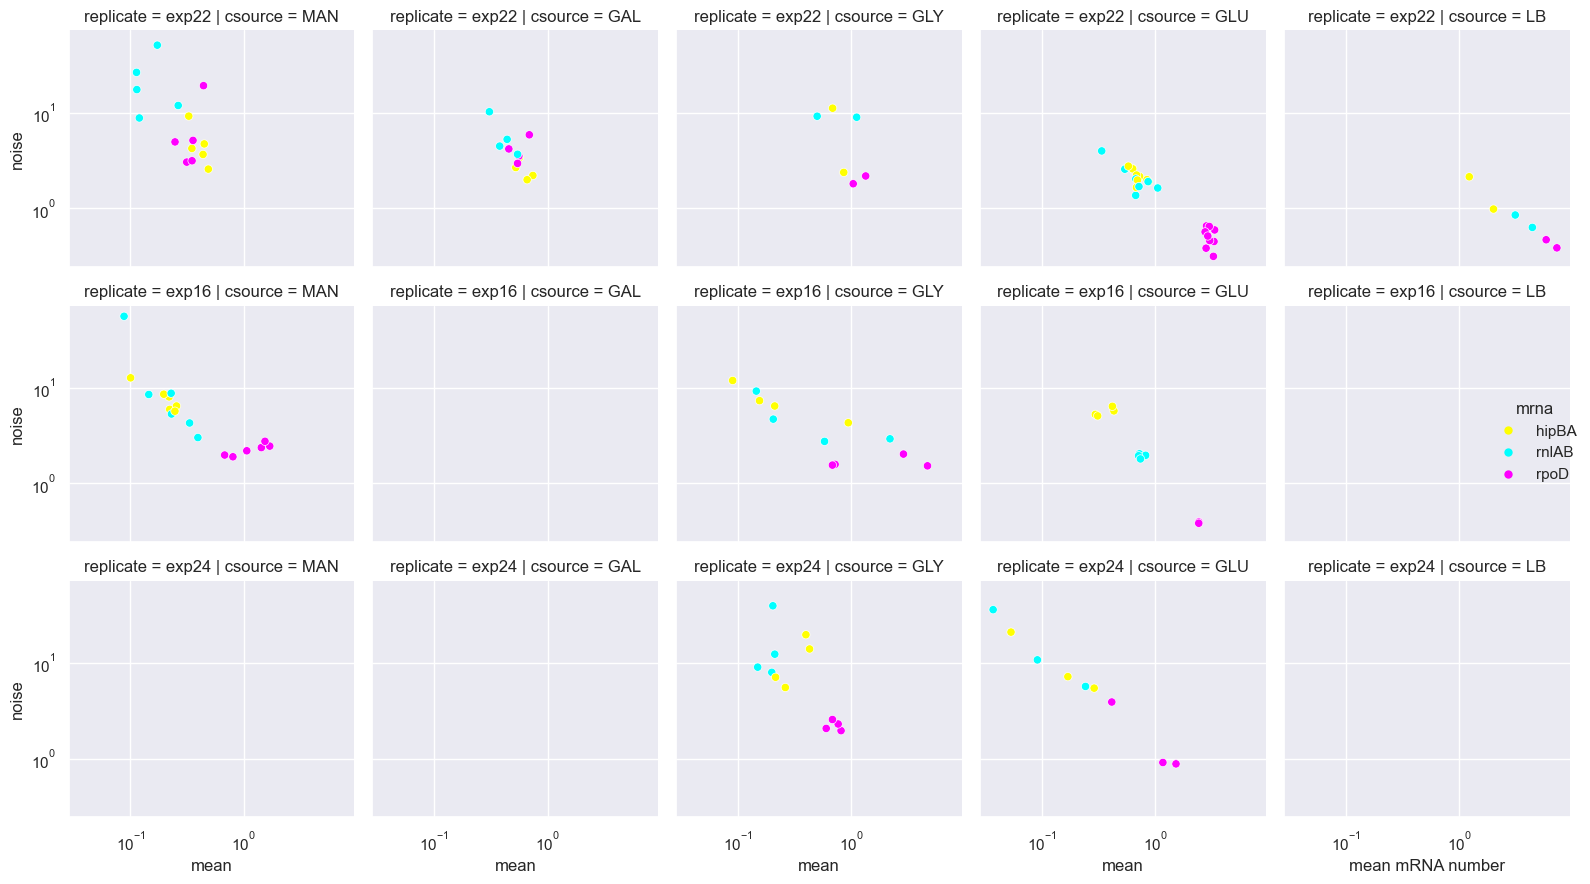

In [102]:
sns.relplot(frequencies, x='mean', y='noise', 
            col='csource', col_order=csources_ordered, 
            row='replicate', 
            hue='mrna', palette=palette_mrna,
            height=3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('mean mRNA number')
plt.ylabel('mRNA noise')
plt.tight_layout();

#### Mean number of spots/cell per image
This is just to check how consistent the data is across images.

##### QC plot

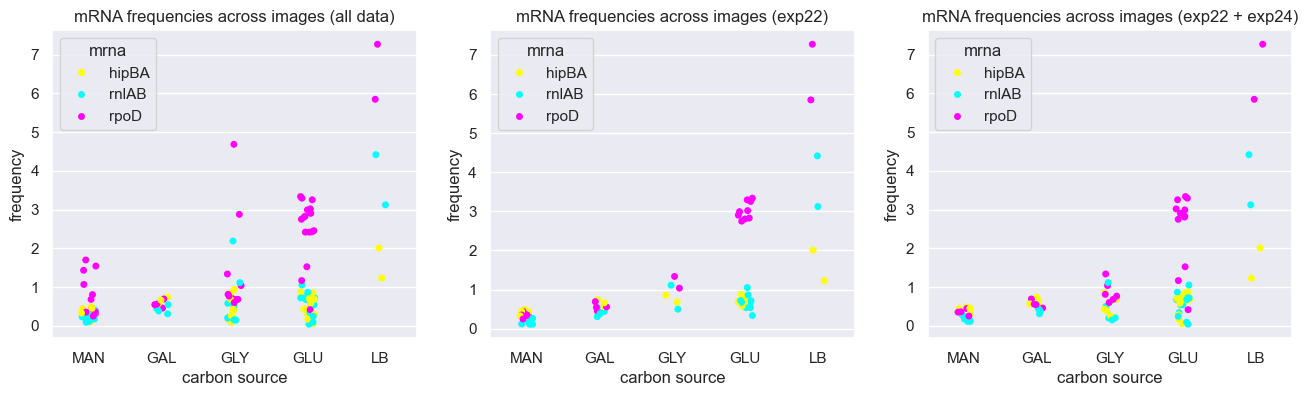

In [103]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
sns.stripplot(frequencies, x='csource', order=csources_ordered, y='mean', hue='mrna', palette=palette_mrna, ax=ax[0])
ax[0].set(title='mRNA frequencies across images (all data)', xlabel='carbon source', ylabel='frequency')
sns.stripplot(frequencies.query("replicate == 'exp22'"), x='csource', order=csources_ordered, y='mean', hue='mrna', palette=palette_mrna, ax=ax[1])
ax[1].set(title='mRNA frequencies across images (exp22)', xlabel='carbon source', ylabel='frequency')
sns.stripplot(frequencies.query("replicate != 'exp16'"), x='csource', order=csources_ordered, y='mean', hue='mrna', palette=palette_mrna, ax=ax[2])
ax[2].set(title='mRNA frequencies across images (exp22 + exp24)', xlabel='carbon source', ylabel='frequency');
# numbers need to be consistent across images within one condition

FileNotFoundError: [Errno 2] No such file or directory: '/Users/adele/Master/Projects/persisters/fig/analysis/QC/mean_expression_per_image_vs_condition.pdf'

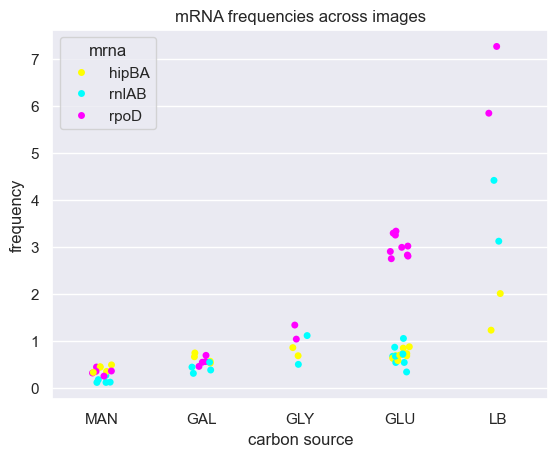

In [104]:
g = sns.stripplot(frequencies.query("replicate == 'exp22'"), x='csource', order=csources_ordered, y='mean', hue='mrna', palette=palette_mrna)
g.set(title='mRNA frequencies across images', xlabel='carbon source', ylabel='frequency')

savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/QC/mean_expression_per_image_vs_condition"
plt.savefig(savestem + ".pdf")
# numbers need to be consistent across images within one condition




#### Distribution facetted by csource and mRNA

Cell expression histograms per csource per mRNA = 
#spots/cell for csource, aggregated over all images for csource
[TODO] add the mean


##### Explo plot - all data

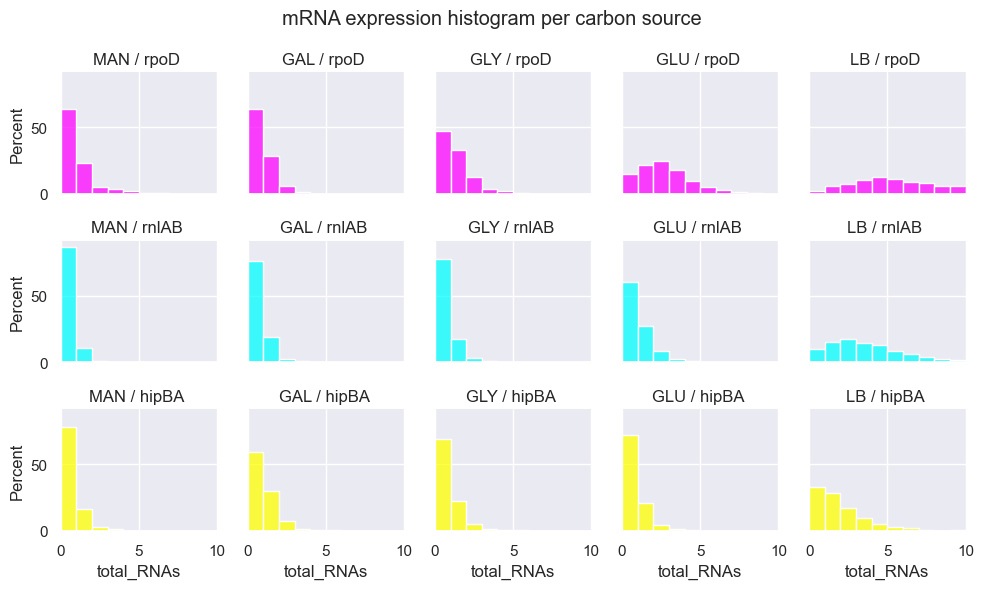

In [105]:
sns.set_style({"grid": False})
g = sns.FacetGrid(df_stacked, row='mrna', row_order=mrna_ordered, col='csource', col_order=csources_ordered,
                  xlim=(0, 10), sharex=True, sharey=True, hue='mrna', palette=palette_mrna, height=2);
g.map_dataframe(sns.histplot, x='total_RNAs', binwidth=1, stat='percent')
g.set_titles('{col_name} / {row_name} ');
g.fig.suptitle('mRNA expression histogram per carbon source')
g.tight_layout();

##### Demo plot - only exp22 data

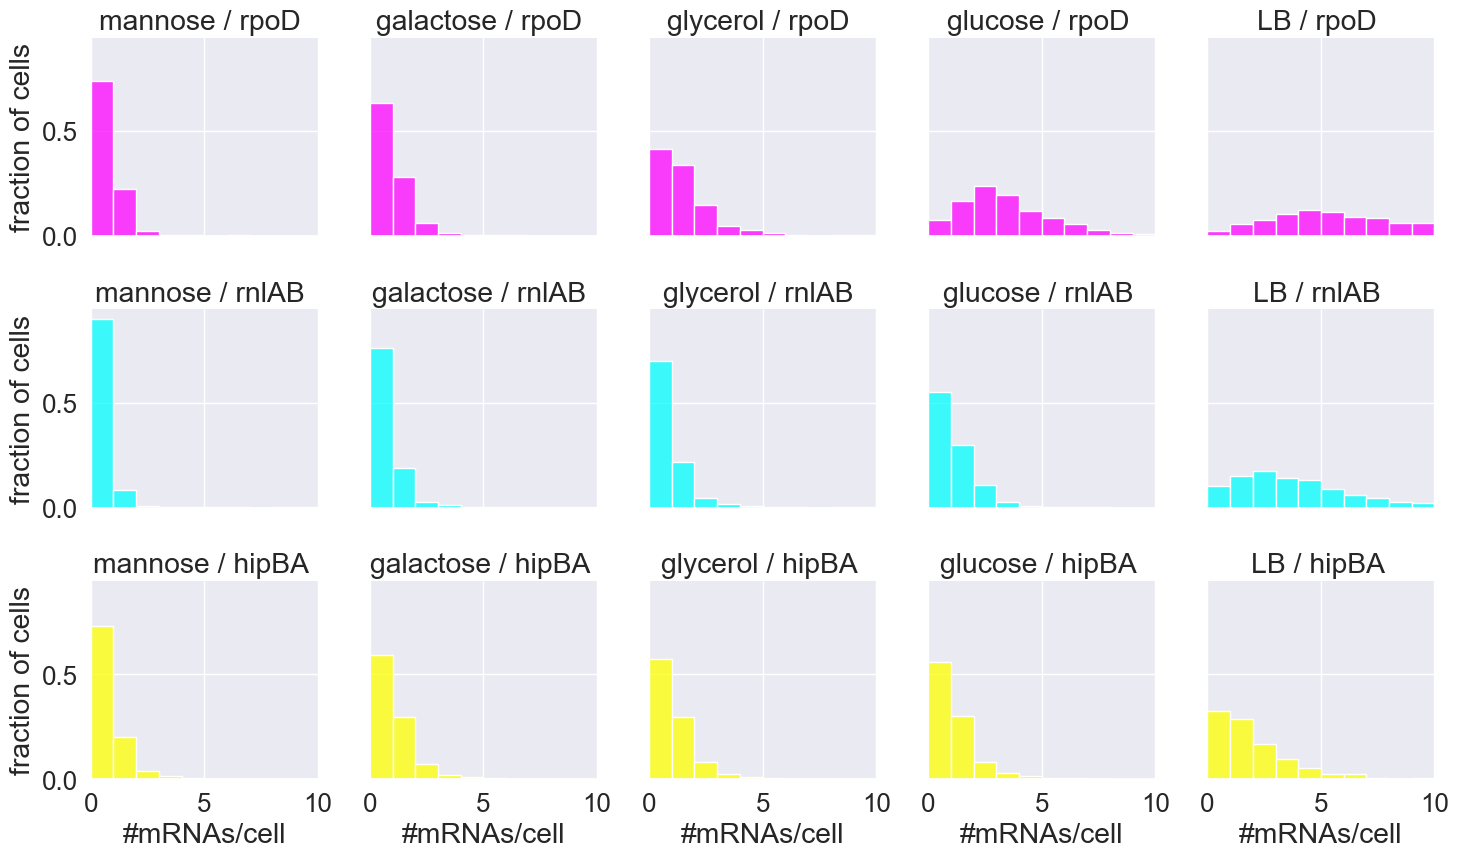

In [106]:
sns.set_style({"grid": True})
sns.set_style("darkgrid")
sns.set(font_scale=1.7)
# sns.set_style("whitegrid", {"axes.facecolor": "xkcd:darkblue", "grid.color": "xkcd:aubergine", "text.color": "black", "legend.facecolor": "white"})

data = df_stacked.query('replicate == "exp22"')
g = sns.FacetGrid(data, row='mrna', row_order=mrna_ordered, col='csource_d', col_order=csources_ordered_d,
                  xlim=(0, 10), sharex=True, sharey=True, hue='mrna', palette=palette_mrna, height=3);
g.map_dataframe(sns.histplot, x='total_RNAs', binwidth=1, stat='density')
g.set_xlabels('#mRNAs/cell')
g.set_ylabels('fraction of cells')
g.set_titles('{col_name} / {row_name} ');
# g.fig.suptitle('mRNA expression histogram per carbon source')
g.tight_layout();

savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/distribution_expression_vs_condition"
plt.savefig(savestem + ".pdf")

In [107]:
df_stacked.query('replicate == "exp22"').to_excel("/Users/adele/PycharmProjects/Ecoli_smFISH/smFISH_data_exp22.xlsx")

In [108]:
df_stacked.to_excel("/Users/adele/PycharmProjects/Ecoli_smFISH/smFISH_data.xlsx")

##### Demo plot - exp22 + exp24 data

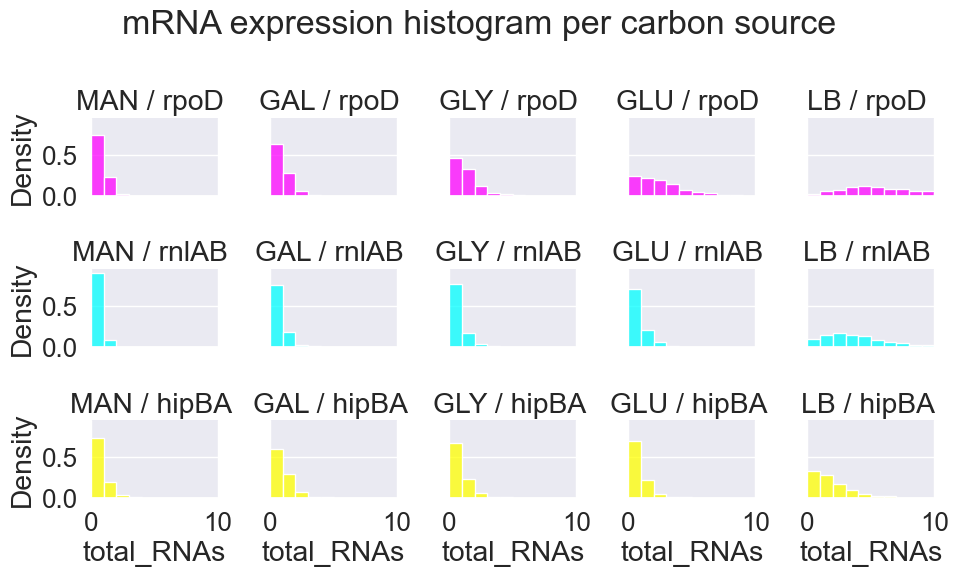

In [109]:
data = df_stacked.query('replicate != "exp16"')
g = sns.FacetGrid(data, row='mrna', row_order=mrna_ordered, col='csource', col_order=csources_ordered, 
                  xlim=(0, 10), sharex=True, sharey=True, hue='mrna', palette=palette_mrna, height=2);
g.map_dataframe(sns.histplot, x='total_RNAs', binwidth=1, stat='density')
g.set_titles('{col_name} / {row_name} ')
g.fig.suptitle('mRNA expression histogram per carbon source')
g.tight_layout();
# compare to the data from the Golding paper

In [110]:
data = df_stacked.query('replicate == "exp22"')
g = sns.FacetGrid(data, row='mrna', row_order=mrna_ordered, col='csource', col_order=csources_ordered, 
                  xlim=(0, 0.01), hue='mrna', palette=palette_mrna, height=2);
g.map_dataframe(sns.histplot, x='RNAs_over_length', binwidth=0.0001, stat='density')
g.set_titles('{col_name} / {row_name} ');
g.fig.suptitle('mRNA concentration histogram per carbon source')
g.tight_layout();

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x12668a660> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



Error in callback <function flush_figures at 0x140ae5300> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
data = df_stacked.query('replicate == "exp22"').query('RNAs_over_length > 0')
g = sns.FacetGrid(data, row='mrna', row_order=mrna_ordered, col='csource', col_order=csources_ordered, 
                  xlim=(0, 0.01), hue='mrna', palette=palette_mrna, height=2);
g.map_dataframe(sns.histplot, x='RNAs_over_area', binwidth=0.0003)
g.set_titles('{col_name} / {row_name} ');
g.fig.suptitle('mRNA concentration histogram per carbon source')
g.tight_layout();

In [ ]:
data = df_stacked.query('replicate == "exp22"').query('RNAs_over_length > 0')
g = sns.FacetGrid(data, row='mrna', row_order=mrna_ordered, col='csource', col_order=csources_ordered, 
                  xlim=(0, 0.01), hue='mrna', palette=palette_mrna, height=2);
g.map_dataframe(sns.histplot, x='RNAs_over_length', binwidth=0.003, stat='density')
g.set_titles('{col_name} / {row_name} ');
g.fig.suptitle('mRNA concentration histogram per carbon source')
g.tight_layout();

#### Distribution of number of spots

##### Explo plot

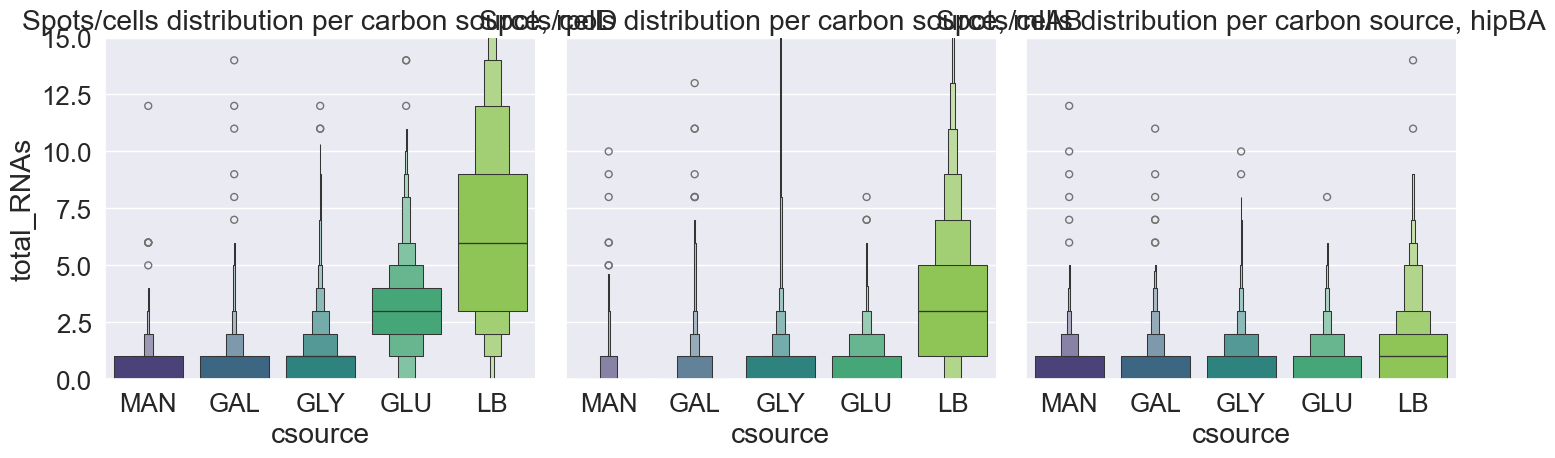

In [111]:
data=df_stacked.query('replicate == "exp22"')
g = sns.catplot(data=data, kind='boxen', x='csource', order=csources_ordered, y='total_RNAs', width_method='exponential', 
            col='mrna', col_order=mrna_ordered,
            hue='csource', palette=palette_csource)
g.set_titles('Spots/cells distribution per carbon source, {col_name}')
g.set(ylim=(0, 15));

#### Evolution of fraction of cells with n spots with growth rate

In [ ]:
dfs = []
for (mrna, csource) in product(mrna_ordered, csources_ordered):
    d = data.query('mrna == @mrna').query('csource == @csource')
    counts = np.bincount(d['total_RNAs'])
    df = pd.DataFrame({
        'mrna': mrna,
        'csource': csource,
        'rank': np.arange(len(counts)),
        'nr_cells_at_rank': np.bincount(d['total_RNAs']),
        'nr_cells_total': np.full_like(counts, d.shape[0]), 
    })
    # print(df)
    dfs.append(df)
histograms = pd.DataFrame(pd.concat(dfs))
histograms['frequency'] = histograms['nr_cells_at_rank'] / histograms['nr_cells_total']
histograms

##### Explo plot

In [ ]:
g = sns.relplot(data=histograms.query('rank < 4').query('csource != "LB"'), x='csource', y='frequency',
            col='rank', hue='mrna', palette=palette_mrna, kind='line', height=3)
g.set_titles('n={col_name} spots')
g.set(yscale="log")
g.fig.suptitle("Spot frequencies across condition")
plt.tight_layout();

### Expression versus cell features

#### Area

##### Plot - all data

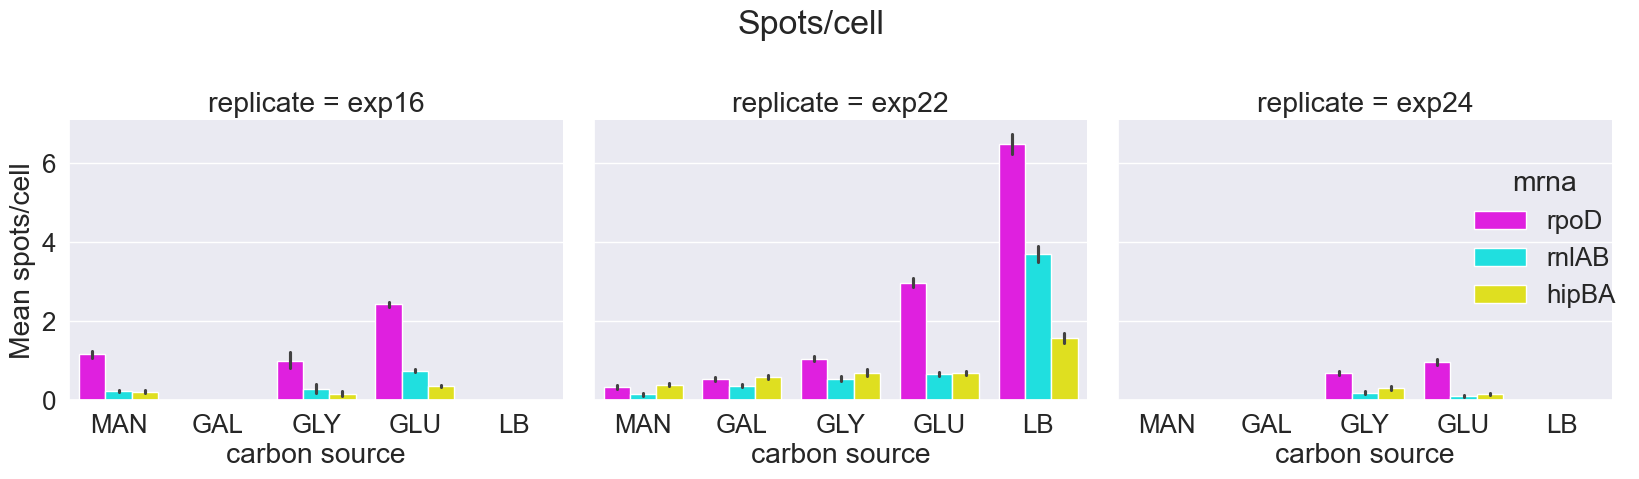

In [112]:
g = sns.catplot(df_stacked,
            col='replicate', col_order=replicates_ordered, 
            kind='bar', x='csource', order=csources_ordered, y='total_RNAs', hue='mrna', hue_order=mrna_ordered, palette=palette_mrna)
g.set(xlabel='carbon source', ylabel='Mean spots/cell')
g.fig.suptitle('Spots/cell')
plt.tight_layout();

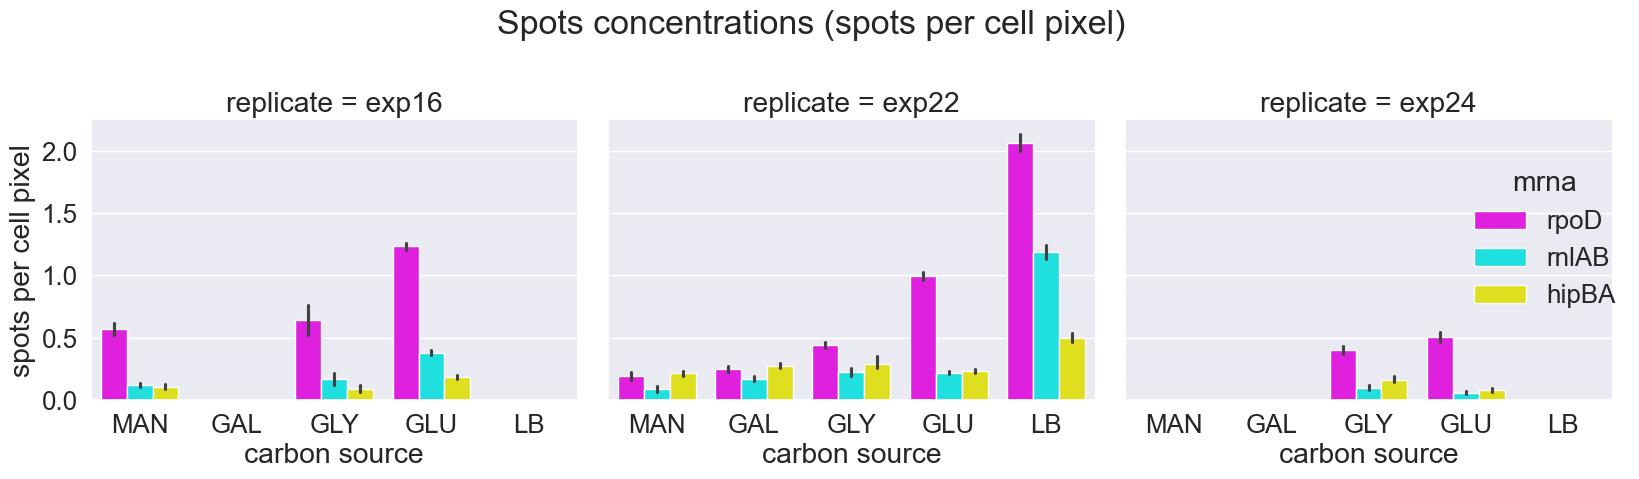

In [113]:
g = sns.catplot(df_stacked, kind='bar', 
            col='replicate', col_order=replicates_ordered, 
            x='csource', order=csources_ordered, y='RNAs_over_area', hue='mrna', hue_order=mrna_ordered, palette=palette_mrna)
g.set(xlabel='carbon source', ylabel='spots per cell pixel')
g.fig.suptitle('Spots concentrations (spots per cell pixel)')
plt.tight_layout();

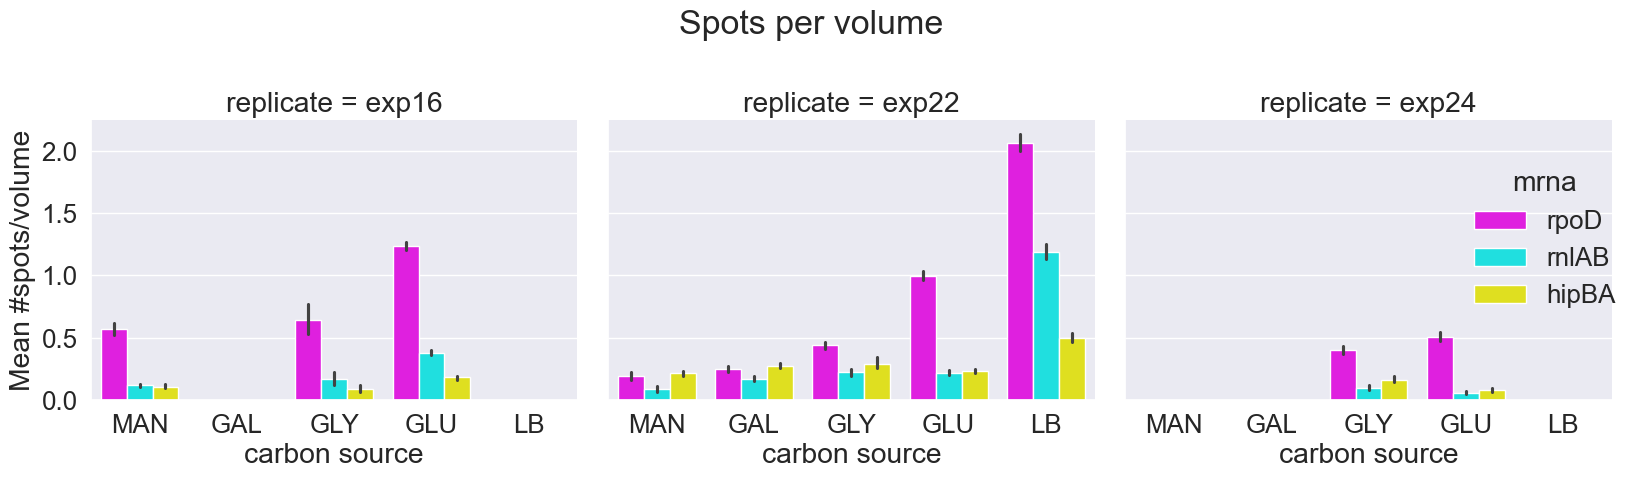

In [114]:
g = sns.catplot(df_stacked, kind='bar', 
            col='replicate', col_order=replicates_ordered, 
            x='csource', order=csources_ordered, y='RNAs_over_area', hue='mrna', hue_order=mrna_ordered, palette=palette_mrna)
g.set(xlabel='carbon source', ylabel='Mean #spots/volume')
g.fig.suptitle('Spots per volume')
plt.tight_layout();

In [115]:
df_stacked.columns

Index(['image_cell_id', 'spots', 'dense_regions', 'decomposed_RNAs', 'tx',
       'nascent_RNAs', 'total_RNAs', 'mrna', 'strain', 'condition', 'seqnr',
       'image', 'experiment', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'area',
       'eccentricity', 'axis_minor_length', 'axis_major_length', 'orientation',
       'perimeter', 'solidity', 'bbox-0_expanded', 'bbox-1_expanded',
       'bbox-2_expanded', 'bbox-3_expanded', 'area_expanded',
       'eccentricity_expanded', 'axis_minor_length_expanded',
       'axis_major_length_expanded', 'orientation_expanded',
       'perimeter_expanded', 'solidity_expanded', 'nuclei', 'csource',
       'coverslip', 'replicate', 'unique_cell_id', 'selected', 'volume',
       'volume_ellipsoid', 'RNAs_over_area', 'RNAs_over_vol',
       'RNAs_over_length', 'RNAs_over_eccentricity', 'mu', 'tau (h)',
       'tau (min)', 'csource_d', 'DNA_copy_number', 'total_RNAs_normalized1',
       'RNAs_over_length_normalized1', 'RNAs_over_area_normalized1',
       'RNAs

In [116]:
df_stacked.index

Index(['exp24.exp24-GLU-right-2_01.531.rpoD',
       'exp24.exp24-GLU-right-2_01.533.rpoD',
       'exp24.exp24-GLU-right-2_01.535.rpoD',
       'exp24.exp24-GLU-right-2_01.537.rpoD',
       'exp24.exp24-GLU-right-2_01.540.rpoD',
       'exp24.exp24-GLU-right-2_01.546.rpoD',
       'exp24.exp24-GLU-right-2_01.550.rpoD',
       'exp24.exp24-GLU-right-2_01.551.rpoD',
       'exp24.exp24-GLU-right-2_01.554.rpoD',
       'exp24.exp24-GLU-right-2_01.559.rpoD',
       ...
       'exp22.MG1655_LB_fixed2806_hybed1906_left_07.2150.hipBA',
       'exp22.MG1655_LB_fixed2806_hybed1906_left_07.2152.hipBA',
       'exp22.MG1655_LB_fixed2806_hybed1906_left_07.2157.hipBA',
       'exp22.MG1655_LB_fixed2806_hybed1906_left_07.2159.hipBA',
       'exp22.MG1655_LB_fixed2806_hybed1906_left_07.2160.hipBA',
       'exp22.MG1655_LB_fixed2806_hybed1906_left_07.2163.hipBA',
       'exp22.MG1655_LB_fixed2806_hybed1906_left_07.2166.hipBA',
       'exp22.MG1655_LB_fixed2806_hybed1906_left_07.2168.hipBA',
       'e

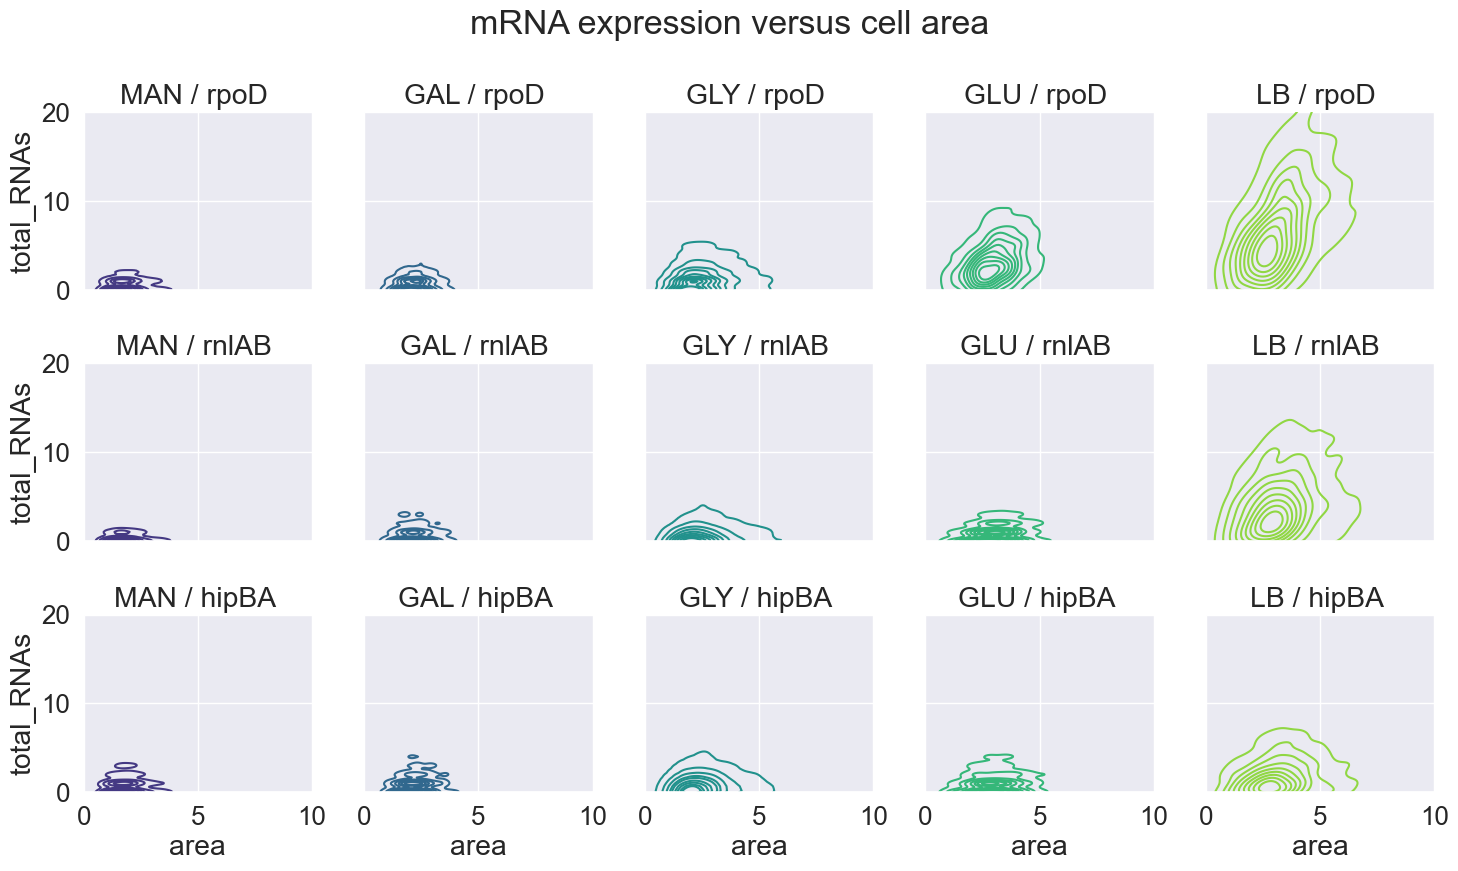

In [118]:
g = sns.FacetGrid(df_stacked.query('replicate == "exp22"'), 
                  row='mrna', row_order=mrna_ordered, 
                  col='csource', col_order=csources_ordered, 
                  xlim=(0, 10), ylim=(0, 20),
                  sharex=True, sharey=True, height=3);
g.map_dataframe(sns.kdeplot, y='total_RNAs', x='area', hue='csource', palette=palette_csource)
g.set_titles('{col_name} / {row_name} ');
g.fig.suptitle('mRNA expression versus cell area')
g.tight_layout();

#### Eccentricity / length

##### Plot - exp22 + exp24

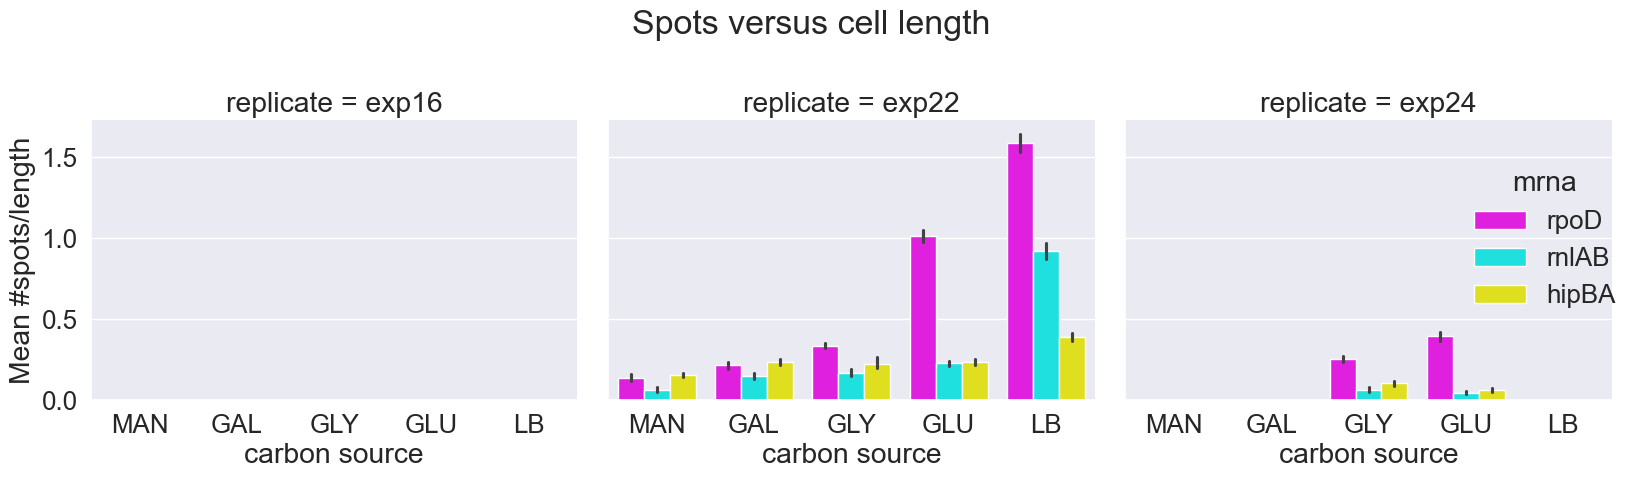

In [119]:
g = sns.catplot(df_stacked.query('replicate != "exp16"'), kind='bar', 
            col='replicate', col_order=replicates_ordered, 
            x='csource', order=csources_ordered, y='RNAs_over_length', hue='mrna', hue_order=mrna_ordered, palette=palette_mrna)
g.set(xlabel='carbon source', ylabel='Mean #spots/length')
g.fig.suptitle('Spots versus cell length')
plt.tight_layout();

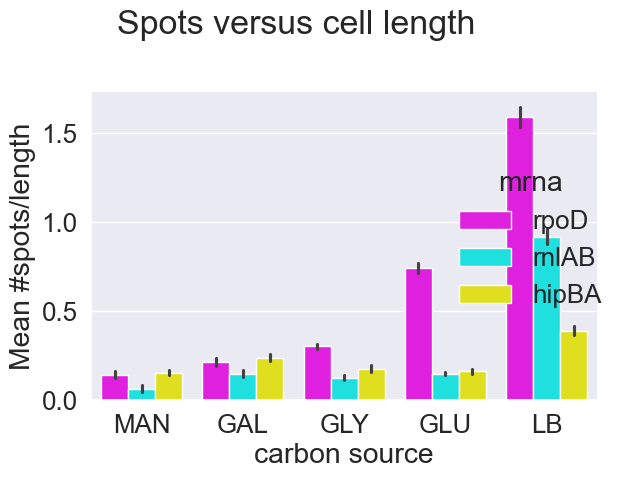

In [120]:
g = sns.catplot(df_stacked.query('replicate != "exp16"'), kind='bar', 
            x='csource', order=csources_ordered, y='RNAs_over_length', hue='mrna', hue_order=mrna_ordered, palette=palette_mrna)
g.set(xlabel='carbon source', ylabel='Mean #spots/length')
g.fig.suptitle('Spots versus cell length')
plt.tight_layout();

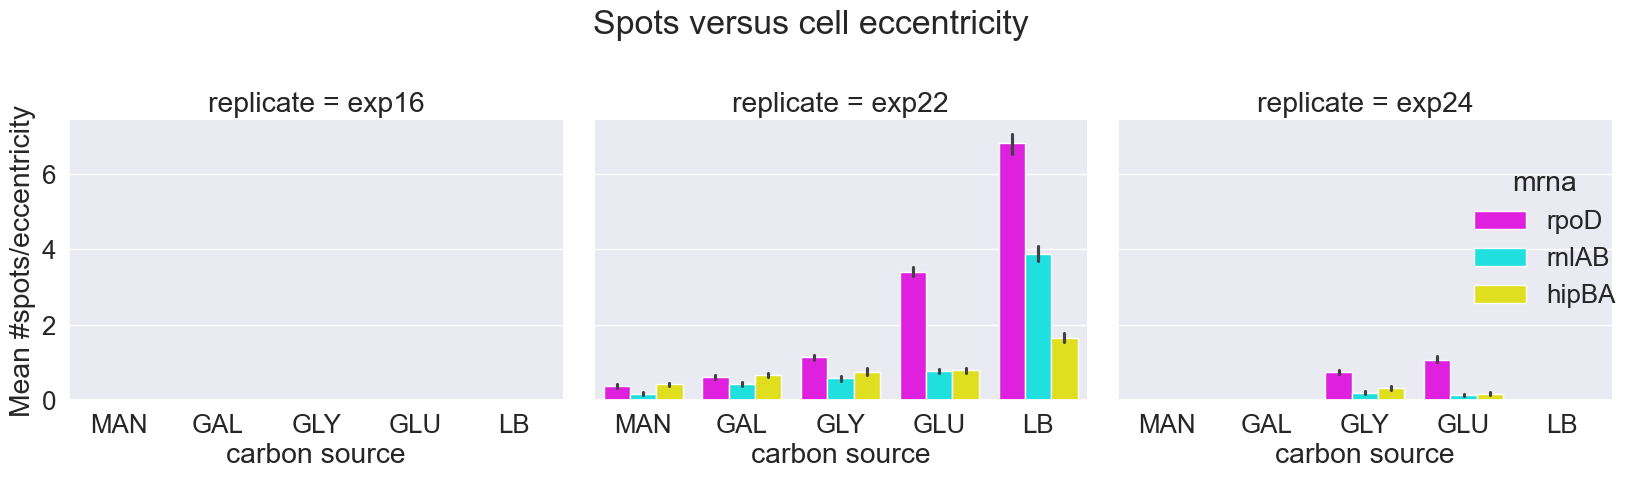

In [121]:
g = sns.catplot(df_stacked.query('replicate != "exp16"'), kind='bar', 
            col='replicate', col_order=replicates_ordered, 
            x='csource', order=csources_ordered, y='RNAs_over_eccentricity', hue='mrna', hue_order=mrna_ordered, palette=palette_mrna)
g.set(xlabel='carbon source', ylabel='Mean #spots/eccentricity')
g.fig.suptitle('Spots versus cell eccentricity')
plt.tight_layout();

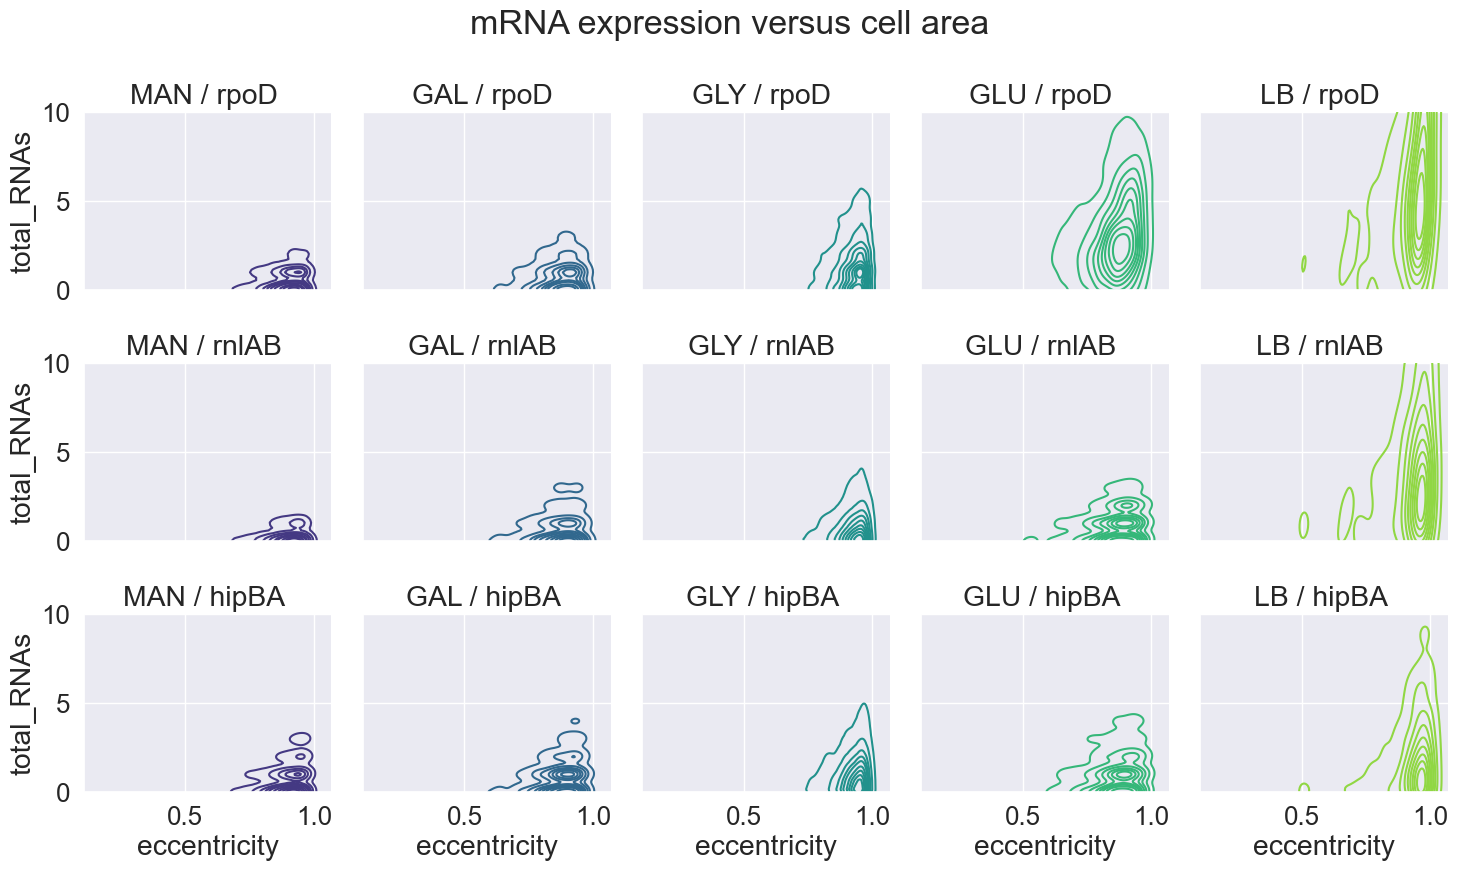

In [122]:
g = sns.FacetGrid(df_stacked.query('replicate == "exp22"'), 
                  row='mrna', row_order=mrna_ordered, 
                  col='csource', col_order=csources_ordered, 
                  ylim=(0, 10),
                  sharex=True, sharey=True, height=3);
g.map_dataframe(sns.kdeplot, y='total_RNAs', x='eccentricity', hue='csource', palette=palette_csource)
g.set_titles('{col_name} / {row_name} ');
g.fig.suptitle('mRNA expression versus cell area')
g.tight_layout();

#### RNAs versus nucleoids

In [123]:
df_records_sane = df_records.query('total_RNAs_rpoD < 20').query('total_RNAs_rnlAB < 10').query('total_RNAs_hipBA < 10')

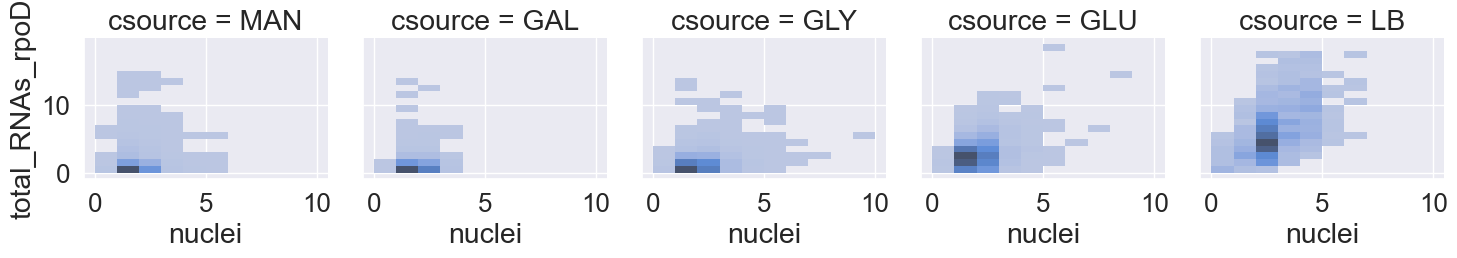

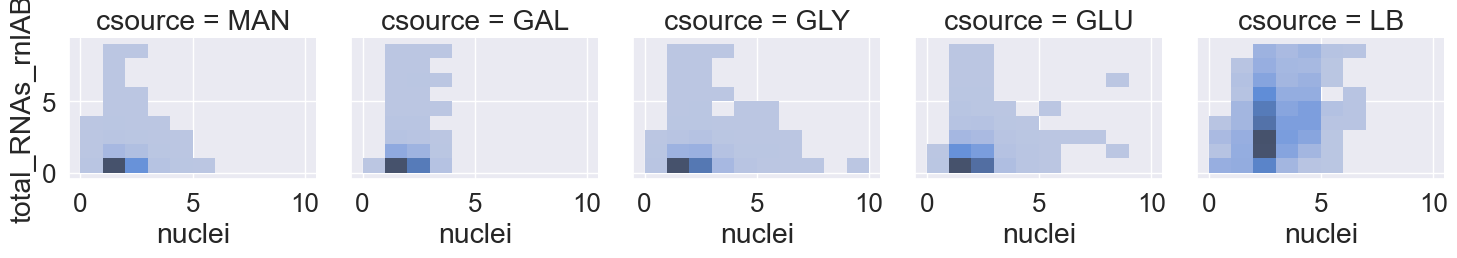

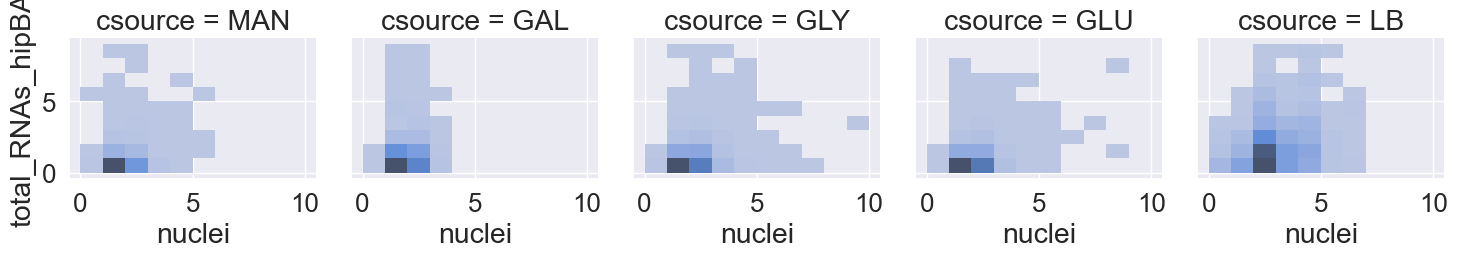

In [124]:
g1 =sns.FacetGrid(df_records_sane, col='csource', col_order=csources_ordered, sharex=True, sharey=True)
g1.map_dataframe(sns.histplot, y='total_RNAs_rpoD', x='nuclei', binwidth=1)

g2 = sns.FacetGrid(df_records_sane, col='csource', col_order=csources_ordered, sharex=True, sharey=True)
g2.map_dataframe(sns.histplot, y='total_RNAs_rnlAB', x='nuclei', binwidth=1)

g3 = sns.FacetGrid(df_records_sane, col='csource', col_order=csources_ordered, sharex=True, sharey=True)
g3.map_dataframe(sns.histplot, y='total_RNAs_hipBA', x='nuclei', binwidth=1);

12/12/2024 02:33:07PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 
12/12/2024 02:33:07PM [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. 


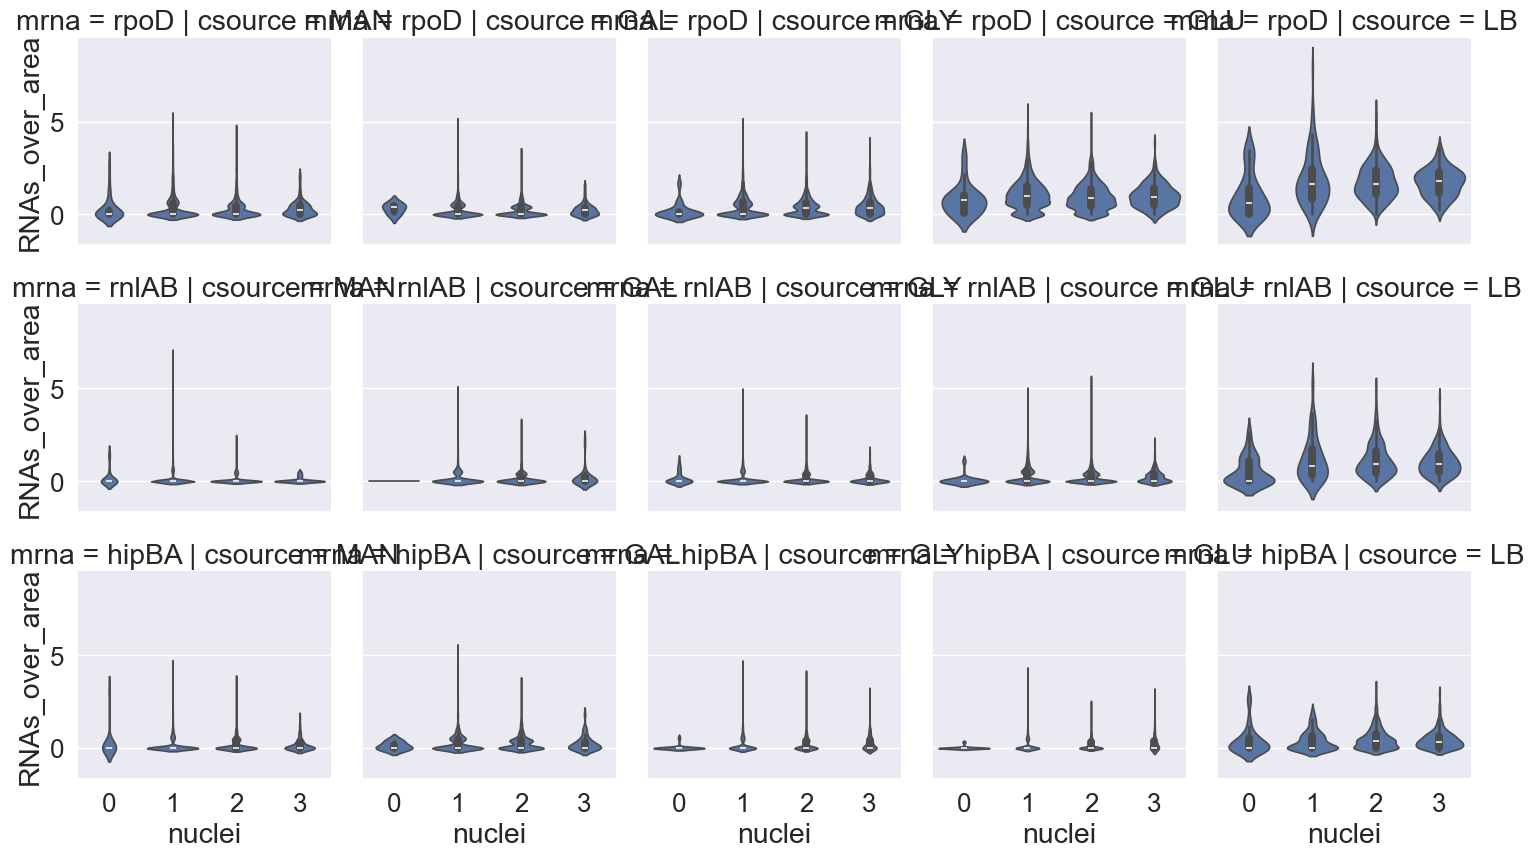

In [126]:

df_stacked_sane = df_stacked.query('total_RNAs < 10').query('nuclei < 4')
sns.catplot(data=df_stacked_sane, kind='violin', x='nuclei', y='RNAs_over_area',
            col='csource', col_order=csources_ordered,
            row='mrna', row_order=mrna_ordered, height=3)
# plt.ylim(0, 0.0125)

### Co-expression

#### 2D histograms

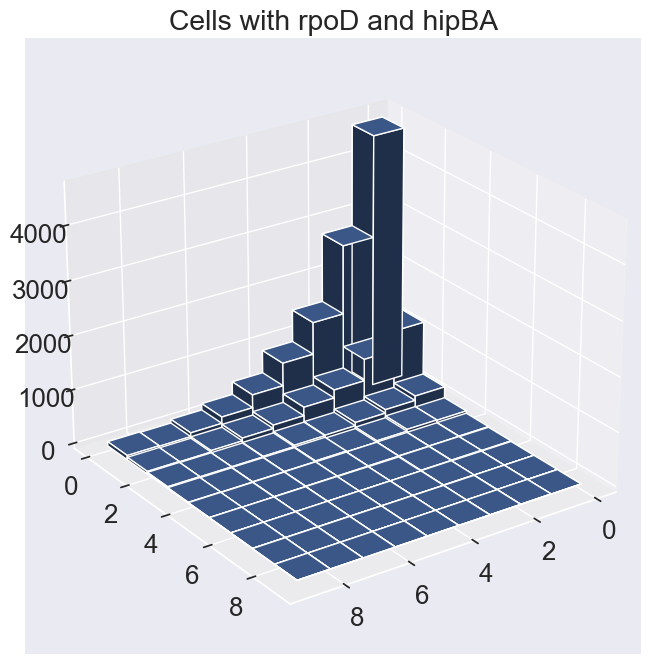

In [127]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
x, y = df_records_sane['total_RNAs_rpoD'], df_records_sane['total_RNAs_hipBA']
hist, xedges, yedges = np.histogram2d(y, x, bins=9, range=[[0, 9], [0, 9]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="xy")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 1
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
ax.view_init(25, 55)
plt.title("Cells with rpoD and hipBA")
plt.show()

In [128]:
df_records.columns

Index(['image_cell_id', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'area',
       'eccentricity', 'axis_minor_length', 'axis_major_length', 'orientation',
       'perimeter', 'solidity', 'bbox-0_expanded', 'bbox-1_expanded',
       'bbox-2_expanded', 'bbox-3_expanded', 'area_expanded',
       'eccentricity_expanded', 'axis_minor_length_expanded',
       'axis_major_length_expanded', 'orientation_expanded',
       'perimeter_expanded', 'solidity_expanded', 'nuclei', 'spots_hipBA',
       'dense_regions_hipBA', 'decomposed_RNAs_hipBA', 'tx_hipBA',
       'nascent_RNAs_hipBA', 'total_RNAs_hipBA', 'spots_rnlAB',
       'dense_regions_rnlAB', 'decomposed_RNAs_rnlAB', 'tx_rnlAB',
       'nascent_RNAs_rnlAB', 'total_RNAs_rnlAB', 'spots_rpoD',
       'dense_regions_rpoD', 'decomposed_RNAs_rpoD', 'tx_rpoD',
       'nascent_RNAs_rpoD', 'total_RNAs_rpoD', 'strain', 'condition', 'seqnr',
       'image', 'experiment', 'csource', 'coverslip', 'replicate',
       'unique_cell_id', 'selected', 'mu', 'tau

#### Density plots

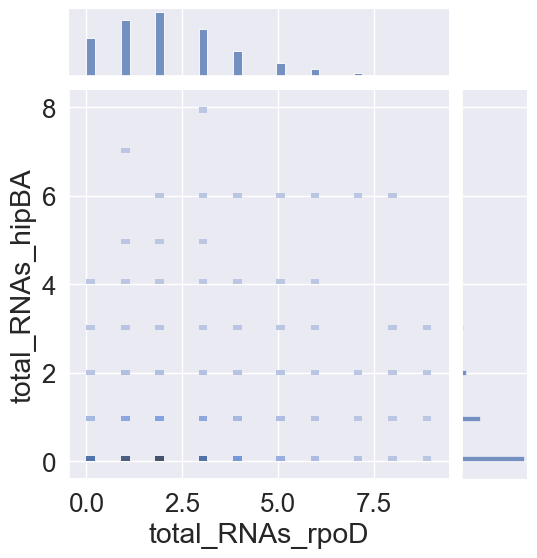

In [129]:
df_records_sane = df_records.query('total_RNAs_rpoD < 10').query('total_RNAs_rnlAB < 10').query('total_RNAs_hipBA < 10')
sns.jointplot(data=df_records_sane.query('csource == "GLU"'), x='total_RNAs_rpoD', y='total_RNAs_hipBA', kind='hist');

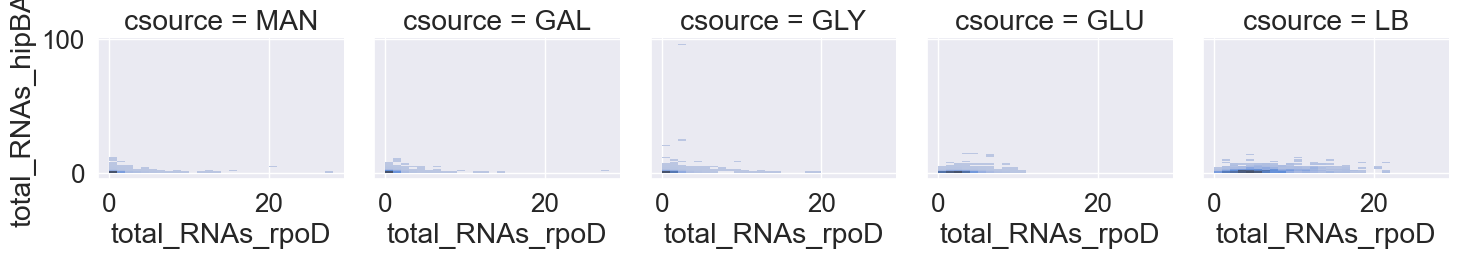

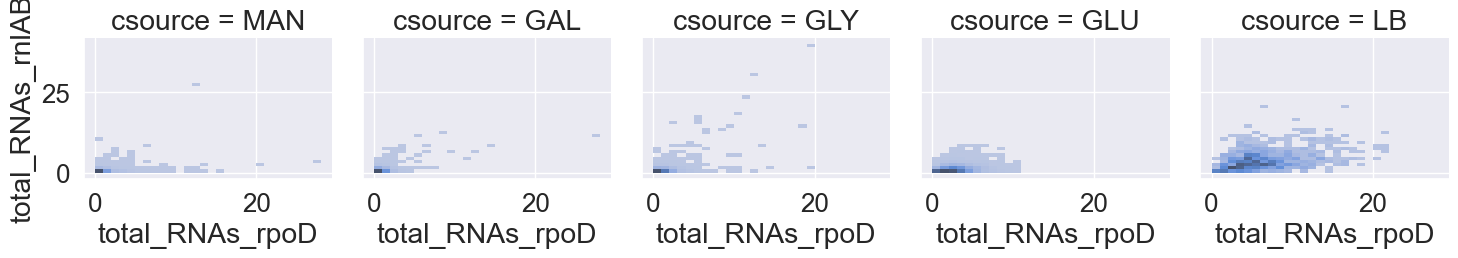

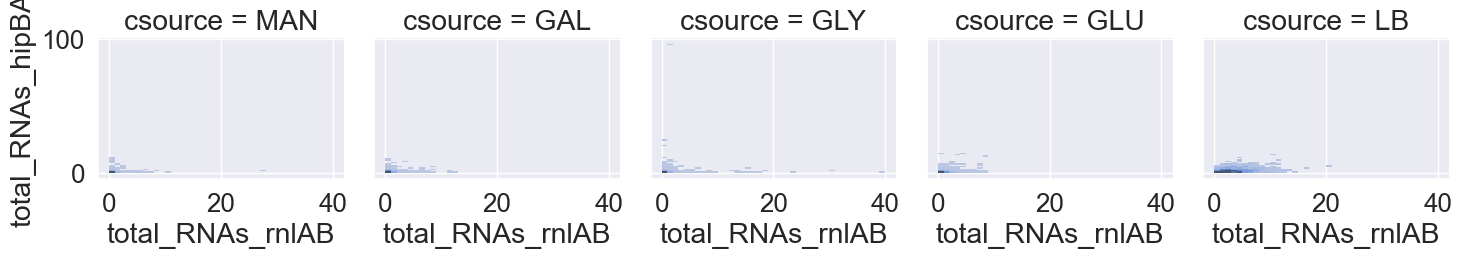

In [130]:
fill=True
data = df_records.query('volume < 17')
g1 = sns.FacetGrid(data, col='csource', col_order=csources_ordered, sharex=True, sharey=True)
g1.map_dataframe(sns.histplot, x='total_RNAs_rpoD', y='total_RNAs_hipBA', binwidth=1)

g2 = sns.FacetGrid(data, col='csource', col_order=csources_ordered, sharex=True, sharey=True)
g2.map_dataframe(sns.histplot, x='total_RNAs_rpoD', y='total_RNAs_rnlAB', binwidth=1)

g3 = sns.FacetGrid(data, col='csource', col_order=csources_ordered, sharex=True, sharey=True)
g3.map_dataframe(sns.histplot, x='total_RNAs_rnlAB', y='total_RNAs_hipBA', binwidth=1)
# heatmap with absolute numbers
# toxin vs toxin minus the non expressing cells
# do cells with zero rpoD have more TA


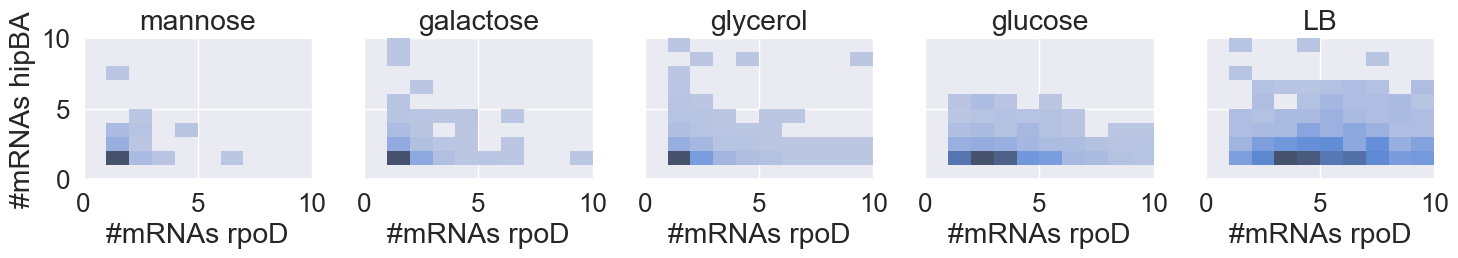

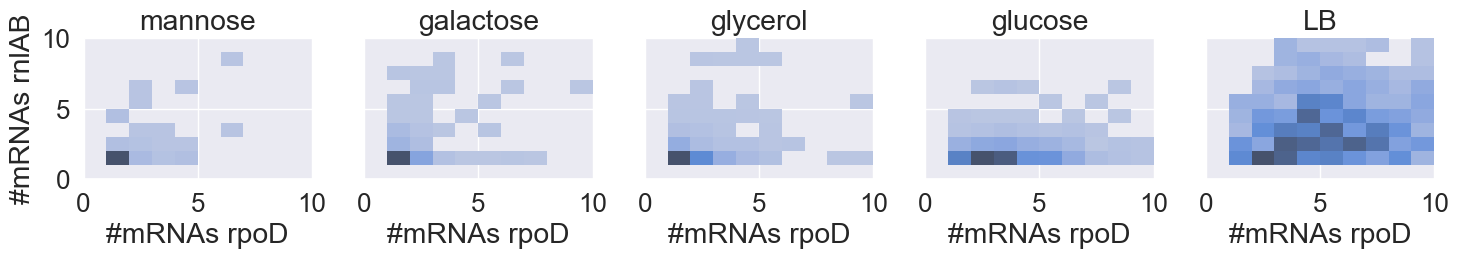

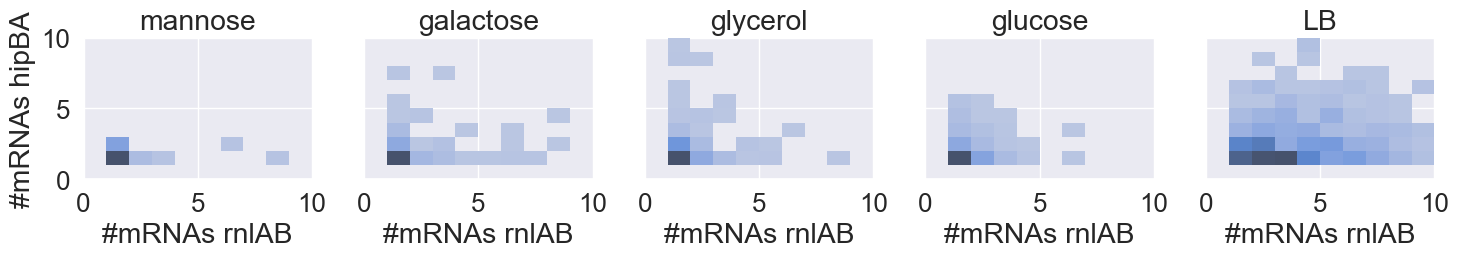

In [131]:
fill=True
data = df_records.query('volume < 17').query('replicate == "exp22"').query('csource != "lB"')
g1 = sns.FacetGrid(data.query('total_RNAs_rpoD > 0').query('total_RNAs_hipBA > 0'), col='csource_d', col_order=csources_ordered_d, sharex=True, sharey=True, xlim=(0, 10), ylim=(0, 10))
g1.map_dataframe(sns.histplot, x='total_RNAs_rpoD', y='total_RNAs_hipBA', binwidth=1)
g1.set_xlabels('#mRNAs rpoD')
g1.set_ylabels('#mRNAs hipBA')
g1.set_titles('{col_name}')

g2 = sns.FacetGrid(data.query('total_RNAs_rpoD > 0').query('total_RNAs_rnlAB > 0'), col='csource_d', col_order=csources_ordered_d, sharex=True, sharey=True, xlim=(0, 10), ylim=(0, 10))
g2.map_dataframe(sns.histplot, x='total_RNAs_rpoD', y='total_RNAs_rnlAB', binwidth=1)
g2.set_xlabels('#mRNAs rpoD')
g2.set_ylabels('#mRNAs rnlAB')
g2.set_titles('{col_name}')

g3 = sns.FacetGrid(data.query('total_RNAs_rnlAB > 0').query('total_RNAs_hipBA > 0'), col='csource_d', col_order=csources_ordered_d, sharex=True, sharey=True, xlim=(0, 10), ylim=(0, 10))
g3.map_dataframe(sns.histplot, x='total_RNAs_rnlAB', y='total_RNAs_hipBA', binwidth=1)
g3.set_xlabels('#mRNAs rnlAB')
g3.set_ylabels('#mRNAs hipBA')
g3.set_titles('{col_name}')

plt.tight_layout();

savestem = ("/Users/adele/Master/Projects/persisters/fig/analysis/histograms-2d")
plt.savefig(savestem + ".pdf")
plt.savefig(savestem + ".png", dpi=600)

# heatmap with absolute numbers
# toxin vs toxin minus the non expressing cells
# do cells with zero rpoD have more TA


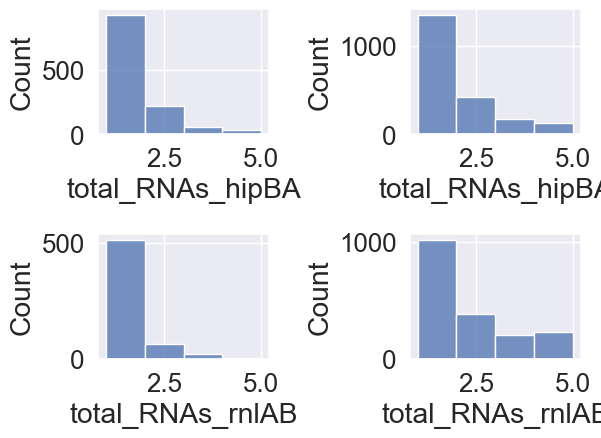

In [132]:
data = df_records.query('volume < 17').query('replicate == "exp22"').query('csource != "lB"')

fig, ax = plt.subplots(2, 2)
data_no_rpod = data.query('total_RNAs_rpoD == 0')
sns.histplot(data=data_no_rpod, x='total_RNAs_hipBA', binwidth=1, binrange=(1, 5), ax=ax[0][0])
sns.histplot(data=data_no_rpod, x='total_RNAs_rnlAB', binwidth=1, binrange=(1, 5), ax=ax[1][0])
data_rpod = data.query('total_RNAs_rpoD > 0')
sns.histplot(data=data_rpod, x='total_RNAs_hipBA', binwidth=1, binrange=(1, 5), ax=ax[0][1])
sns.histplot(data=data_rpod, x='total_RNAs_rnlAB', binwidth=1, binrange=(1, 5), ax=ax[1][1])
plt.tight_layout();


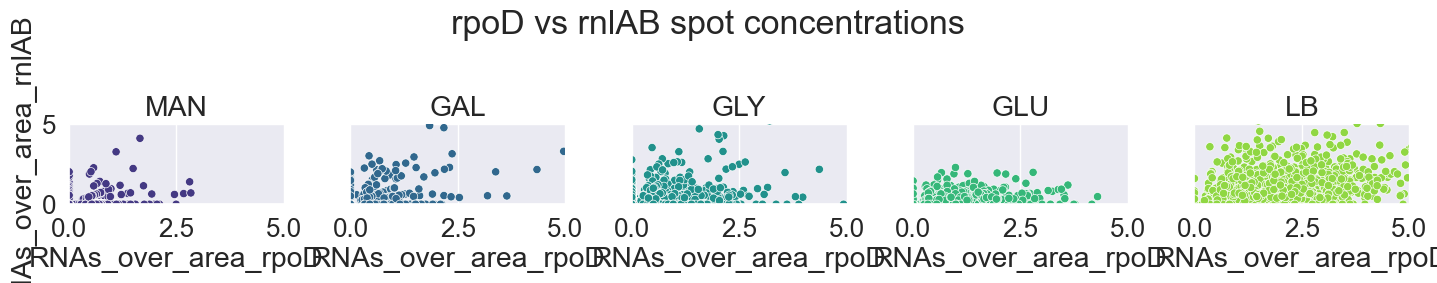

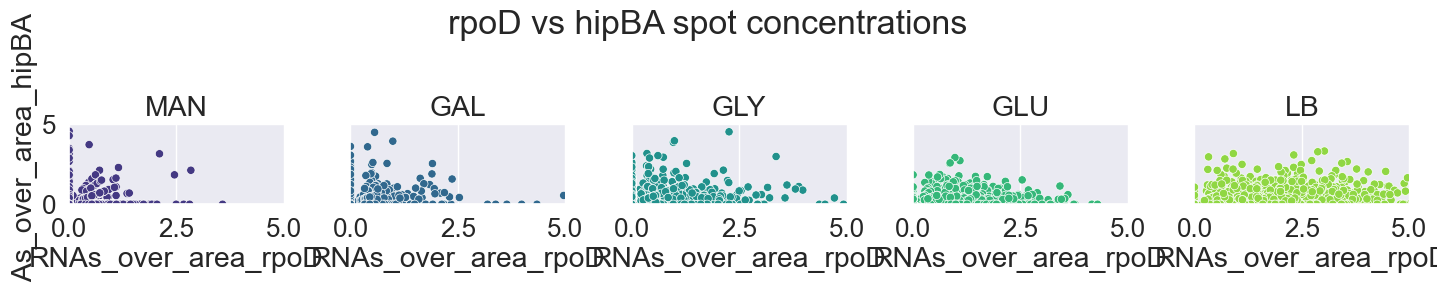

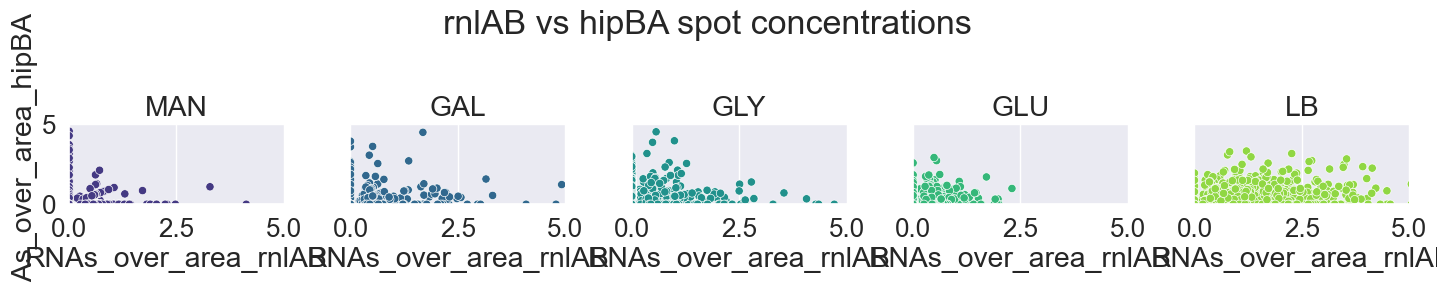

In [133]:
g = sns.FacetGrid(df_records.query('replicate == "exp22"'),
                  col='csource', col_order=csources_ordered,
                  xlim=(0, 5), ylim=(0, 5),
                  sharex=True, sharey=True, height=3);
g.map_dataframe(sns.scatterplot, x='RNAs_over_area_rpoD', y='RNAs_over_area_rnlAB', hue='csource', palette=palette_csource)
g.set_titles('{col_name}')
g.fig.suptitle('rpoD vs rnlAB spot concentrations')
g.tight_layout()
savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/coexpression-rpoD-rnlAB_exp22"
plt.savefig(savestem + ".pdf");

g = sns.FacetGrid(df_records.query('replicate == "exp22"'),
                  col='csource', col_order=csources_ordered,
                  xlim=(0, 5), ylim=(0, 5),
                  sharex=True, sharey=True, height=3);
g.map_dataframe(sns.scatterplot, x='RNAs_over_area_rpoD', y='RNAs_over_area_hipBA', hue='csource', palette=palette_csource)
g.set_titles('{col_name}');
g.fig.suptitle('rpoD vs hipBA spot concentrations')
g.tight_layout()
savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/coexpression-rpoD-hipBA_exp22"
plt.savefig(savestem + ".pdf");

g = sns.FacetGrid(df_records.query('replicate == "exp22"'),
                  col='csource', col_order=csources_ordered,
                  xlim=(0, 5), ylim=(0, 5),
                  sharex=True, sharey=True, height=3);
g.map_dataframe(sns.scatterplot, x='RNAs_over_area_rnlAB', y='RNAs_over_area_hipBA', hue='csource', palette=palette_csource)
g.set_titles('{col_name}');
g.fig.suptitle('rnlAB vs hipBA spot concentrations')
g.tight_layout()
savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/coexpression-rnlAB-hipBA_exp22"
plt.savefig(savestem + ".pdf");

In [134]:
df_records.columns

Index(['image_cell_id', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'area',
       'eccentricity', 'axis_minor_length', 'axis_major_length', 'orientation',
       'perimeter', 'solidity', 'bbox-0_expanded', 'bbox-1_expanded',
       'bbox-2_expanded', 'bbox-3_expanded', 'area_expanded',
       'eccentricity_expanded', 'axis_minor_length_expanded',
       'axis_major_length_expanded', 'orientation_expanded',
       'perimeter_expanded', 'solidity_expanded', 'nuclei', 'spots_hipBA',
       'dense_regions_hipBA', 'decomposed_RNAs_hipBA', 'tx_hipBA',
       'nascent_RNAs_hipBA', 'total_RNAs_hipBA', 'spots_rnlAB',
       'dense_regions_rnlAB', 'decomposed_RNAs_rnlAB', 'tx_rnlAB',
       'nascent_RNAs_rnlAB', 'total_RNAs_rnlAB', 'spots_rpoD',
       'dense_regions_rpoD', 'decomposed_RNAs_rpoD', 'tx_rpoD',
       'nascent_RNAs_rpoD', 'total_RNAs_rpoD', 'strain', 'condition', 'seqnr',
       'image', 'experiment', 'csource', 'coverslip', 'replicate',
       'unique_cell_id', 'selected', 'mu', 'tau

#### Fraction of cells with two RNAs

In [135]:
data = df_records.query('replicate == "exp22"')

In [136]:
#  same content as cell below, just easier to check
df_counts = pd.DataFrame({
    'total': data.groupby('csource').size().reindex(csources_ordered),
    'rpoD': data.query('spots_rpoD > 0').groupby('csource').size().reindex(csources_ordered),
    'rnlAB': data.query('spots_rnlAB > 0').groupby('csource').size().reindex(csources_ordered),
    'hipBA': data.query('spots_hipBA > 0').groupby('csource').size().reindex(csources_ordered),
    'rnlAB&hipBA': data.query('spots_rnlAB > 0').query('spots_hipBA > 0').groupby('csource').size().reindex(csources_ordered),
    'rnlAB&rpoD': data.query('spots_rnlAB > 0').query('spots_rpoD > 0').groupby('csource').size().reindex(csources_ordered),
    'hipBA&rpoD': data.query('spots_hipBA > 0').query('spots_rpoD > 0').groupby('csource').size().reindex(csources_ordered),
})

df_counts['%rpoD'] = df_counts['rpoD'] / df_counts['total']
df_counts['%rnlAB'] = df_counts['rnlAB'] / df_counts['total']
df_counts['%hipBA'] = df_counts['hipBA'] / df_counts['total']
df_counts['%rnlAB*%hipBA'] = df_counts['%rnlAB'] * df_counts['%hipBA']
df_counts['%rnlAB&hipBA'] = df_counts['rnlAB&hipBA'] / df_counts['total']
df_counts['%rnlAB&rpoD'] = df_counts['rnlAB&rpoD'] / df_counts['total']
df_counts['%hipBA&rpoD'] = df_counts['hipBA&rpoD'] / df_counts['total']
# df_counts = df_counts[['total', 'rpoD', '%rpoD', 'hipBA', '%hipBA', 'rnlAB', '%rnlAB', '%rnlAB*%hipBA', '%rnlAB&hipBA', '%rnlAB&rpoD', '%hipBA&rpoD']]
df_counts

total  rpoD  rnlAB  hipBA  rnlAB&hipBA  rnlAB&rpoD  hipBA&rpoD  \
csource                                                                   
MAN       1885   489    187    508           57          83         156   
GAL       1955   717    471    797          213         214         310   
GLY       2405  1406    721   1024          349         502         627   
GLU       1399  1291    629    619          296         591         578   
LB         997   976    894    671          625         888         665   

         %rpoD  %rnlAB  %hipBA  %rnlAB*%hipBA  %rnlAB&hipBA  %rnlAB&rpoD  \
csource                                                                    
MAN       0.26    0.10    0.27           0.03          0.03         0.04   
GAL       0.37    0.24    0.41           0.10          0.11         0.11   
GLY       0.58    0.30    0.43           0.13          0.15         0.21   
GLU       0.92    0.45    0.44           0.20          0.21         0.42   
LB        0.98    0.90    0.67           0.60          0.63         0.89   

         %hipBA&rpoD  
csource               
MAN             0.08  
GAL             0.16  
GLY             0.26  
GLU             0.41  
LB              0.67

In [137]:
#  same content as cell below, just easier to check
df_counts = pd.DataFrame({
    'total': data.groupby('csource').size().reindex(csources_ordered),
    'rpoD': data.query('spots_rpoD > 0').groupby('csource').size().reindex(csources_ordered),
    'rnlAB': data.query('spots_rnlAB > 0').groupby('csource').size().reindex(csources_ordered),
    'hipBA': data.query('spots_hipBA > 0').groupby('csource').size().reindex(csources_ordered),
    'rnlAB&hipBA': data.query('spots_rnlAB > 0').query('spots_hipBA > 0').groupby('csource').size().reindex(csources_ordered),
    'rnlAB&rpoD': data.query('spots_rnlAB > 0').query('spots_rpoD > 0').groupby('csource').size().reindex(csources_ordered),
    'hipBA&rpoD': data.query('spots_hipBA > 0').query('spots_rpoD > 0').groupby('csource').size().reindex(csources_ordered),
})

df_counts['%rpoD'] = df_counts['rpoD'] / df_counts['total']
df_counts['%rnlAB'] = df_counts['rnlAB'] / df_counts['total']
df_counts['%hipBA'] = df_counts['hipBA'] / df_counts['total']
df_counts['%rnlAB*%hipBA'] = df_counts['%rnlAB'] * df_counts['%hipBA']
df_counts['%rnlAB&hipBA'] = df_counts['rnlAB&hipBA'] / df_counts['total']
df_counts['%rnlAB&rpoD'] = df_counts['rnlAB&rpoD'] / df_counts['total']
df_counts['%hipBA&rpoD'] = df_counts['hipBA&rpoD'] / df_counts['total']
# df_counts = df_counts[['total', 'rpoD', '%rpoD', 'hipBA', '%hipBA', 'rnlAB', '%rnlAB', '%rnlAB*%hipBA', '%rnlAB&hipBA', '%rnlAB&rpoD', '%hipBA&rpoD']]
df_counts

total  rpoD  rnlAB  hipBA  rnlAB&hipBA  rnlAB&rpoD  hipBA&rpoD  \
csource                                                                   
MAN       1885   489    187    508           57          83         156   
GAL       1955   717    471    797          213         214         310   
GLY       2405  1406    721   1024          349         502         627   
GLU       1399  1291    629    619          296         591         578   
LB         997   976    894    671          625         888         665   

         %rpoD  %rnlAB  %hipBA  %rnlAB*%hipBA  %rnlAB&hipBA  %rnlAB&rpoD  \
csource                                                                    
MAN       0.26    0.10    0.27           0.03          0.03         0.04   
GAL       0.37    0.24    0.41           0.10          0.11         0.11   
GLY       0.58    0.30    0.43           0.13          0.15         0.21   
GLU       0.92    0.45    0.44           0.20          0.21         0.42   
LB        0.98    0.90    0.67           0.60          0.63         0.89   

         %hipBA&rpoD  
csource               
MAN             0.08  
GAL             0.16  
GLY             0.26  
GLU             0.41  
LB              0.67

In [138]:
all_frequencies = pd.DataFrame()

total_cells = data.groupby('csource').size().reindex(csources_ordered)

for mrna in ['rpoD', 'rnlAB', 'hipBA']:
    df_mrna = pd.DataFrame({'counts': data.query(f'spots_{mrna} > 0').groupby('csource').size().reindex(csources_ordered)})
    df_mrna['mrna_set'] = mrna
    df_mrna['cardinality'] = 1
    df_mrna['total'] = total_cells
    df_mrna['fraction'] = df_mrna['counts'] / df_mrna['total']
    
    all_frequencies = pd.concat([all_frequencies, df_mrna])
    
for mrna_pair in combinations(['rpoD', 'rnlAB', 'hipBA'], 2):
    df_mrna = pd.DataFrame({'counts': data.query(f'spots_{mrna_pair[0]} > 0').query(f'spots_{mrna_pair[1]} > 0').groupby('csource').size().reindex(csources_ordered)})
    df_mrna['mrna_set'] = mrna_pair[0] + '_' + mrna_pair[1]
    df_mrna['cardinality'] = 2
    df_mrna['total'] = total_cells
    df_mrna['fraction'] = df_mrna['counts'] / df_mrna['total']
    df_mrna['expected'] = all_frequencies.query('mrna_set == @mrna_pair[0]')['fraction'] * all_frequencies.query('mrna_set == @mrna_pair[1]')['fraction']
    
    all_frequencies = pd.concat([all_frequencies, df_mrna])
    
for mrna_pair in combinations(['rpoD', 'rnlAB', 'hipBA'], 3):
    df_mrna = pd.DataFrame({'counts': data.query(f'spots_{mrna_pair[0]} > 0').query(f'spots_{mrna_pair[1]} > 0').query(f'spots_{mrna_pair[2]} > 0').groupby('csource').size().reindex(csources_ordered)})
    df_mrna['mrna_set'] = mrna_pair[0] + '_' + mrna_pair[1] + '_' + mrna_pair[2]
    df_mrna['cardinality'] = 3
    df_mrna['total'] = total_cells
    df_mrna['fraction'] = df_mrna['counts'] / df_mrna['total']
    df_mrna['expected'] = all_frequencies.query('mrna_set == @mrna_pair[0]')['fraction'] * all_frequencies.query('mrna_set == @mrna_pair[1]')['fraction'] * all_frequencies.query('mrna_set == @mrna_pair[2]')['fraction']

    all_frequencies = pd.concat([all_frequencies, df_mrna])
    
all_frequencies

counts          mrna_set  cardinality  total  fraction  expected
csource                                                                  
MAN         489              rpoD            1   1885      0.26       NaN
GAL         717              rpoD            1   1955      0.37       NaN
GLY        1406              rpoD            1   2405      0.58       NaN
GLU        1291              rpoD            1   1399      0.92       NaN
LB          976              rpoD            1    997      0.98       NaN
MAN         187             rnlAB            1   1885      0.10       NaN
GAL         471             rnlAB            1   1955      0.24       NaN
GLY         721             rnlAB            1   2405      0.30       NaN
GLU         629             rnlAB            1   1399      0.45       NaN
LB          894             rnlAB            1    997      0.90       NaN
MAN         508             hipBA            1   1885      0.27       NaN
GAL         797             hipBA            1   1955      0.41       NaN
GLY        1024             hipBA            1   2405      0.43       NaN
GLU         619             hipBA            1   1399      0.44       NaN
LB          671             hipBA            1    997      0.67       NaN
MAN          83        rpoD_rnlAB            2   1885      0.04  2.57e-02
GAL         214        rpoD_rnlAB            2   1955      0.11  8.84e-02
GLY         502        rpoD_rnlAB            2   2405      0.21  1.75e-01
GLU         591        rpoD_rnlAB            2   1399      0.42  4.15e-01
LB          888        rpoD_rnlAB            2    997      0.89  8.78e-01
MAN         156        rpoD_hipBA            2   1885      0.08  6.99e-02
GAL         310        rpoD_hipBA            2   1955      0.16  1.50e-01
GLY         627        rpoD_hipBA            2   2405      0.26  2.49e-01
GLU         578        rpoD_hipBA            2   1399      0.41  4.08e-01
LB          665        rpoD_hipBA            2    997      0.67  6.59e-01
MAN          57       rnlAB_hipBA            2   1885      0.03  2.67e-02
GAL         213       rnlAB_hipBA            2   1955      0.11  9.82e-02
GLY         349       rnlAB_hipBA            2   2405      0.15  1.28e-01
GLU         296       rnlAB_hipBA            2   1399      0.21  1.99e-01
LB          625       rnlAB_hipBA            2    997      0.63  6.03e-01
MAN          35  rpoD_rnlAB_hipBA            3   1885      0.02  6.94e-03
GAL         101  rpoD_rnlAB_hipBA            3   1955      0.05  3.60e-02
GLY         243  rpoD_rnlAB_hipBA            3   2405      0.10  7.46e-02
GLU         281  rpoD_rnlAB_hipBA            3   1399      0.20  1.84e-01
LB          621  rpoD_rnlAB_hipBA            3    997      0.62  5.91e-01

##### Plot - all data

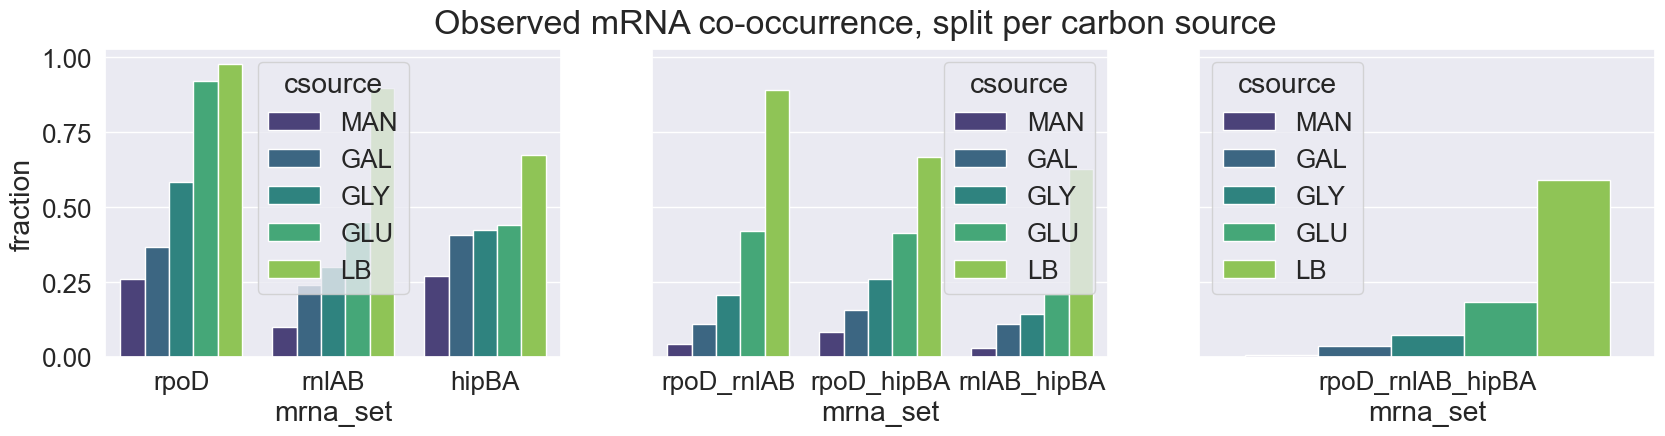

In [139]:
sns.set_style("darkgrid")

fig, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
fig.suptitle('Observed mRNA co-occurrence, split per carbon source')

g = sns.barplot(all_frequencies.query('cardinality == 1'), x='mrna_set', y='fraction', hue='csource', palette=palette_csource, ax=ax[0])
g = sns.barplot(all_frequencies.query('cardinality == 2'), x='mrna_set', y='fraction', hue='csource', palette=palette_csource, ax=ax[1])
g = sns.barplot(all_frequencies.query('cardinality == 3'), x='mrna_set', y='expected', hue='csource', palette=palette_csource, ax=ax[2])

##### Plot - only exp22 data

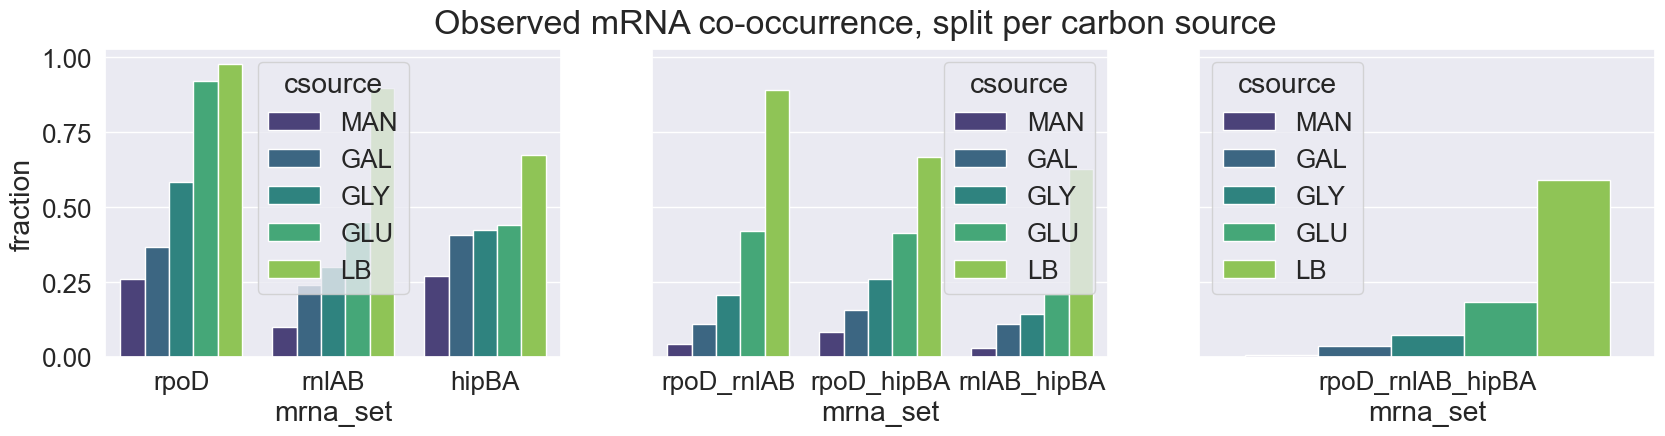

In [140]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
fig.suptitle('Observed mRNA co-occurrence, split per carbon source')

g = sns.barplot(all_frequencies.query('cardinality == 1'), x='mrna_set', y='fraction', hue='csource', palette=palette_csource, ax=ax[0])
g = sns.barplot(all_frequencies.query('cardinality == 2'), x='mrna_set', y='fraction', hue='csource', palette=palette_csource, ax=ax[1])
g = sns.barplot(all_frequencies.query('cardinality == 3'), x='mrna_set', y='expected', hue='csource', palette=palette_csource, ax=ax[2])

##### Plot - all data

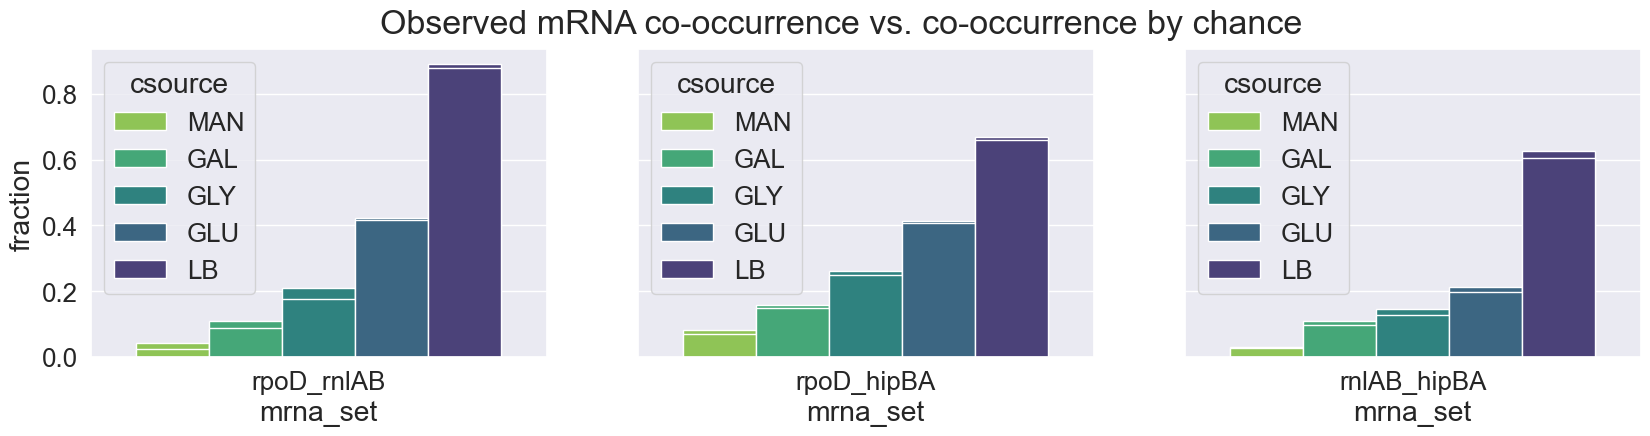

In [141]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
fig.suptitle('Observed mRNA co-occurrence vs. co-occurrence by chance')

g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[0])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='expected', hue='csource', palette='viridis_r', ax=ax[0], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[1])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='expected', hue='csource', palette='viridis_r', ax=ax[1], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[2])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='expected', hue='csource', palette='viridis_r', ax=ax[2], legend=False)

##### Plot - only exp22 data

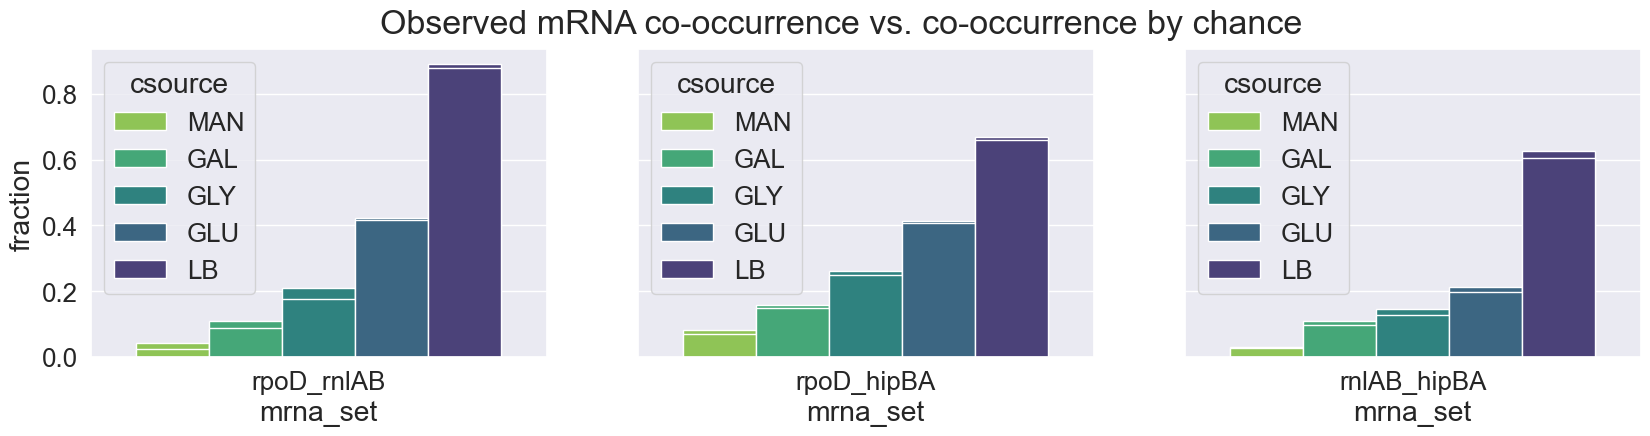

In [142]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
fig.suptitle('Observed mRNA co-occurrence vs. co-occurrence by chance')

g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[0])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='expected', hue='csource', palette='viridis_r', ax=ax[0], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[1])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='expected', hue='csource', palette='viridis_r', ax=ax[1], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[2])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='expected', hue='csource', palette='viridis_r', ax=ax[2], legend=False)

##### Plot - all data

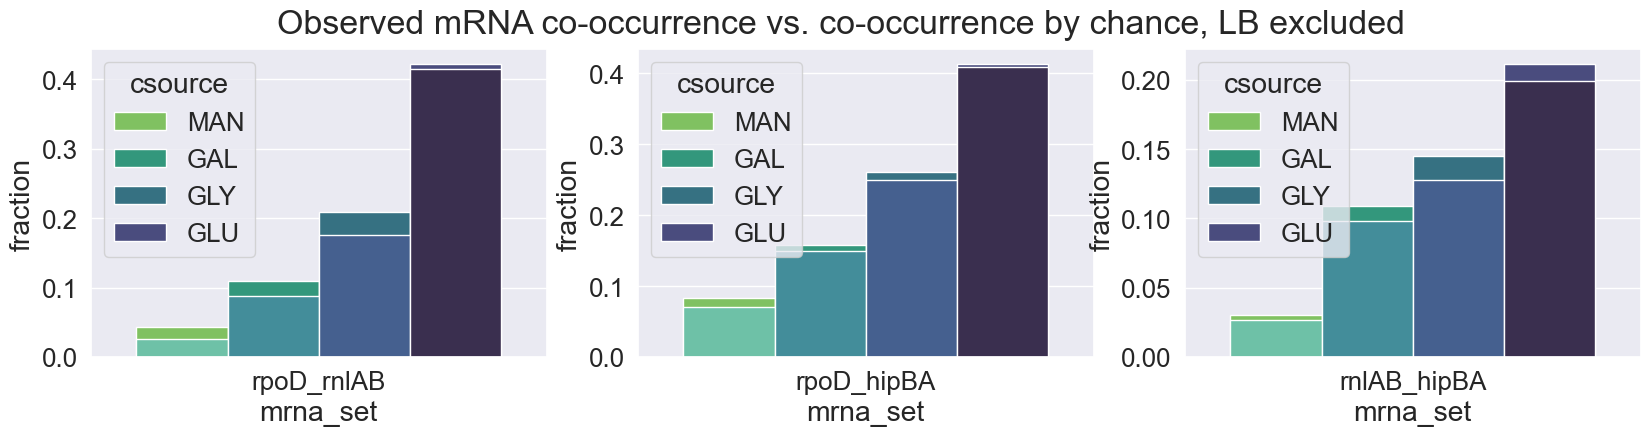

In [143]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=False)
fig.suptitle('Observed mRNA co-occurrence vs. co-occurrence by chance, LB excluded')

g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[0])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='expected', hue='csource', palette='mako_r', ax=ax[0], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[1])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='expected', hue='csource', palette='mako_r', ax=ax[1], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette='viridis_r', ax=ax[2])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='expected', hue='csource', palette='mako_r', ax=ax[2], legend=False)

##### Plot - only exp22 data

/var/folders/pp/cdyfs0g13j3_15mc99_0nfmh0000gn/T/ipykernel_71503/266161668.py:7: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='expected', hue='csource', palette=greys, ax=ax[0], legend=False)
/var/folders/pp/cdyfs0g13j3_15mc99_0nfmh0000gn/T/ipykernel_71503/266161668.py:10: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='expected', hue='csource', palette=greys, ax=ax[1], legend=False)
/var/folders/pp/cdyfs0g13j3_15mc99_0nfmh0000gn/T/ipykernel_71503/266161668.py:13: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  g = sns.barplot(all_frequencies.query('cardinality == 2').query('cs

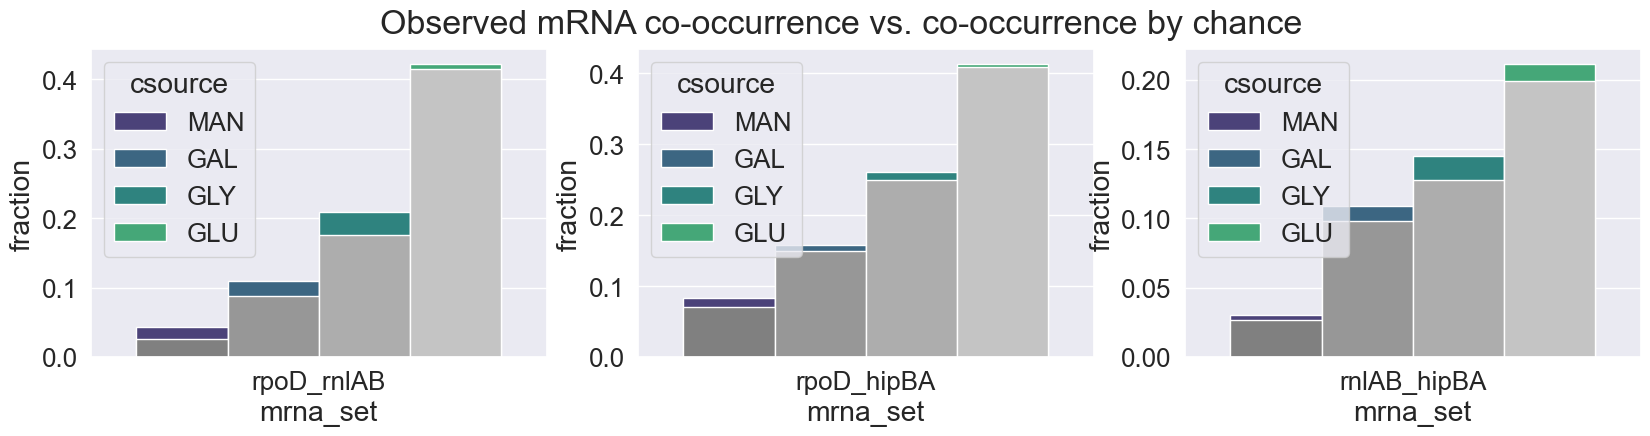

In [144]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4), sharey=False)
fig.suptitle('Observed mRNA co-occurrence vs. co-occurrence by chance')

greys = sns.light_palette("grey", reverse=True)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='fraction', hue='csource', palette=palette_csource, ax=ax[0])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_rnlAB"'), x='mrna_set', y='expected', hue='csource', palette=greys, ax=ax[0], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette=palette_csource, ax=ax[1])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rpoD_hipBA"'), x='mrna_set', y='expected', hue='csource', palette=greys, ax=ax[1], legend=False)

g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='fraction', hue='csource', palette=palette_csource, ax=ax[2])
g = sns.barplot(all_frequencies.query('cardinality == 2').query('csource != "LB"').query('mrna_set == "rnlAB_hipBA"'), x='mrna_set', y='expected', hue='csource', palette=greys, ax=ax[2], legend=False)

savestem = "/Users/adele/Master/Projects/persisters/fig/analysis/cooccurrences"
plt.savefig(savestem + ".pdf")

In [145]:
all_frequencies

counts          mrna_set  cardinality  total  fraction  expected
csource                                                                  
MAN         489              rpoD            1   1885      0.26       NaN
GAL         717              rpoD            1   1955      0.37       NaN
GLY        1406              rpoD            1   2405      0.58       NaN
GLU        1291              rpoD            1   1399      0.92       NaN
LB          976              rpoD            1    997      0.98       NaN
MAN         187             rnlAB            1   1885      0.10       NaN
GAL         471             rnlAB            1   1955      0.24       NaN
GLY         721             rnlAB            1   2405      0.30       NaN
GLU         629             rnlAB            1   1399      0.45       NaN
LB          894             rnlAB            1    997      0.90       NaN
MAN         508             hipBA            1   1885      0.27       NaN
GAL         797             hipBA            1   1955      0.41       NaN
GLY        1024             hipBA            1   2405      0.43       NaN
GLU         619             hipBA            1   1399      0.44       NaN
LB          671             hipBA            1    997      0.67       NaN
MAN          83        rpoD_rnlAB            2   1885      0.04  2.57e-02
GAL         214        rpoD_rnlAB            2   1955      0.11  8.84e-02
GLY         502        rpoD_rnlAB            2   2405      0.21  1.75e-01
GLU         591        rpoD_rnlAB            2   1399      0.42  4.15e-01
LB          888        rpoD_rnlAB            2    997      0.89  8.78e-01
MAN         156        rpoD_hipBA            2   1885      0.08  6.99e-02
GAL         310        rpoD_hipBA            2   1955      0.16  1.50e-01
GLY         627        rpoD_hipBA            2   2405      0.26  2.49e-01
GLU         578        rpoD_hipBA            2   1399      0.41  4.08e-01
LB          665        rpoD_hipBA            2    997      0.67  6.59e-01
MAN          57       rnlAB_hipBA            2   1885      0.03  2.67e-02
GAL         213       rnlAB_hipBA            2   1955      0.11  9.82e-02
GLY         349       rnlAB_hipBA            2   2405      0.15  1.28e-01
GLU         296       rnlAB_hipBA            2   1399      0.21  1.99e-01
LB          625       rnlAB_hipBA            2    997      0.63  6.03e-01
MAN          35  rpoD_rnlAB_hipBA            3   1885      0.02  6.94e-03
GAL         101  rpoD_rnlAB_hipBA            3   1955      0.05  3.60e-02
GLY         243  rpoD_rnlAB_hipBA            3   2405      0.10  7.46e-02
GLU         281  rpoD_rnlAB_hipBA            3   1399      0.20  1.84e-01
LB          621  rpoD_rnlAB_hipBA            3    997      0.62  5.91e-01

#### Area and eccentricity of cells with 1, 2, or 3 of the RNAs


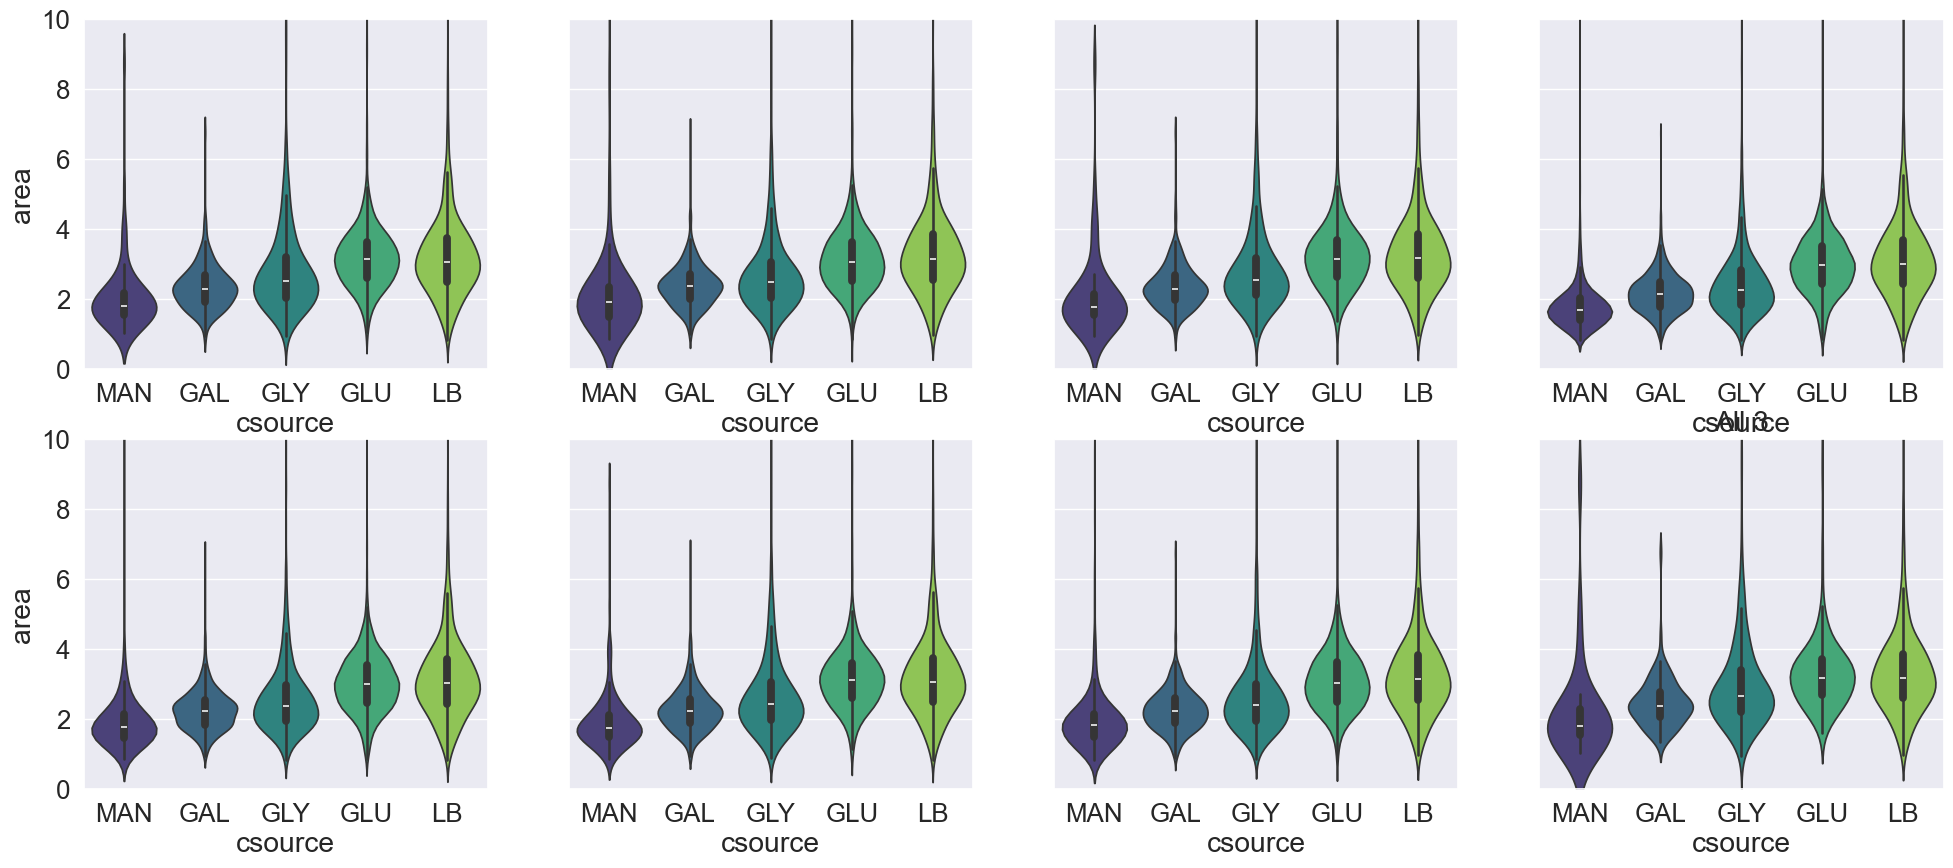

In [147]:
fig, ax = plt.subplots(2, 4, figsize=(24, 10), sharey=True)
ax[0][0].set_ylim(0, 10)
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rpoD > 0').query('spots_rnlAB > 0'), 
            x='csource', y='area', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[0][0])
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rpoD > 0').query('spots_hipBA > 0'), 
            x='csource', y='area', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[0][1])
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rnlAB > 0').query('spots_hipBA > 0'), 
            x='csource', y='area', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[0][2])
sns.violinplot(data=df_records.query('replicate == "exp22"'), 
            x='csource', y='area', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[0][3])

sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rpoD > 0'), 
            x='csource', y='area', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[1][0])
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rnlAB > 0'), 
            x='csource', y='area', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[1][1])
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_hipBA > 0'), 
            x='csource', y='area', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[1][2])
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rpoD > 0').query('spots_rnlAB > 0').query('spots_hipBA > 0'), 
            x='csource', y='area', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[1][3]).set_title("All 3");


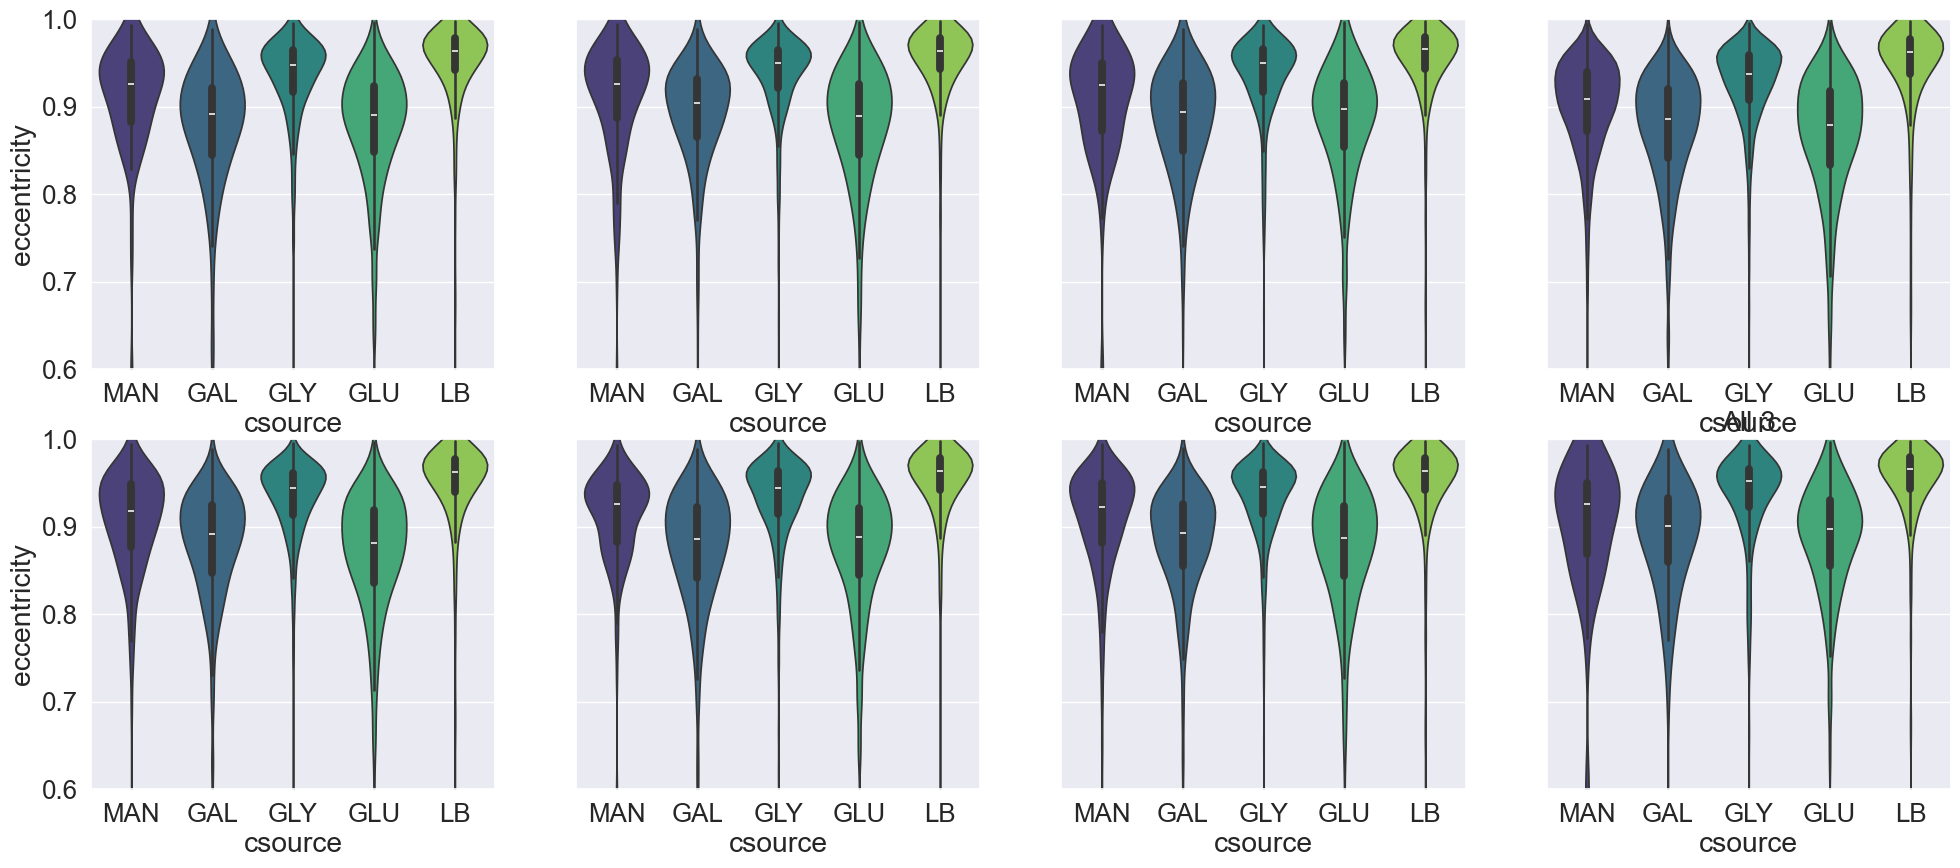

In [148]:
fig, ax = plt.subplots(2, 4, figsize=(24, 10), sharey=True)
ax[0][0].set_ylim(0.6, 1)
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rpoD > 0').query('spots_rnlAB > 0'), 
            x='csource', y='eccentricity', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[0][0])
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rpoD > 0').query('spots_hipBA > 0'), 
            x='csource', y='eccentricity', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[0][1])
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rnlAB > 0').query('spots_hipBA > 0'), 
            x='csource', y='eccentricity', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[0][2])
sns.violinplot(data=df_records.query('replicate == "exp22"'), 
            x='csource', y='eccentricity', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[0][3])

sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rpoD > 0'), 
            x='csource', y='eccentricity', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[1][0])
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rnlAB > 0'), 
            x='csource', y='eccentricity', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[1][1])
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_hipBA > 0'), 
            x='csource', y='eccentricity', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[1][2])
sns.violinplot(data=df_records.query('replicate == "exp22"').query('spots_rpoD > 0').query('spots_rnlAB > 0').query('spots_hipBA > 0'), 
            x='csource', y='eccentricity', hue='csource', order=csources_ordered, palette=palette_csource, ax=ax[1][3]).set_title("All 3");


### Localisation

#### Distance of spots to cell centroid/closest cell tip


#### Distance of spots to cell mask

#### Distance of spots to closest nucleoid tip

#### Distance of spots to nuclei


### Transcription sites

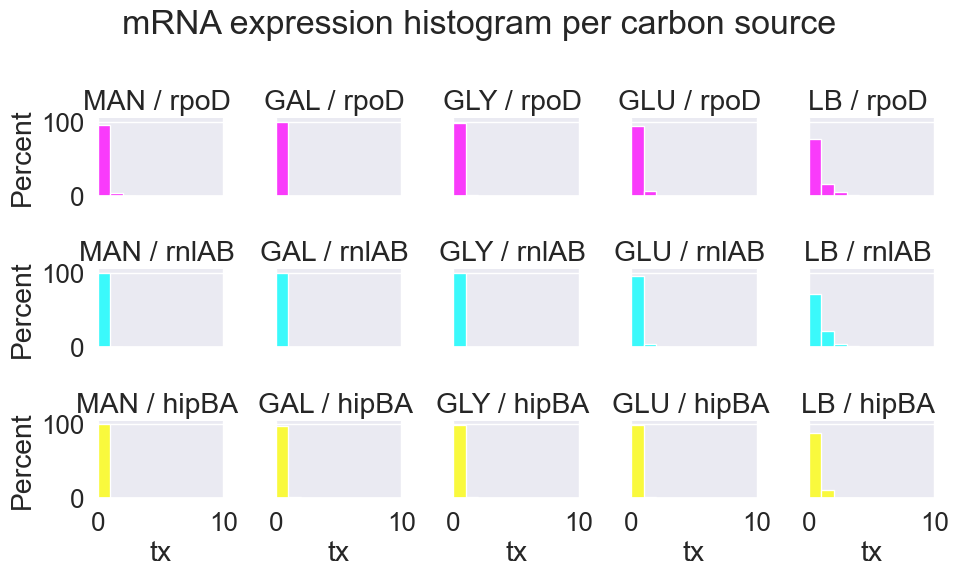

In [149]:
g = sns.FacetGrid(df_stacked, row='mrna', row_order=mrna_ordered, col='csource', col_order=csources_ordered, 
                  xlim=(0, 10), sharex=True, sharey=True, hue='mrna', palette=palette_mrna, height=2);
g.map_dataframe(sns.histplot, x='tx', binwidth=1, stat='percent')
g.set_titles('{col_name} / {row_name} ');
g.fig.suptitle('mRNA expression histogram per carbon source')
g.tight_layout();


## Quality control

### Inspect images individually

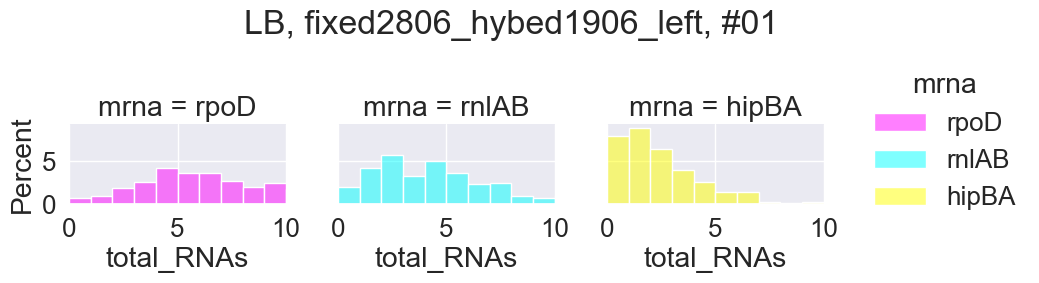

In [150]:
image = 'MG1655_LB_fixed2806_hybed1906_left_01'
data = df_stacked.query('image == @image')

fields = data.iloc[0, :].to_dict()
title = f"{fields['csource']}, {fields['coverslip']}, #{fields['seqnr']}"

g = sns.displot(data=data, x='total_RNAs', col='mrna', col_order=mrna_ordered, binwidth=1, stat='percent',
                hue='mrna', palette=palette_mrna, height=3, facet_kws={'xlim': [0, 10], 'sharex': True, 'sharey':True})
g.fig.suptitle(title)
g.tight_layout();

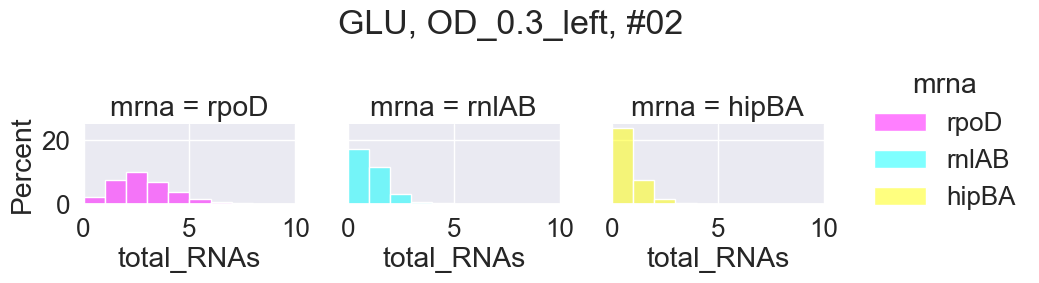

In [151]:
image = 'MG1655_GLU_OD_0.3_left_02'
data = df_stacked.query('image == @image')

fields = data.iloc[0, :].to_dict()
title = f"{fields['csource']}, {fields['coverslip']}, #{fields['seqnr']}"

g = sns.displot(data=data, x='total_RNAs', col='mrna', col_order=mrna_ordered, binwidth=1, stat='percent',
                hue='mrna', palette=palette_mrna, height=3, facet_kws={'xlim': [0, 10], 'sharex': True, 'sharey':True})
g.fig.suptitle(title)
g.tight_layout();

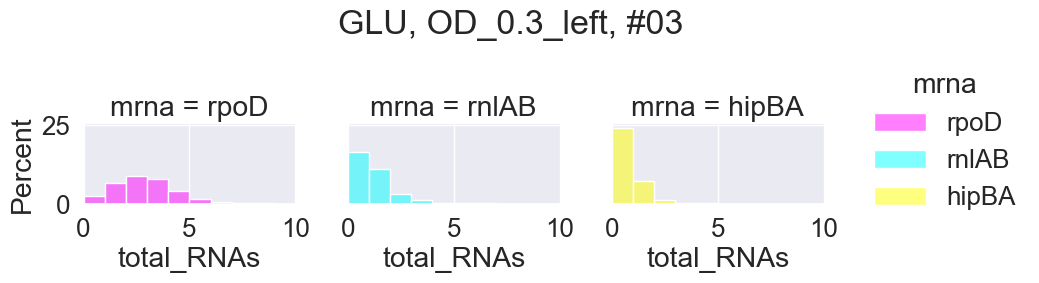

In [152]:
image = 'MG1655_GLU_OD_0.3_left_03'
data = df_stacked.query('image == @image')

fields = data.iloc[0, :].to_dict()
title = f"{fields['csource']}, {fields['coverslip']}, #{fields['seqnr']}"

g = sns.displot(data=data, x='total_RNAs', col='mrna', col_order=mrna_ordered, binwidth=1, stat='percent',
                hue='mrna', palette=palette_mrna, height=3, facet_kws={'xlim': [0, 10], 'sharex': True, 'sharey':True})
g.fig.suptitle(title)
g.tight_layout();

### Spot intensity histograms
Spots in cells versus spots outside cells

See `intensities.ipynb` notebook.